<a href="https://colab.research.google.com/github/YolandaMDavis/cs109a-fall2020/blob/main/CS109_Notebook_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, roc_auc_score
from imblearn.over_sampling import SMOTE
DATA_ROOT = '/content/drive/My Drive/Final-Project-for-CS109a/Milestone3/'

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
new_york_crime_data_df = pd.read_csv(DATA_ROOT + 'nyc_crime_analysis_data_final_corrected.csv').drop(columns=["Unnamed: 0"])
boston_crime_data_df = pd.read_csv(DATA_ROOT + 'boston_crime_analysis_data_final_corrected.csv').drop(columns=["Unnamed: 0"])
combined_crime_data_df = pd.concat([boston_crime_data_df, new_york_crime_data_df])

## **Boston Correlation Data with Violent Crime Indicator**

Our final datasets for New York City and Boston are based on the crime, COVID, and demographic data from the respective cities' data hubs, then augmented with our own factors. For some factors, this was relatively simple (creating indicators for each type of crime), while others required more work (given a crime, use the haversine function to calculate distances to the nearest streetlights, then find the number of streetlights within 80m for `STREETLIGHT_DENSITY`.

Before we do anything by way of modeling, let's see if there are any glaring correlations in the data. Here, we look at correlations in the basic dataframe (only an indicator for violence).

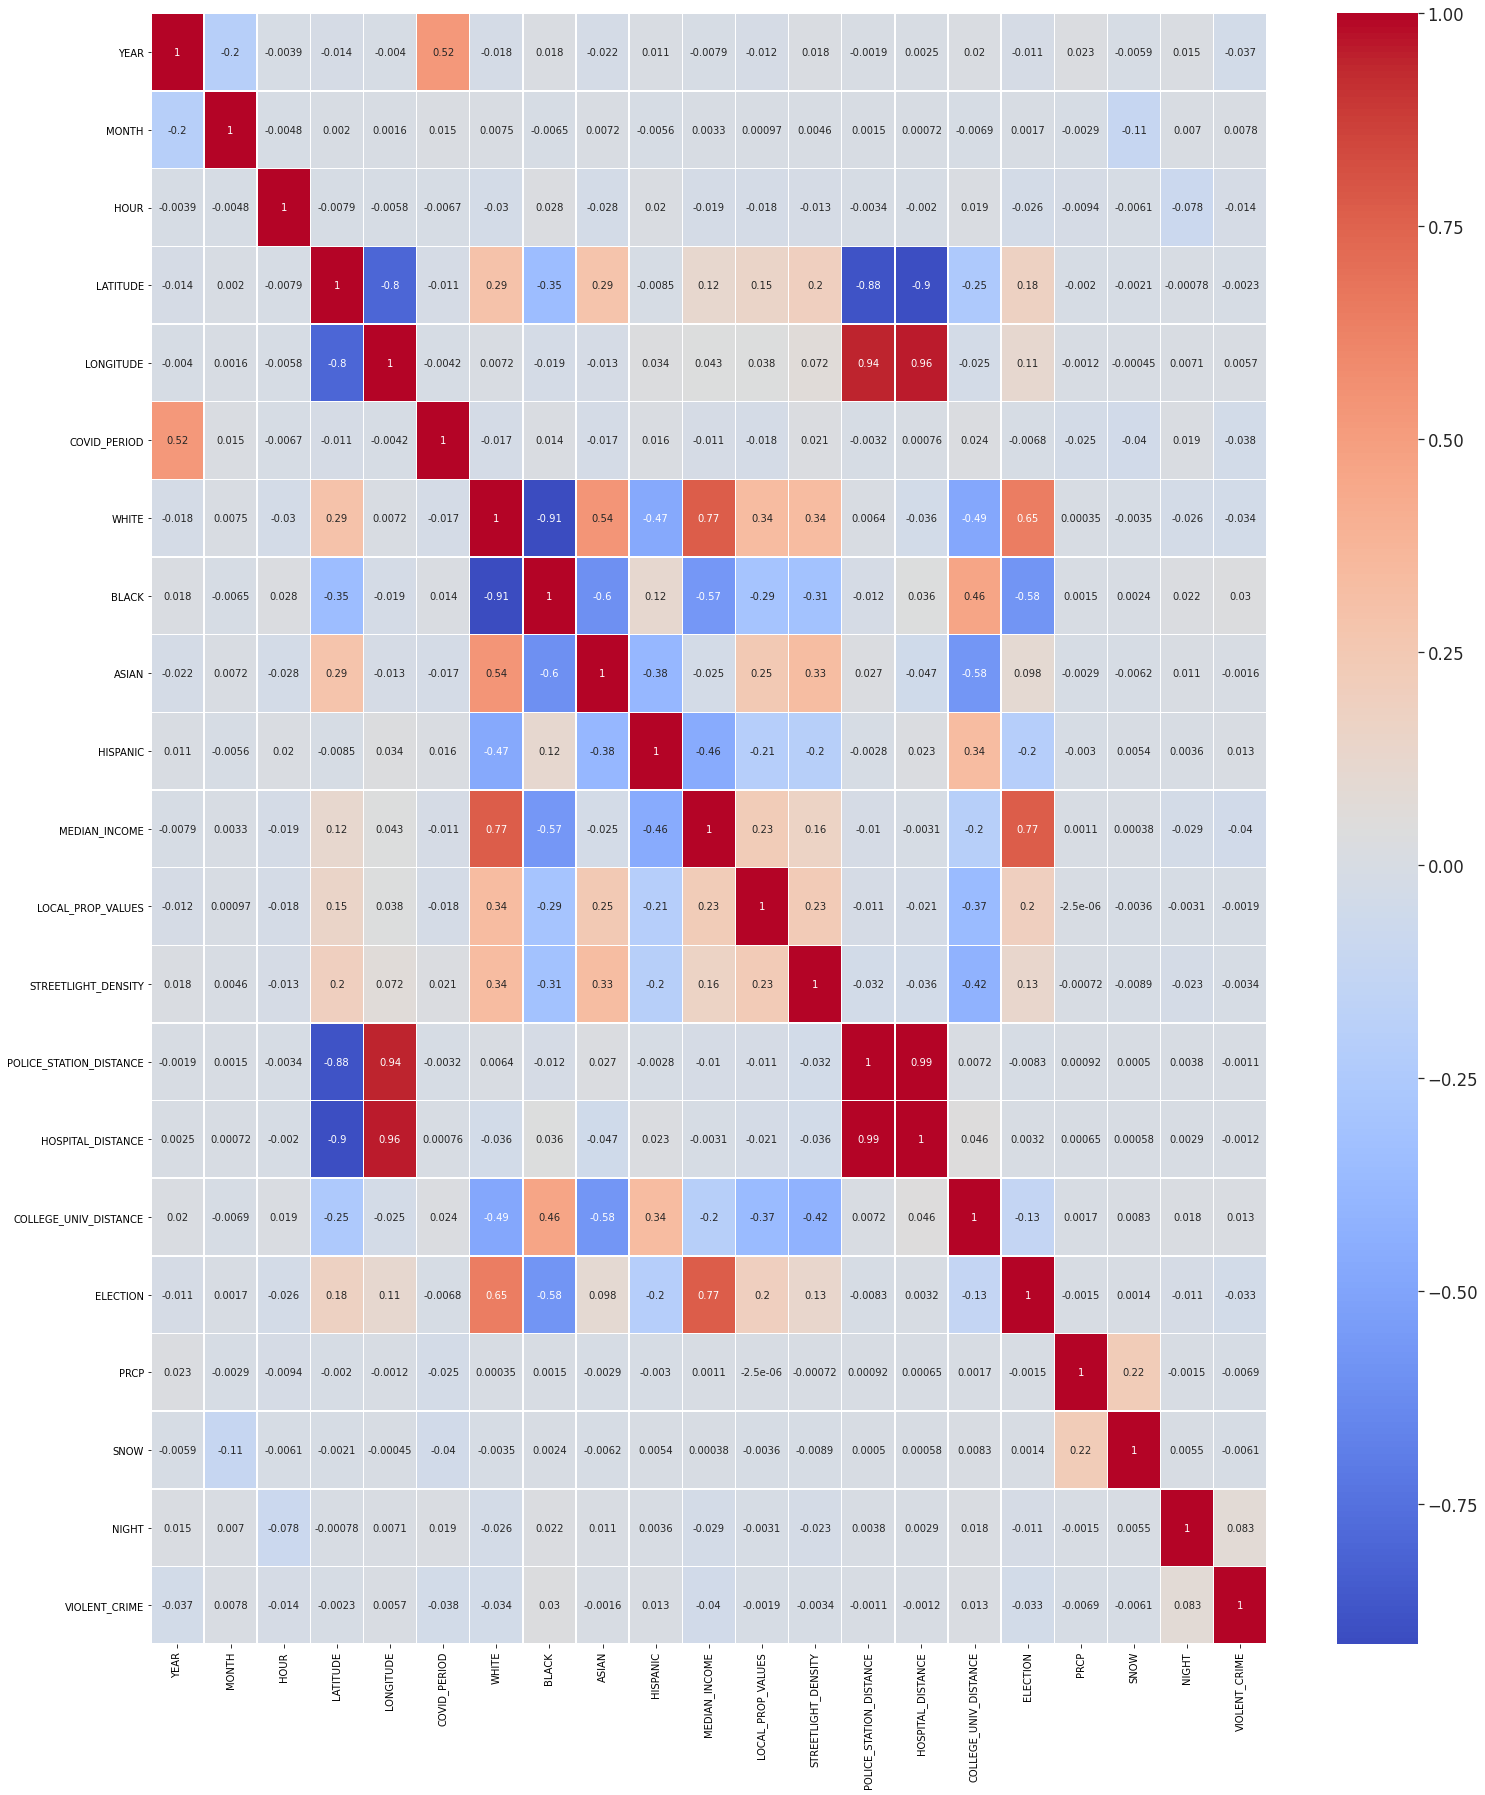

In [4]:
boston_corr = boston_crime_data_df.corr()
fig, ax = plt.subplots(figsize=(25,30)) 
sns.set(font_scale=1.5) 
ax = sns.heatmap(boston_corr, annot=True, cmap='coolwarm', linewidths=.5, annot_kws={"fontsize":10})

## **Boston Correlation Data with Offense Type Indicators**

We do the same for just the offense type. Beyond the obvious correlations (`latitude`/`longitude` and the distance-related indicators), we don't see many strong correlations of note, though there are some minor correlations. For example, looking at the indicator for violent crime, there is an unexpected positive correlation between that indicator and distances to schools/hospitals. Here and later on, we look at correlation data for different subsets of the data.

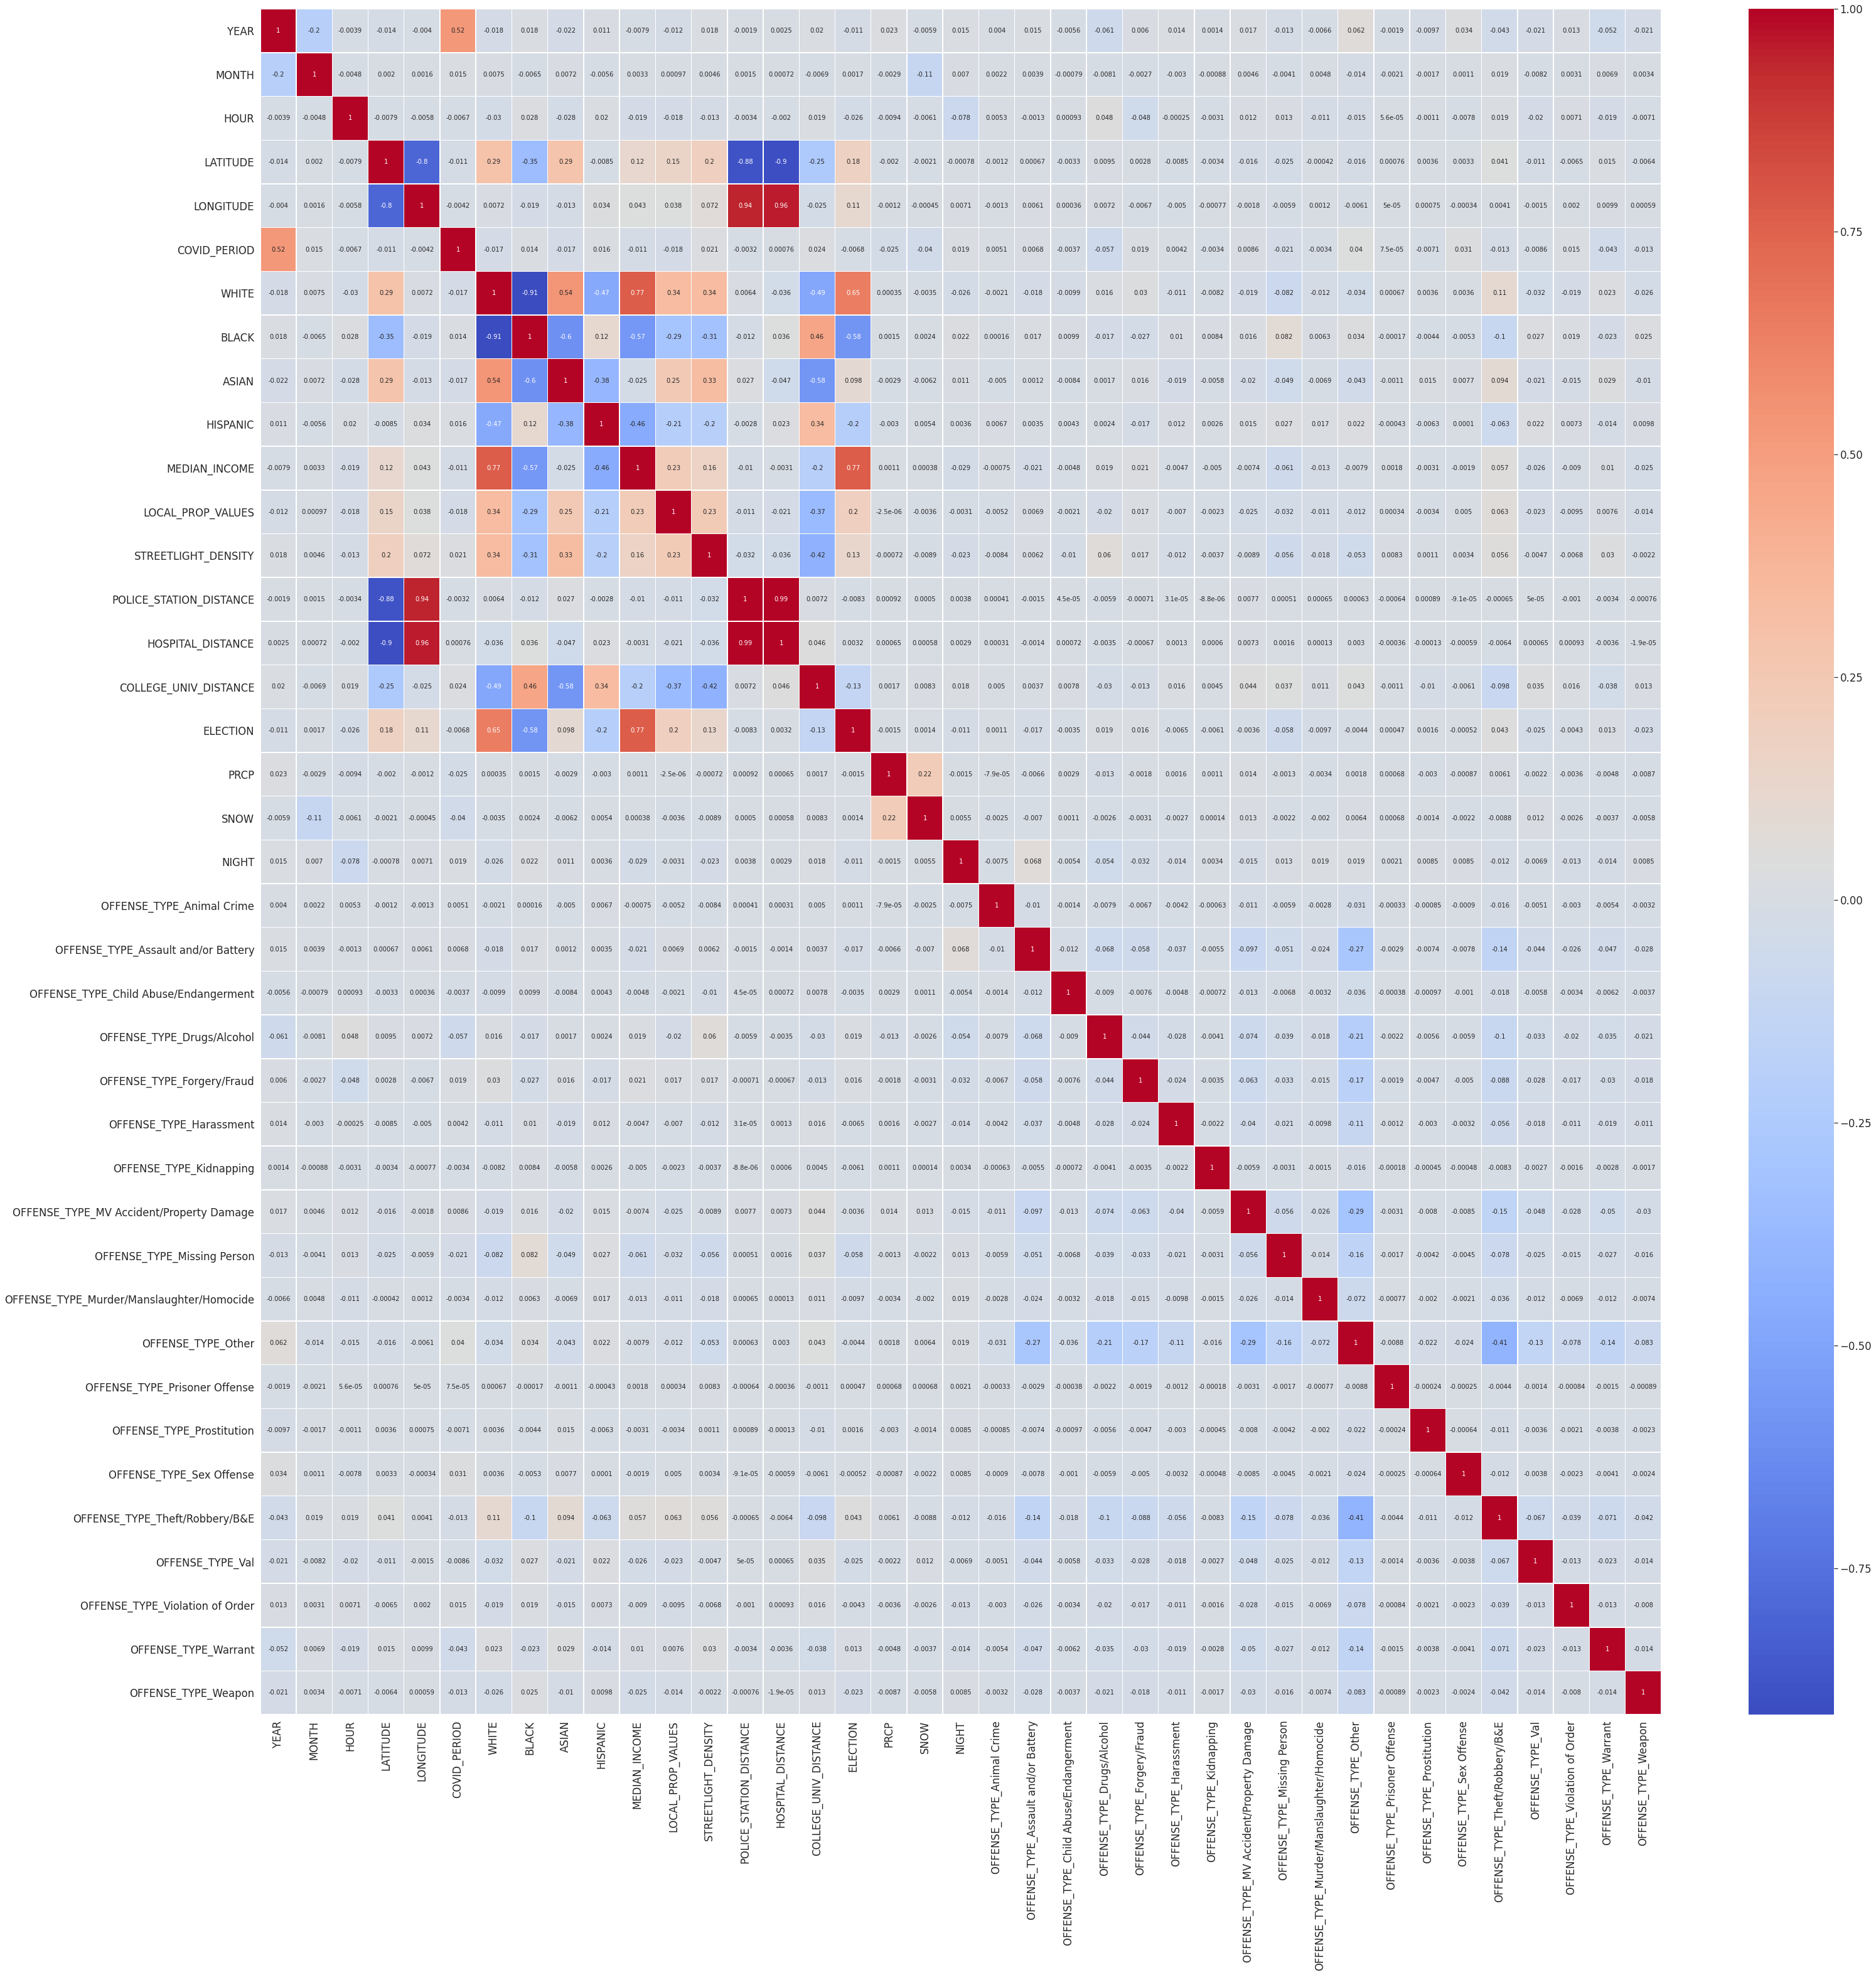

In [5]:
# Create one hot encoded types for offenses and perform correlation against features
demog_category_columns = ['OFFENSE_TYPE']
boston_crime_dummies_df = pd.get_dummies(boston_crime_data_df, columns=demog_category_columns)
boston_corr = boston_crime_dummies_df.drop(columns=['VIOLENT_CRIME']).corr()
fig, ax = plt.subplots(figsize=(50,50)) 
sns.set(font_scale=1.5)
ax = sns.heatmap(boston_corr, annot=True, cmap='coolwarm', linewidths=.5, annot_kws={"fontsize":10})

## **Boston Correlation Data with Offense Type Indicators (Focus Areas)**

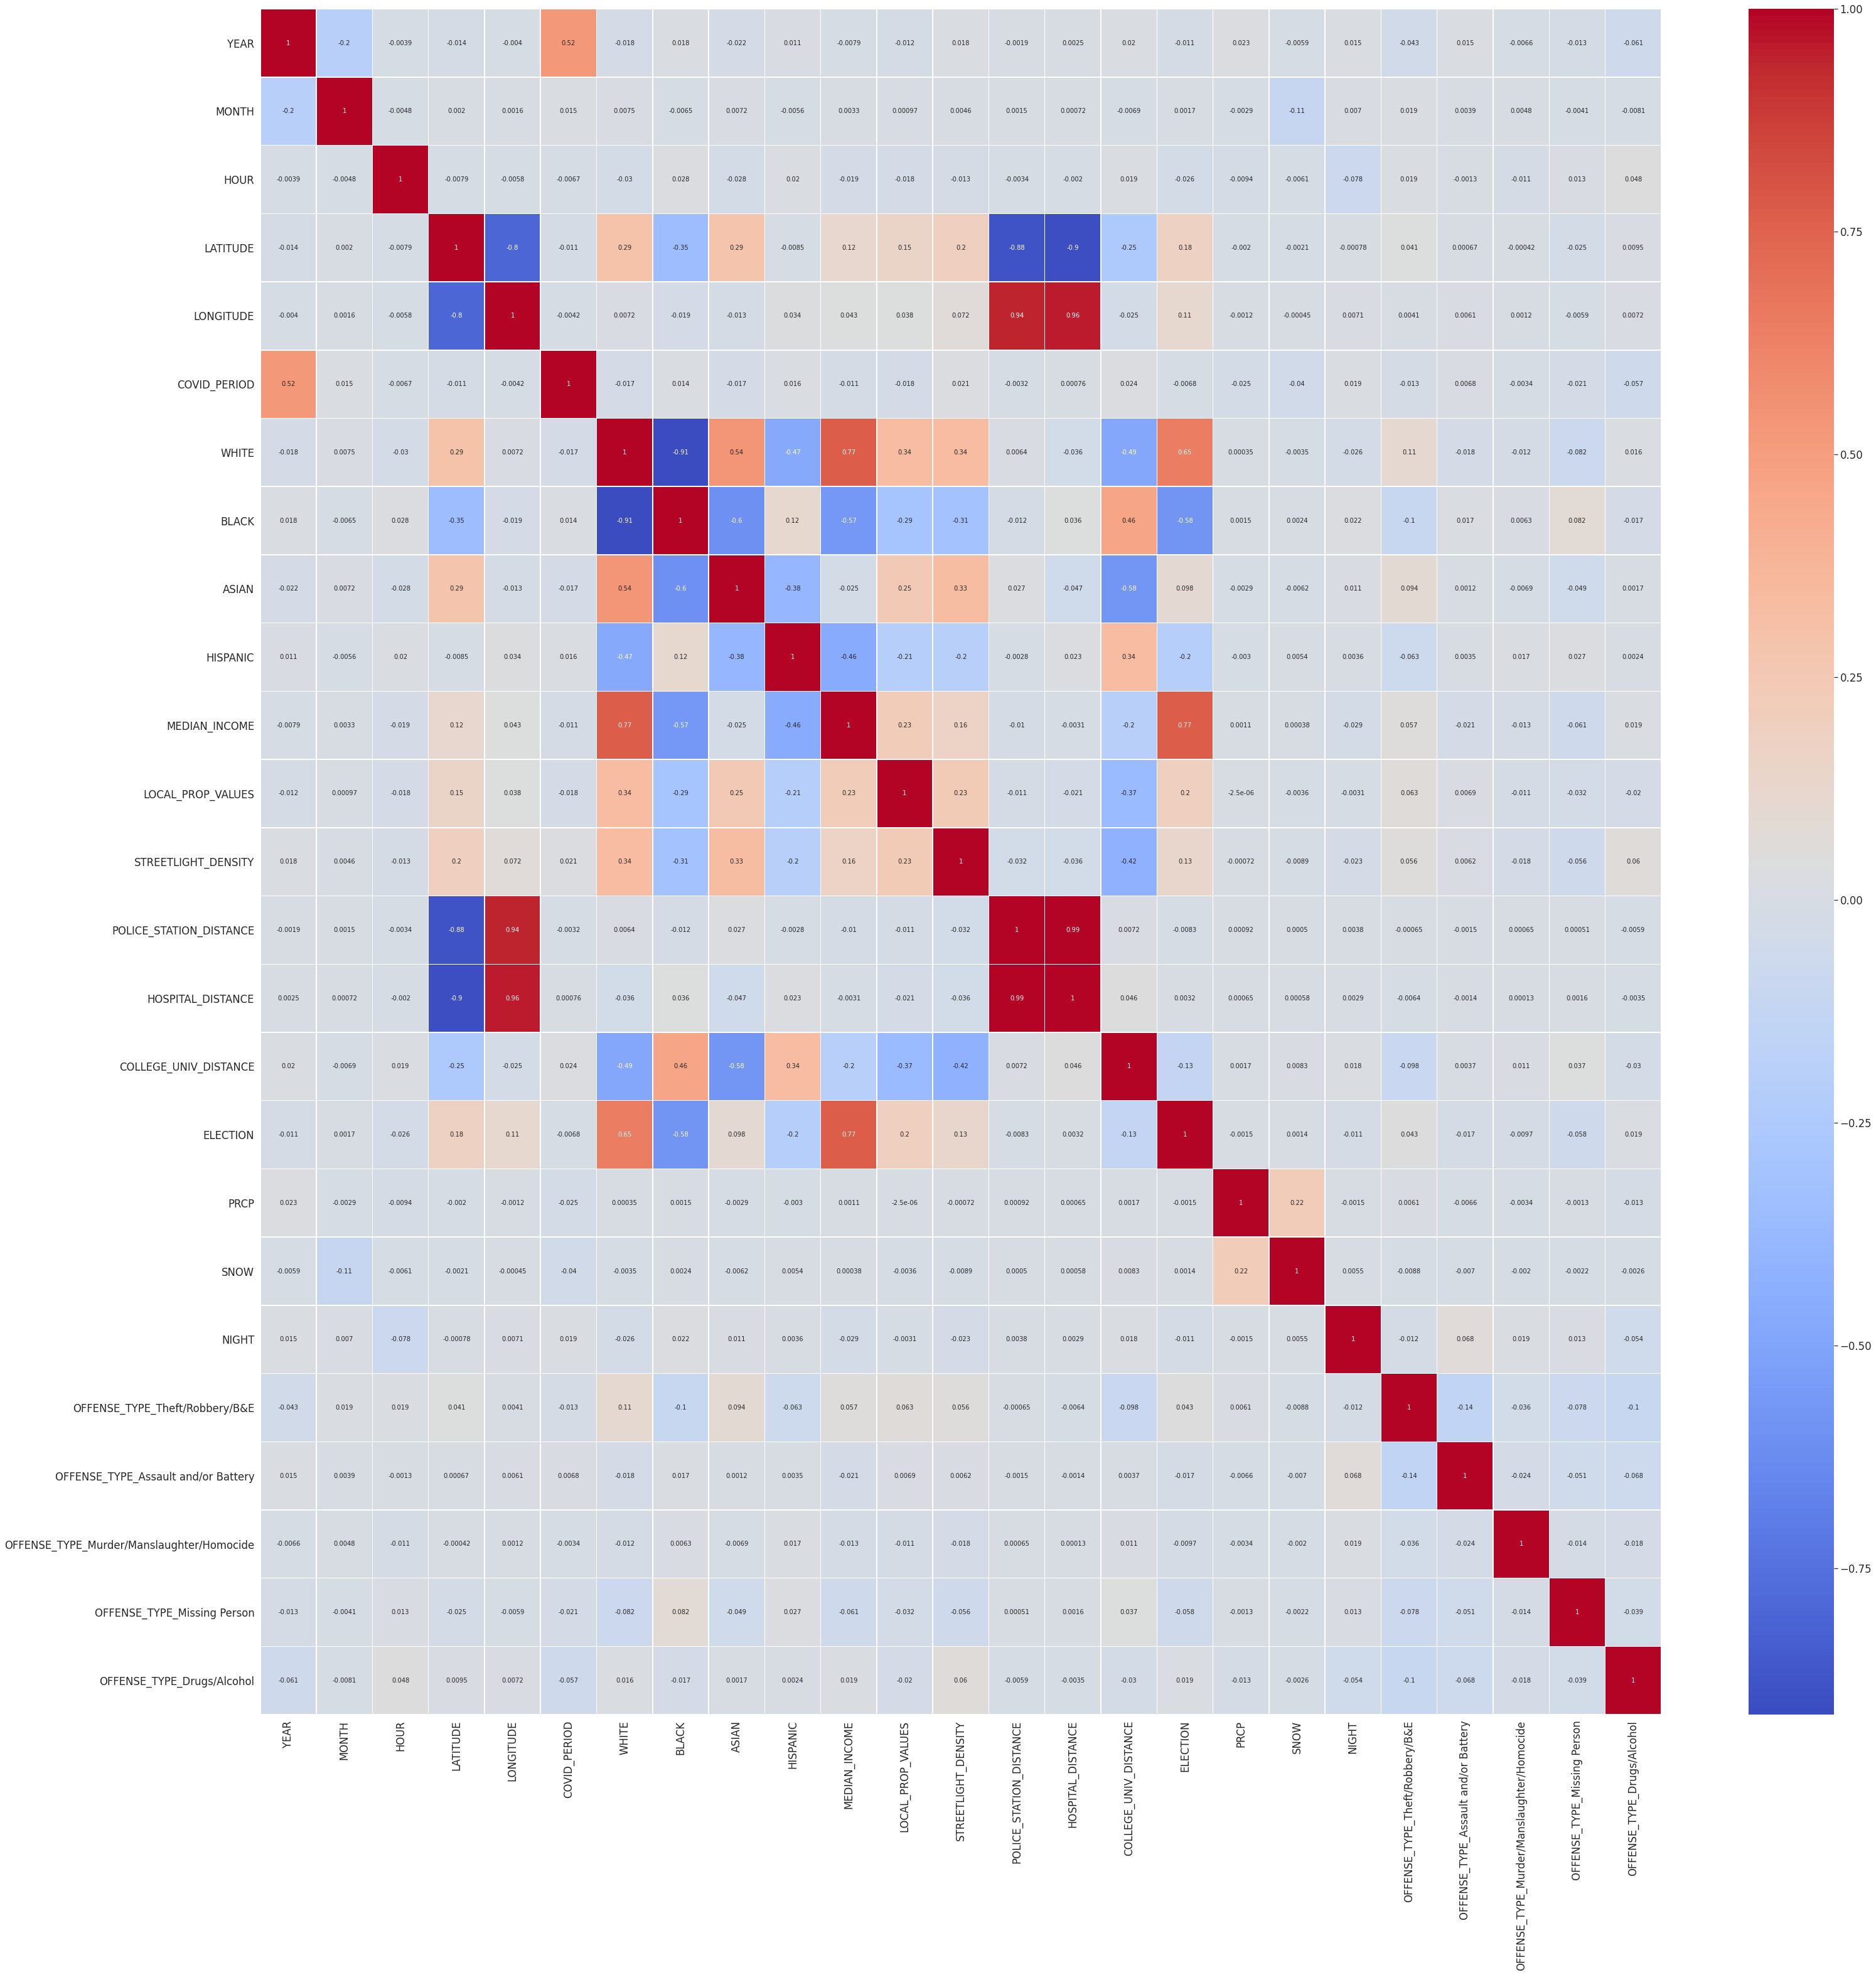

In [6]:
# Isolated areas of interest for correlation review
demog_category_columns = ['OFFENSE_TYPE']
boston_crime_dummies_df = pd.get_dummies(boston_crime_data_df, columns=demog_category_columns)
filter_columns = ['AREA', 'YEAR', 'MONTH', 'DAY_OF_WEEK', 'HOUR', 'LATITUDE', 'LONGITUDE',
       'GEOHASH', 'COVID_PERIOD', 'WHITE', 'BLACK', 'ASIAN', 'HISPANIC',
       'MEDIAN_INCOME', 'LOCAL_PROP_VALUES', 'STREETLIGHT_DENSITY',
       'POLICE_STATION_DISTANCE', 'HOSPITAL_DISTANCE', 'COLLEGE_UNIV_DISTANCE',
       'ELECTION', 'PRCP', 'SNOW', 'NIGHT', 'OFFENSE_TYPE_Theft/Robbery/B&E','OFFENSE_TYPE_Assault and/or Battery','OFFENSE_TYPE_Murder/Manslaughter/Homocide','OFFENSE_TYPE_Missing Person', 'OFFENSE_TYPE_Drugs/Alcohol']

boston_corr = boston_crime_dummies_df.drop(columns=['VIOLENT_CRIME'])[filter_columns].corr()
fig, ax = plt.subplots(figsize=(50,50)) 
sns.set(font_scale=1.5)
ax = sns.heatmap(boston_corr, annot=True, cmap='coolwarm', linewidths=.5, annot_kws={"fontsize":10})

## **Combined Boston/NYC Correlation Data with Violent Crime Indicator**


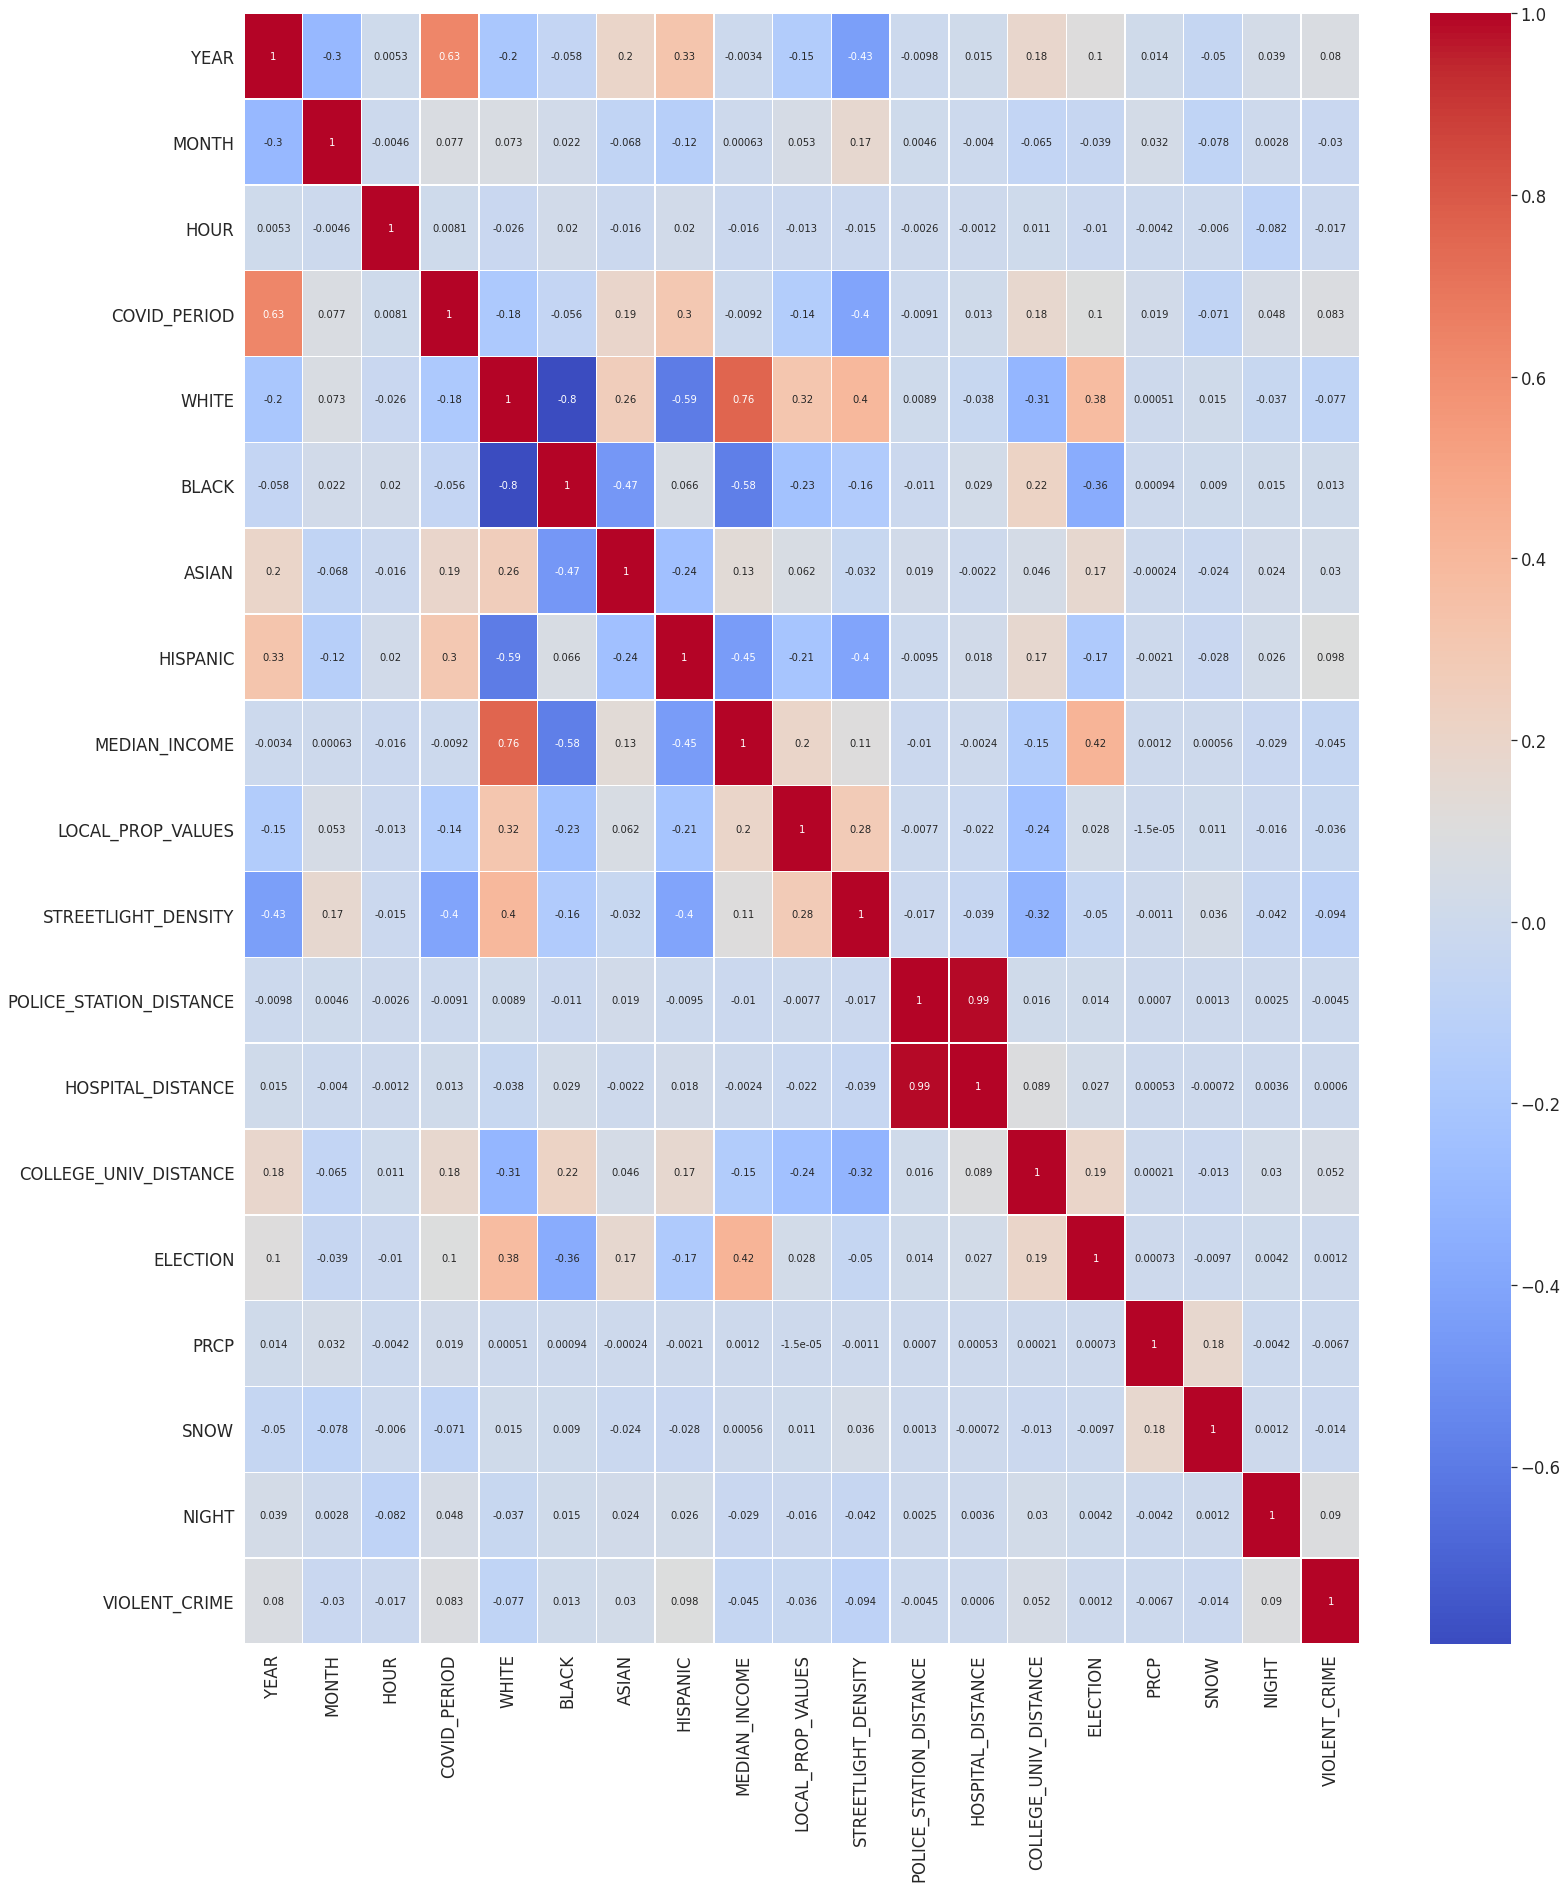

In [7]:
comb_corr = combined_crime_data_df.drop(columns=["AREA","LATITUDE","LONGITUDE"]).corr()
fig, ax = plt.subplots(figsize=(25,30)) 
sns.set(font_scale=1.5)
ax = sns.heatmap(comb_corr, annot=True, cmap='coolwarm', linewidths=.5, annot_kws={"fontsize":10})

## **Combined Boston/NYC Correlation Data with Offense Type Indicators**

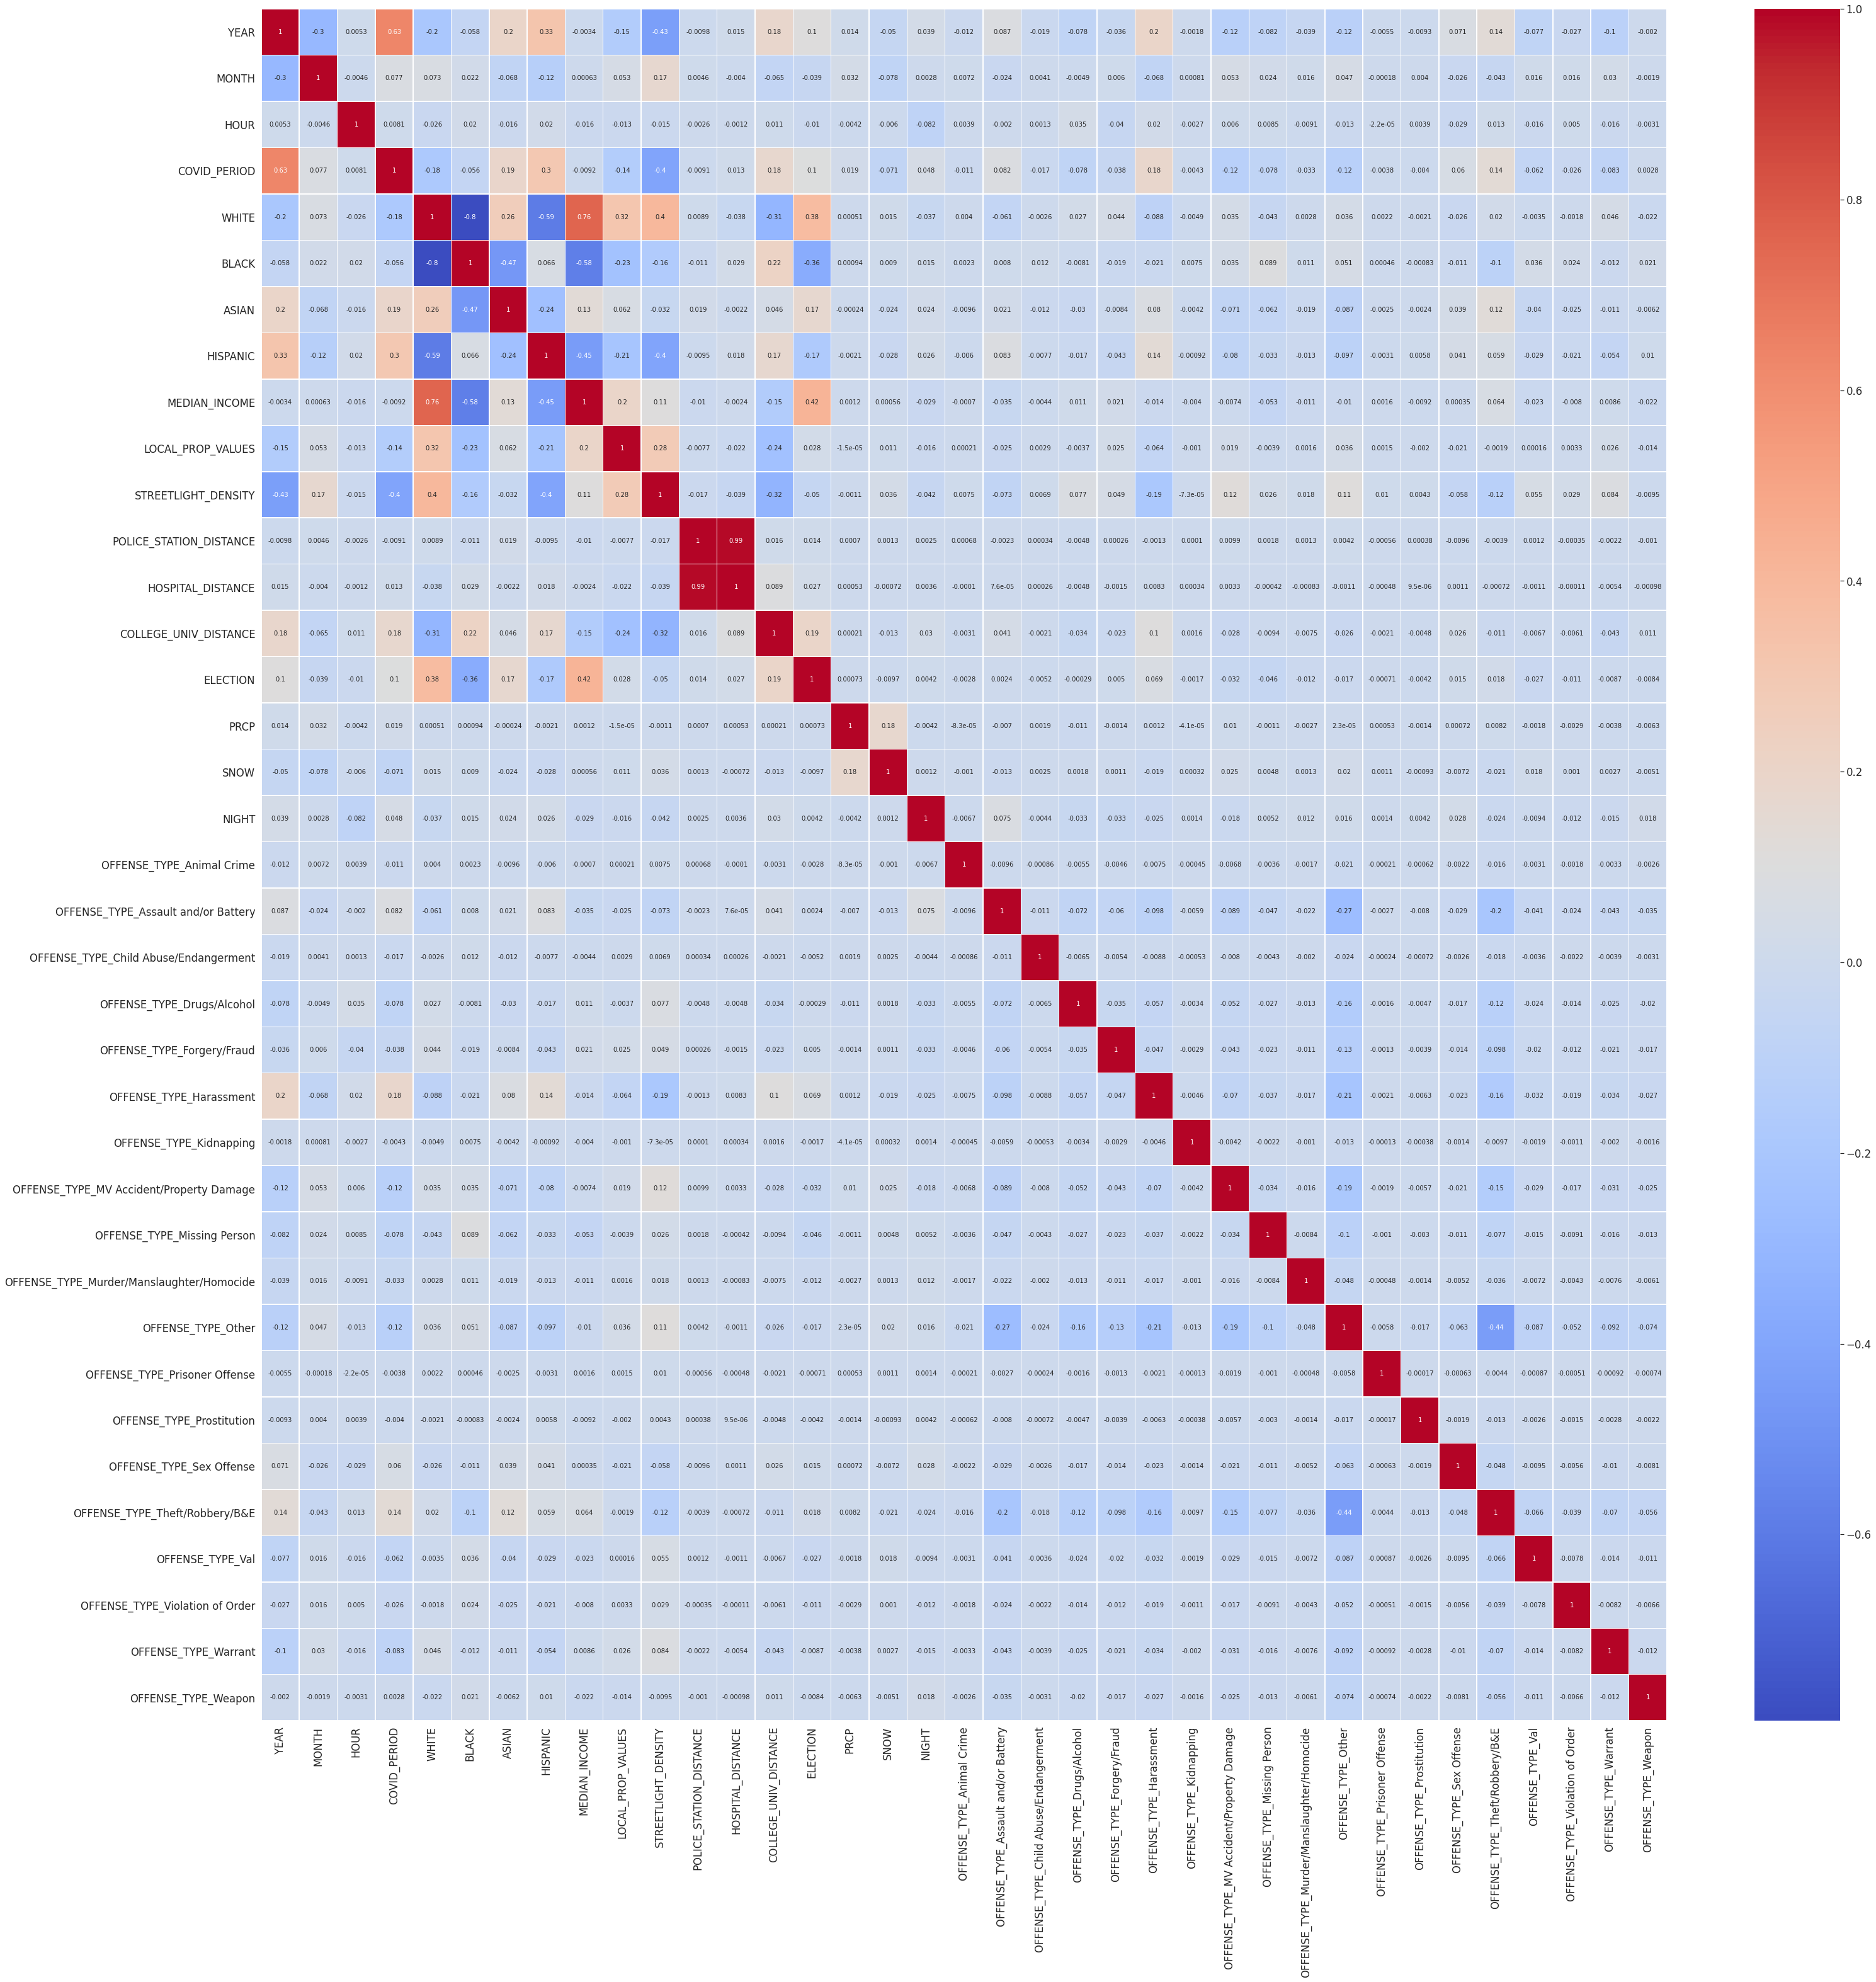

In [8]:
demog_category_columns = ['OFFENSE_TYPE']
combined_crime_dummies_df = pd.get_dummies(combined_crime_data_df, columns=demog_category_columns)
#dropping year since there is only one value for it
comb_corr = combined_crime_dummies_df.drop(columns=["VIOLENT_CRIME","AREA","LATITUDE","LONGITUDE"]).corr()
fig, ax = plt.subplots(figsize=(50,50)) 
sns.set(font_scale=1.5)
ax = sns.heatmap(comb_corr, annot=True, cmap='coolwarm', linewidths=.5, annot_kws={"fontsize":10})

## **Combined Boston/NYC Correlation Data with Offense Type Indicators (Focus Areas)**

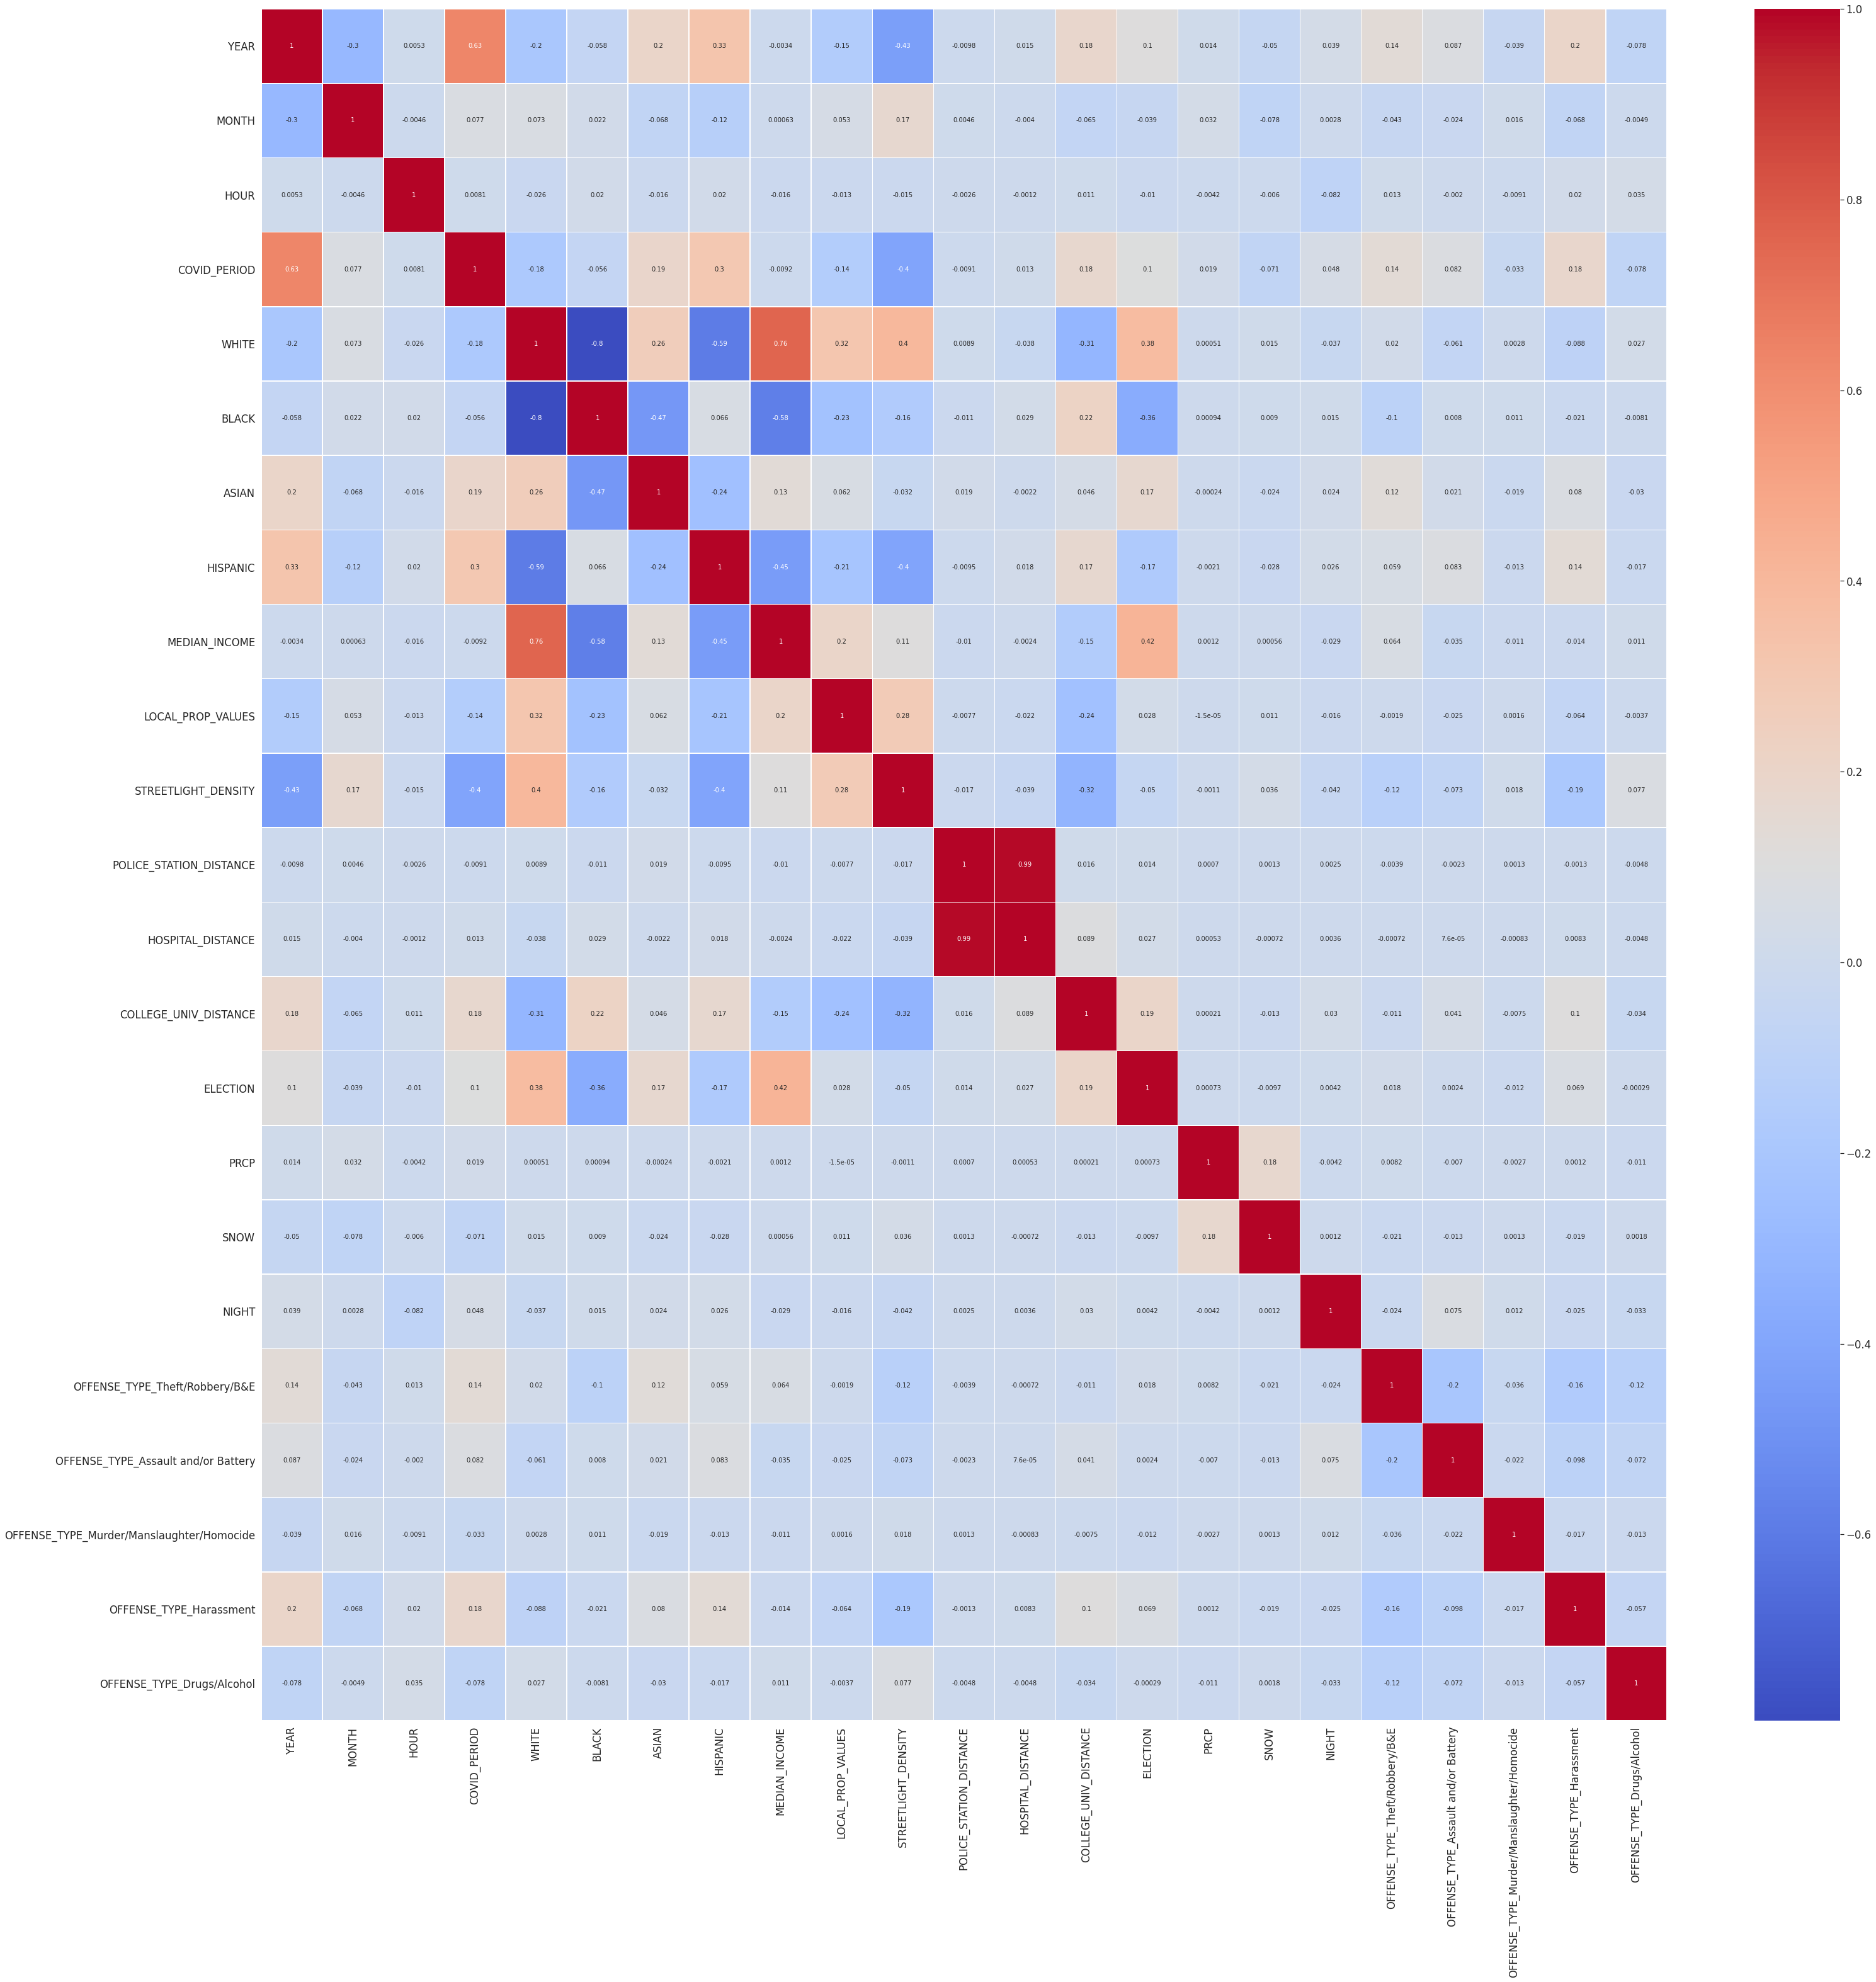

In [9]:
demog_category_columns = ['OFFENSE_TYPE']
combined_crime_dummies_df = pd.get_dummies(combined_crime_data_df, columns=demog_category_columns)
filter_columns = ['YEAR','MONTH', 'DAY_OF_WEEK', 'HOUR', 'COVID_PERIOD', 'WHITE', 'BLACK', 'ASIAN', 'HISPANIC',
       'MEDIAN_INCOME', 'LOCAL_PROP_VALUES', 'STREETLIGHT_DENSITY',
       'POLICE_STATION_DISTANCE', 'HOSPITAL_DISTANCE', 'COLLEGE_UNIV_DISTANCE',
       'ELECTION', 'PRCP', 'SNOW', 'NIGHT', 'OFFENSE_TYPE_Theft/Robbery/B&E','OFFENSE_TYPE_Assault and/or Battery','OFFENSE_TYPE_Murder/Manslaughter/Homocide','OFFENSE_TYPE_Harassment', 'OFFENSE_TYPE_Drugs/Alcohol']
#dropping year since there is only one value for it
comb_corr = combined_crime_dummies_df.drop(columns=["VIOLENT_CRIME"])[filter_columns].corr()
fig, ax = plt.subplots(figsize=(50,50)) 
sns.set(font_scale=1.5)
ax = sns.heatmap(comb_corr, annot=True, cmap='coolwarm', linewidths=.5, annot_kws={"fontsize":10})

Overall, the most unexpected correlations were for factors related to distance from universities or police stations, and density of streetlights. For example, harassment and streetlight density are negatively correlated, while motor vehicle-related incidents are positively correlated with streetlight density.

We can also use the latitude and longitude data to see where spikes in violent crime tend to occur. Here, we see where the darker areas coincide with violent crime spikes in both cities.

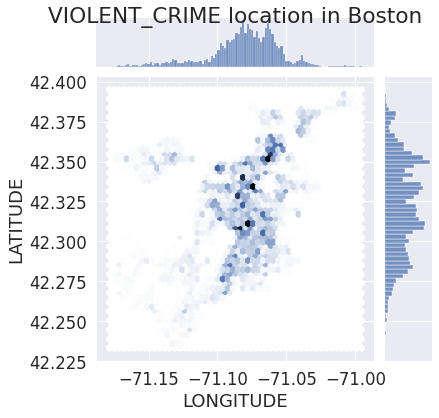

In [10]:
# Violent Crime LAT/LONG
Violent = boston_crime_data_df.loc[boston_crime_data_df['VIOLENT_CRIME']== 1]
sns.jointplot(x='LONGITUDE',y='LATITUDE',data=Violent,kind='hex')
plt.suptitle('VIOLENT_CRIME location in Boston')
plt.show()

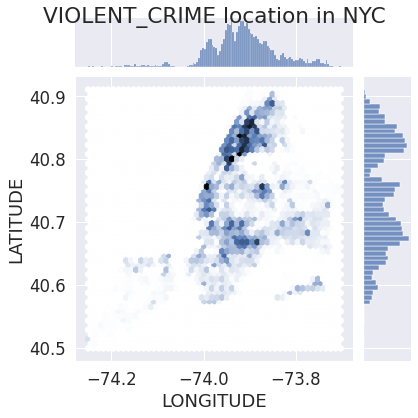

In [11]:
# Lat/long exploration for NYC
Violent =new_york_crime_data_df.loc[new_york_crime_data_df['VIOLENT_CRIME']== 1]
sns.jointplot(x='LONGITUDE',y='LATITUDE',data=Violent,kind='hex')
plt.suptitle('VIOLENT_CRIME location in NYC')
plt.show()

We can also do a deeper exploration of how time of day affects the type of crime, or the likelihood of crime to be violent. We also look at streetlight density data, and see the trend that crimes tend to be more prevalent in areas where streetlights are less dense, for both Boston and New York City.

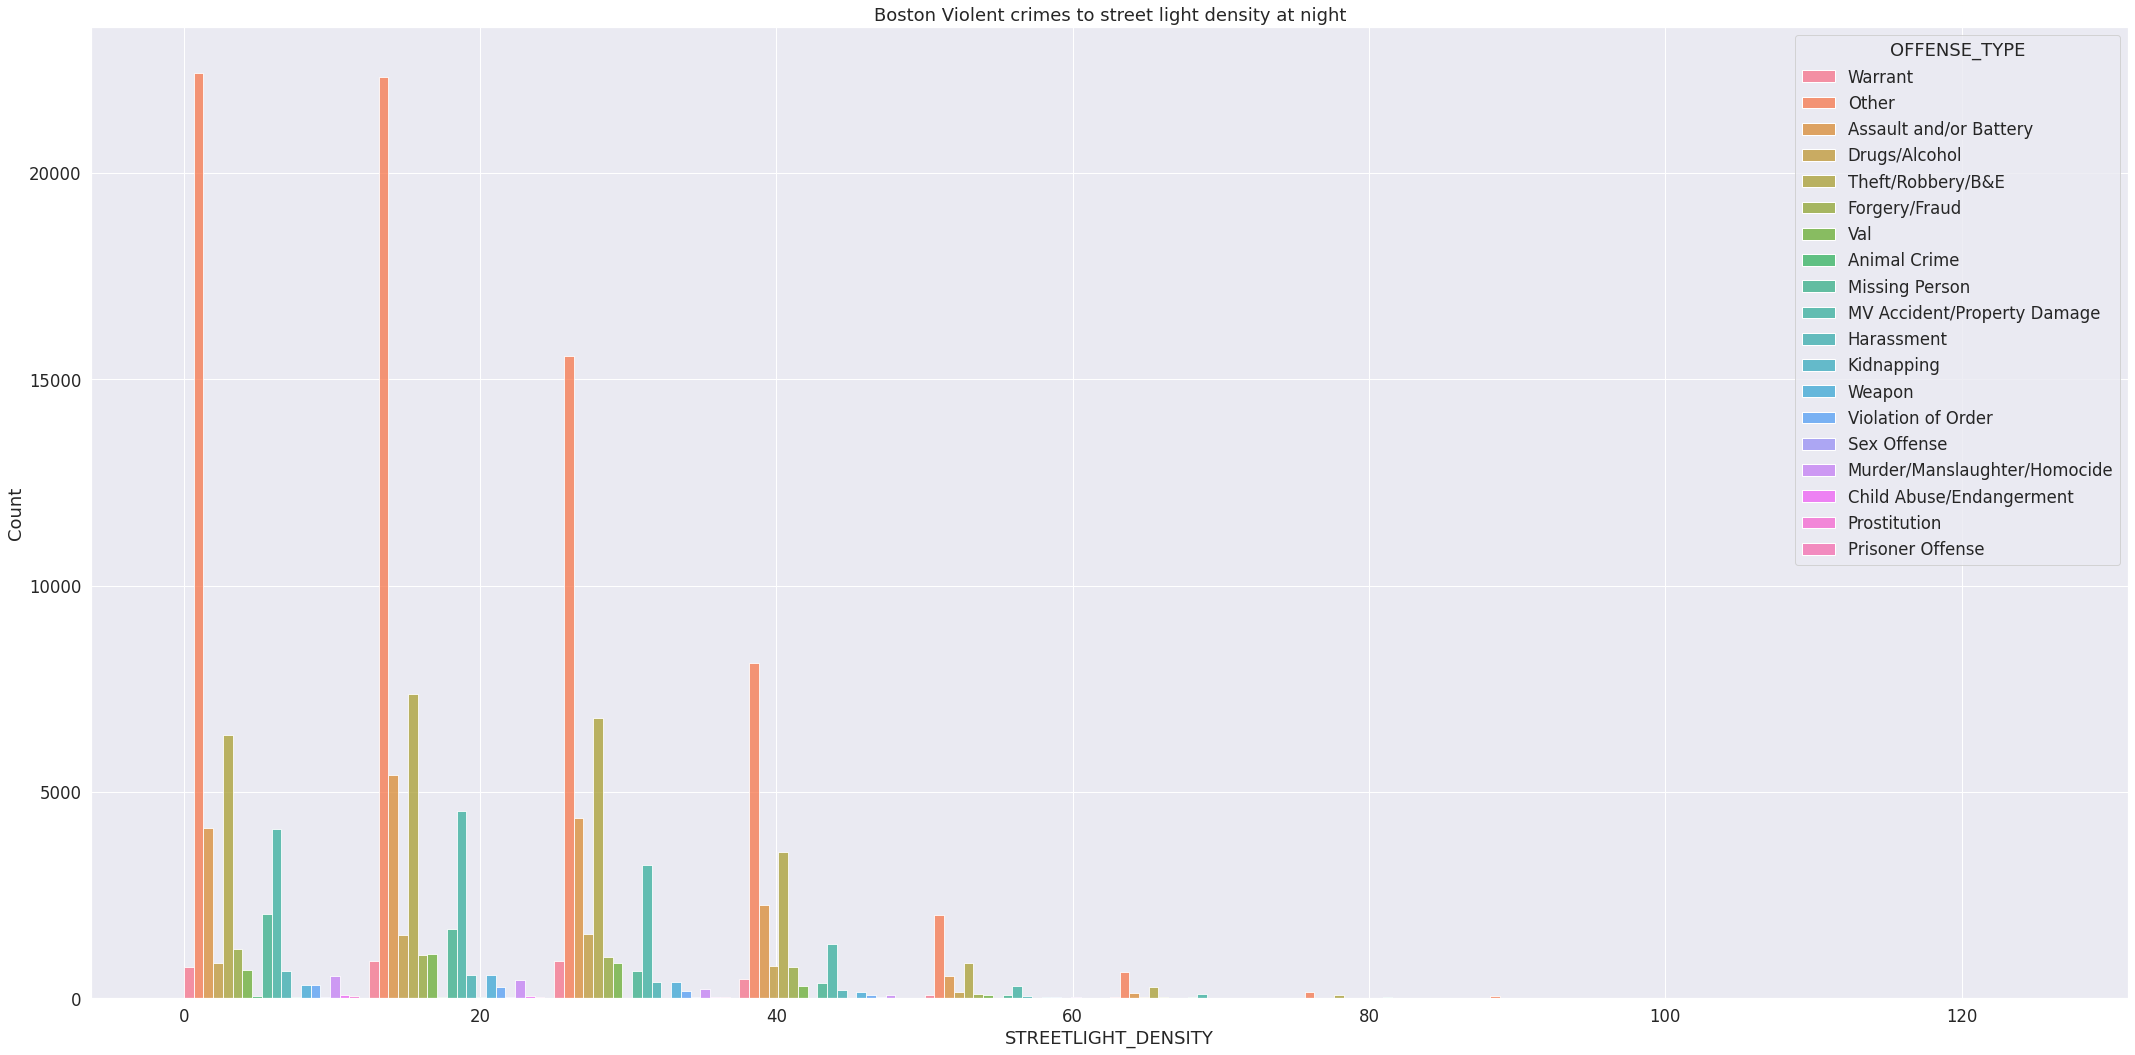

In [12]:
# Streetlight density/offense type for Boston

interaction_night_boston=boston_crime_data_df[boston_crime_data_df.NIGHT == 1]['STREETLIGHT_DENSITY']
night_offence_boston=boston_crime_data_df[boston_crime_data_df.NIGHT == 1]['OFFENSE_TYPE']

fig, ax = plt.subplots(1,figsize=(30,15),sharey=False)

sns.histplot(boston_crime_data_df,x=interaction_night_boston, ax=ax ,multiple="dodge", hue=night_offence_boston,bins=10)

ax.set_title('Boston Violent crimes to street light density at night')
plt.tight_layout()
plt.show()

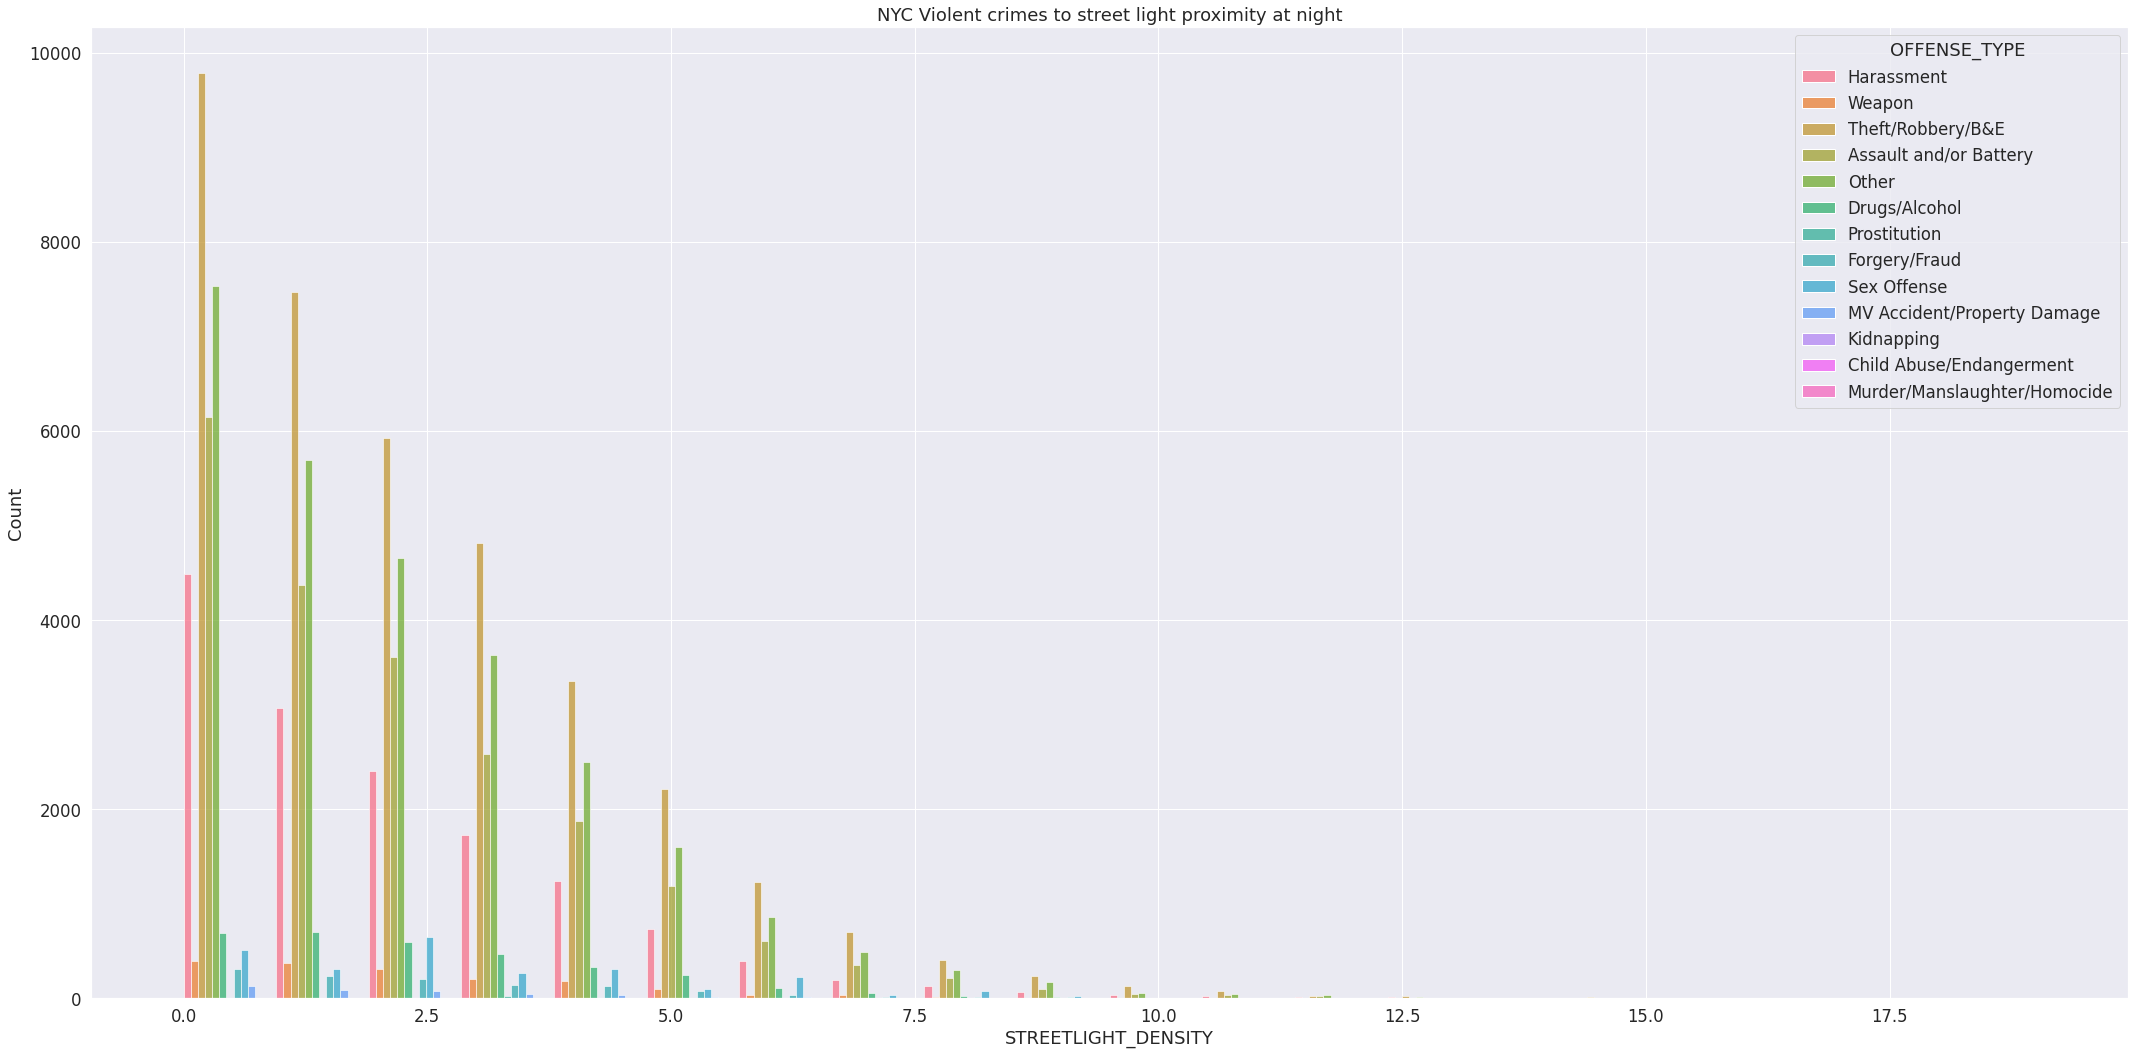

In [13]:
# Streetlight density/offense type for NYC
import matplotlib.ticker as ticker
interaction_night_nyc=new_york_crime_data_df[new_york_crime_data_df.NIGHT == 1]['STREETLIGHT_DENSITY']
night_offence_nyc=new_york_crime_data_df[new_york_crime_data_df.NIGHT == 1]['OFFENSE_TYPE']
fig, ax = plt.subplots(1,figsize=(30,15),sharey=False)
sns.histplot(new_york_crime_data_df,x=interaction_night_nyc, color='y', ax=ax ,multiple="dodge", hue=night_offence_nyc ,bins=20)
#plt.xticks([0,1],['Non-Violent','Violent'],fontsize=14)
ax.set_title('NYC Violent crimes to street light proximity at night')
plt.tight_layout()
plt.show()

We can also see differences in crime occurrences (in terms of both violent/nonviolent and offense type) for night and day.

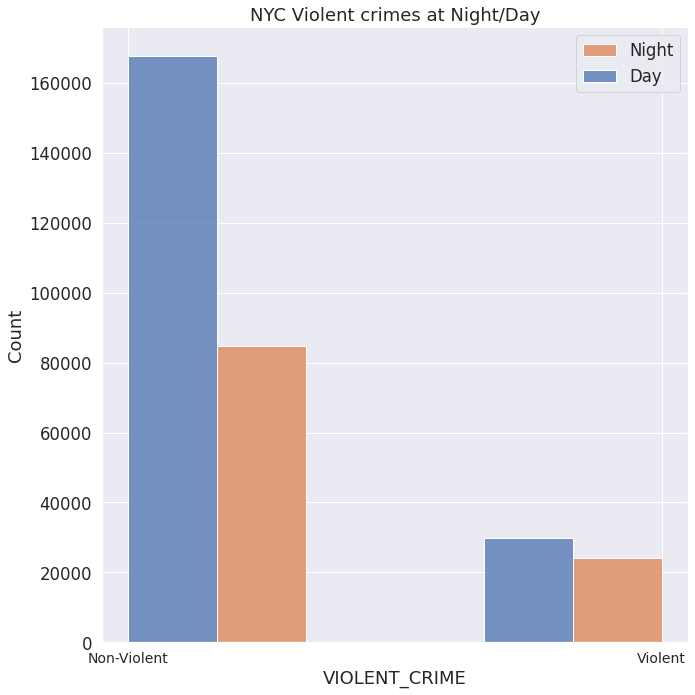

In [14]:
import matplotlib.ticker as ticker

fig, ax = plt.subplots(1,figsize=(10,10),sharey=False)
sns.histplot(new_york_crime_data_df,x='VIOLENT_CRIME', color='y', ax=ax , hue="NIGHT",multiple="dodge",bins=3)
plt.xticks([0,1],['Non-Violent','Violent'],fontsize=14)
ax.set_title('NYC Violent crimes at Night/Day')
plt.legend(loc='upper right', labels=['Night','Day'])
plt.tight_layout()
plt.show()

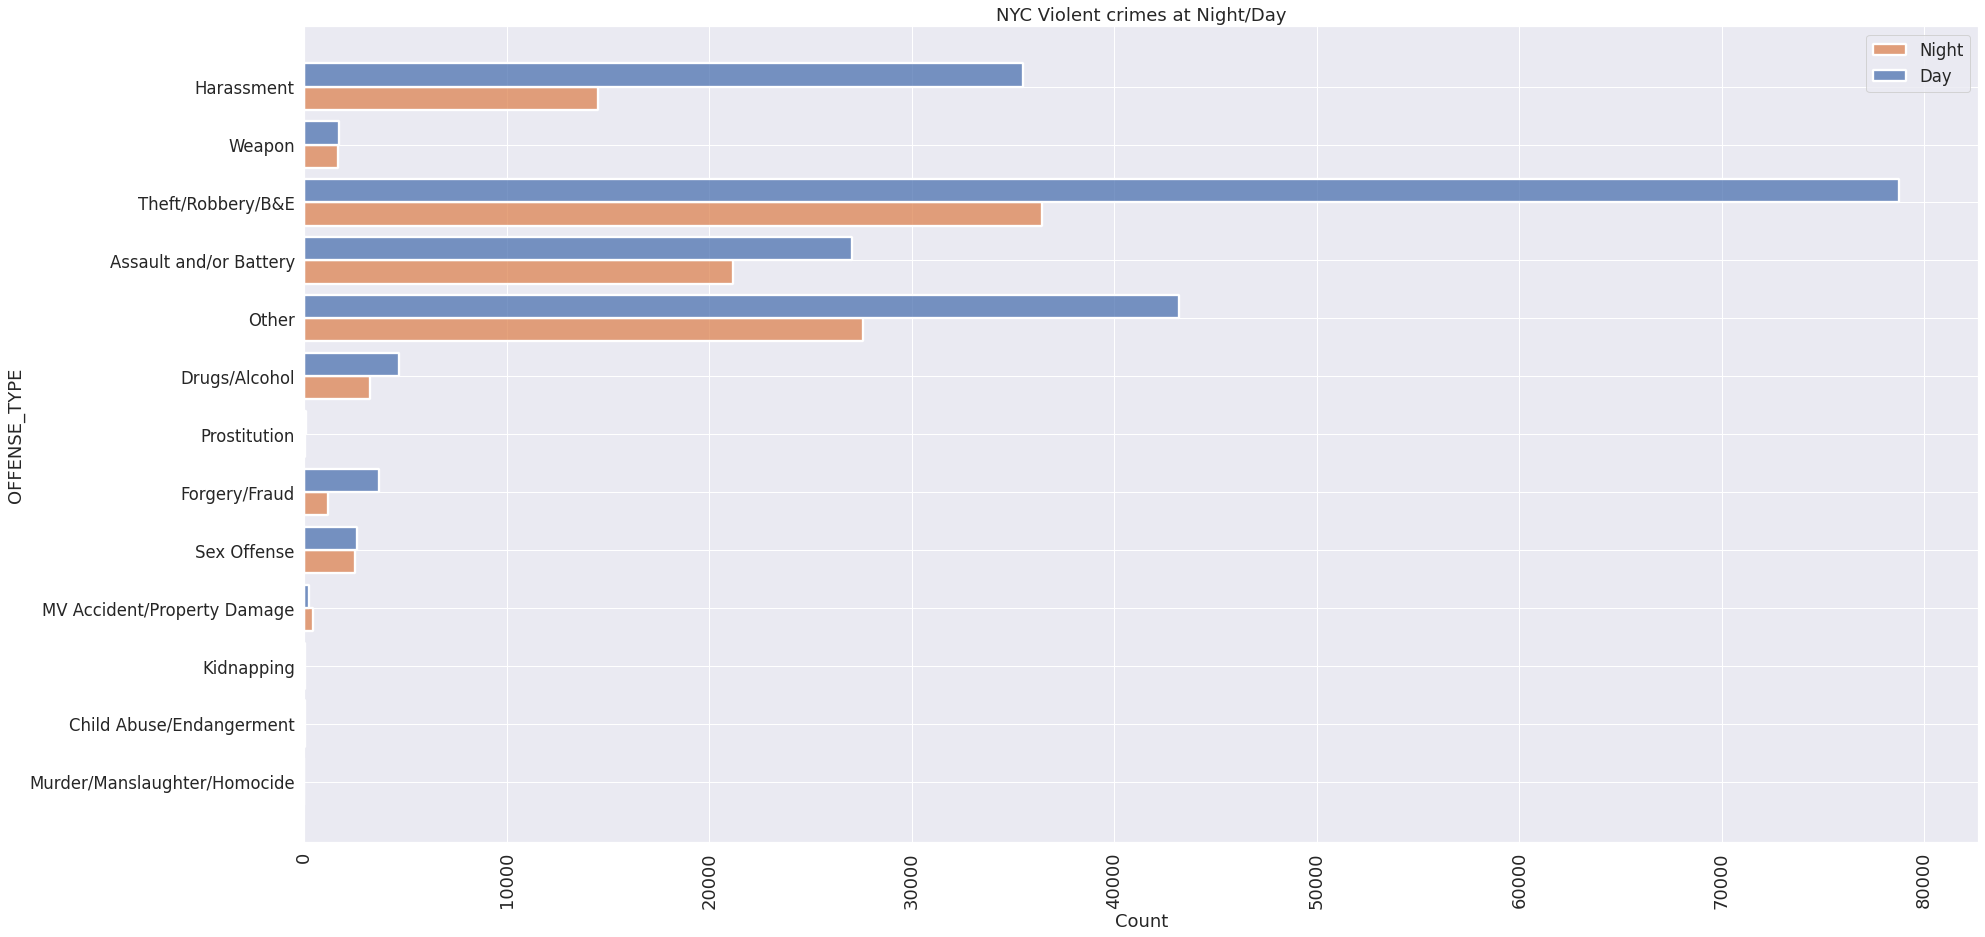

In [15]:
# Offense type for NYC
fig, axs = plt.subplots(1,figsize=(30,15),sharey=False)
g=sns.histplot(new_york_crime_data_df,y='OFFENSE_TYPE', color='y', ax=axs , hue="NIGHT",shrink=.8,multiple="dodge", )
plt.xticks(rotation=90,fontsize=18)
axs.set_title('NYC Violent crimes at Night/Day')
plt.legend(loc='upper right', labels=['Night','Day'])
plt.show()

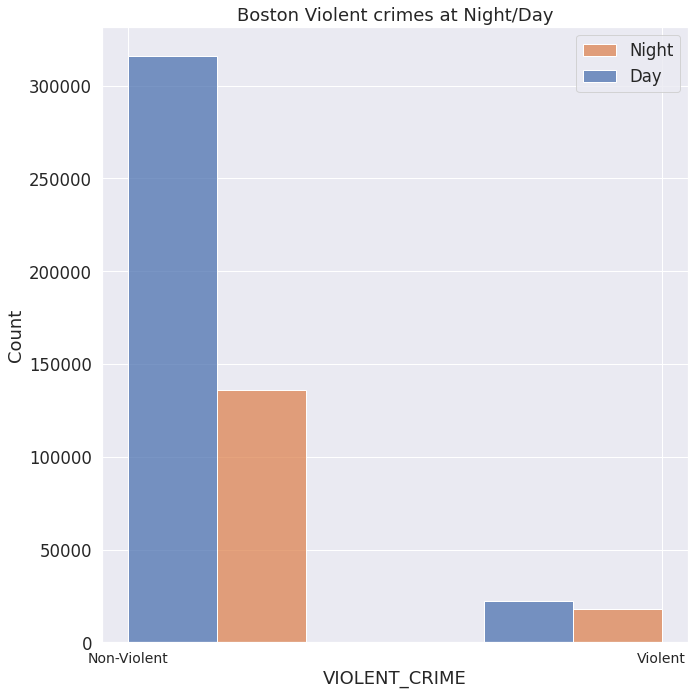

In [16]:
# Offense type for Boston
fig, ax = plt.subplots(1,figsize=(10,10),sharey=False)
sns.histplot(boston_crime_data_df,x='VIOLENT_CRIME', color='y', ax=ax , hue="NIGHT",multiple="dodge",bins=3)
plt.xticks([0,1],['Non-Violent','Violent'],fontsize=14)
ax.set_title('Boston Violent crimes at Night/Day')
plt.legend(loc='upper right', labels=['Night','Day'])
plt.tight_layout()
plt.show()

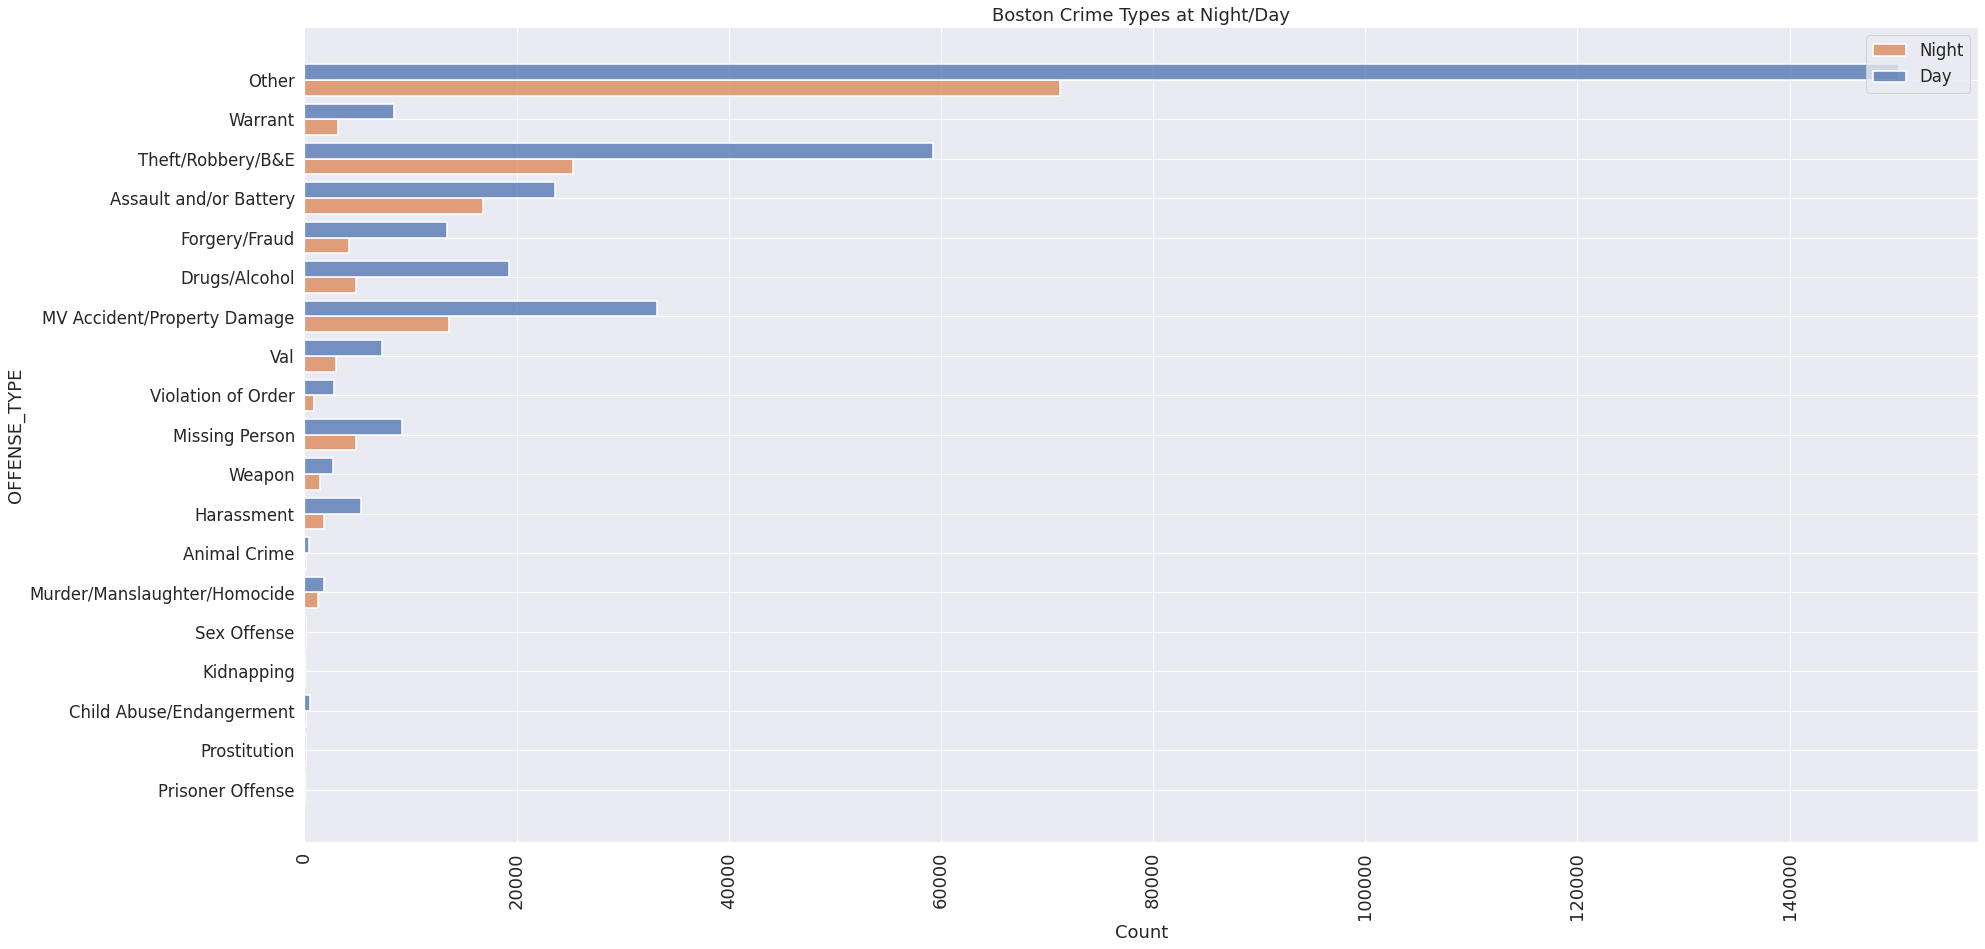

In [17]:
fig, axs = plt.subplots(1,figsize=(30,15),sharey=False)
g=sns.histplot(boston_crime_data_df,y='OFFENSE_TYPE', color='y', ax=axs , hue="NIGHT",shrink=.8,multiple="dodge", )
plt.xticks(rotation=90,fontsize=18)
axs.set_title('Boston Crime Types at Night/Day')
plt.legend(loc='upper right', labels=['Night','Day'])
plt.show()

## **Baseline Models for Predicting Violent Crime**


Here, we create a series of "naive" baseline models that simply predict the most popular indicator value for every observation. One baseline model is created for each of "Boston alone," "New York City alone," and "Boston and New York City." The baseline models are performing very well to start with, so our work is cut out for us.

In [18]:
from sklearn.model_selection import train_test_split
random_state = 109

boston_crime_train, boston_crime_test = train_test_split(boston_crime_data_df, train_size=.8, random_state = random_state)

train_offenses = boston_crime_train['VIOLENT_CRIME'].count()
train_violent_crime = boston_crime_train[boston_crime_train["VIOLENT_CRIME"] == 1]['VIOLENT_CRIME'].sum()
train_proportion_violent = round(train_violent_crime/train_offenses, 3)
train_accuracy = round(1 - train_proportion_violent,3)

test_offenses = boston_crime_test['VIOLENT_CRIME'].count()
test_violent_crime = boston_crime_test[boston_crime_test["VIOLENT_CRIME"] == 1]['VIOLENT_CRIME'].sum()
test_proportion_violent = round(test_violent_crime/test_offenses, 3)
test_accuracy = round(1 - test_proportion_violent,3)

print(f"Proportion of violent crime (Boston): {train_proportion_violent}")
print(f"Naive Model Train Accuracy when classifying all offenses as not violent: {train_accuracy}")
print(f"Naive Model Test Accuracy when classifying all offenses as not violent: {test_accuracy}")


Proportion of violent crime (Boston): 0.082
Naive Model Train Accuracy when classifying all offenses as not violent: 0.918
Naive Model Test Accuracy when classifying all offenses as not violent: 0.918


In [19]:
nyc_crime_train, nyc_crime_test = train_test_split(new_york_crime_data_df, train_size=.8, random_state = random_state)

train_offenses = nyc_crime_train['VIOLENT_CRIME'].count()
train_violent_crime = nyc_crime_train[nyc_crime_train["VIOLENT_CRIME"] == 1]['VIOLENT_CRIME'].sum()
train_proportion_violent = round(train_violent_crime/train_offenses, 3)
train_accuracy = round(1 - train_proportion_violent,3)

test_offenses = nyc_crime_test['VIOLENT_CRIME'].count()
test_violent_crime = nyc_crime_test[nyc_crime_test["VIOLENT_CRIME"] == 1]['VIOLENT_CRIME'].sum()
test_proportion_violent = round(test_violent_crime/test_offenses, 3)
test_accuracy = round(1 - test_proportion_violent,3)

print(f"Proportion of violent crime (NYC) : {train_proportion_violent}")
print(f"Naive Model Train Accuracy when classifying all offenses as not violent: {train_accuracy}")
print(f"Naive Model Test Accuracy when classifying all offenses as not violent: {test_accuracy}")

Proportion of violent crime (NYC) : 0.176
Naive Model Train Accuracy when classifying all offenses as not violent: 0.824
Naive Model Test Accuracy when classifying all offenses as not violent: 0.824


In [20]:
comb_crime_train, comb_crime_test = train_test_split(combined_crime_data_df, train_size=.8, random_state = random_state)
train_offenses = comb_crime_train['VIOLENT_CRIME'].count()
train_violent_crime = comb_crime_train[comb_crime_train["VIOLENT_CRIME"] == 1]['VIOLENT_CRIME'].sum()
train_proportion_violent = round(train_violent_crime/train_offenses, 3)
train_accuracy = round(1 - train_proportion_violent,3)

test_offenses = comb_crime_test['VIOLENT_CRIME'].count()
test_violent_crime = comb_crime_test[comb_crime_test["VIOLENT_CRIME"] == 1]['VIOLENT_CRIME'].sum()
test_proportion_violent = round(test_violent_crime/test_offenses, 3)
test_accuracy = round(1 - test_proportion_violent,3)

print(f"Proportion of violent crime (Combined) : {train_proportion_violent}")
print(f"Naive Model Train Accuracy when classifying all offenses as not violent: {train_accuracy}")
print(f"Naive Model Test Accuracy when classifying all offenses as not violent: {test_accuracy}")

Proportion of violent crime (Combined) : 0.118
Naive Model Train Accuracy when classifying all offenses as not violent: 0.882
Naive Model Test Accuracy when classifying all offenses as not violent: 0.882


# **Violent Crime Prediction/Inference - Boston Data**

Here, we attempt some basic logistic regression models to improve on the baselines. We start with a basic logistic regression model, which doesn't improve too much on the baseline test scores and AUC. So, in the next models, we try tuning the hyperparameters using cross validation, and using regularization to prevent overfitting.

## **Logistic Regression**



In [21]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression

# we'll evaluate for violent crime in Boston using all features (minus the other response variable for Offense Type)
demog_category_columns = ['AREA', 'YEAR', 'MONTH', 'DAY_OF_WEEK', 'HOUR']
train_crime_demog_dummies_df = pd.get_dummies(boston_crime_train.drop(columns=["OFFENSE_TYPE"]), columns=demog_category_columns)
test_crime_demog_dummies_df = pd.get_dummies(boston_crime_test.drop(columns=["OFFENSE_TYPE"]), columns=demog_category_columns)

# select all columns from dummies minus response and Geohash 
x_columns = train_crime_demog_dummies_df.drop(columns=["VIOLENT_CRIME","GEOHASH"]).columns
X_train = train_crime_demog_dummies_df[x_columns]
X_test = test_crime_demog_dummies_df[x_columns]

# normalize the columns
demog_scaler = MinMaxScaler()
demog_scaler.fit(X_train)
x_train_norm = demog_scaler.transform(X_train)
x_test_norm = demog_scaler.transform(X_test)

y_train = train_crime_demog_dummies_df['VIOLENT_CRIME'].values
y_test = test_crime_demog_dummies_df['VIOLENT_CRIME'].values

# attempt a baseline logistic regression without regularization
demog_logit_full = LogisticRegression(penalty='none', max_iter = 10000)
demog_logit_full.fit(x_train_norm,y_train)
demog_logit_full_train_accuracy = round(demog_logit_full.score(x_train_norm, y_train),3)
demog_logit_full_test_accuracy = round(demog_logit_full.score(x_test_norm, y_test),3)


In [22]:
# Print Baseline Logistic Regression Model
b0 = round(demog_logit_full.intercept_[0],3)
#print(f"Logistic Regression Estimated Betas (B0): {b0}")

# Keeping the printed-out values to a specific set, to identify the strongest trends
noted_set = ["MONTH_5", "MONTH_6", "MONTH_7", "DAY_OF_WEEK_Saturday", "AREA_A1", "AREA_B2", "AREA_C6", "LATITUDE", "POLICE_STATION_DISTANCE", "HOSPITAL_DISTANCE"]

for i, k in enumerate(x_columns):
  if k in noted_set:
    print(f"Logistic Regression Estimated Beta {k} (B{i + 1}): { round(demog_logit_full.coef_[0][i],3)}")

print(f"\nLogisitic Train Accuracy: {demog_logit_full_train_accuracy}, Logistic Test Accuracy: {demog_logit_full_test_accuracy}")

# Finding AUC score
y_pred_train_logit_full = demog_logit_full.predict(x_train_norm)
y_pred_test_logit_full = demog_logit_full.predict(x_test_norm)

auc_logit_full_train = roc_auc_score(y_train, y_pred_train_logit_full)
auc_logit_full_test = roc_auc_score(y_test, y_pred_test_logit_full)

print(f"""AUC for baseline logistic regression. 
Train AUC: {auc_logit_full_train}
Test AUC: {auc_logit_full_test}
""")

Logistic Regression Estimated Beta LATITUDE (B1): -0.868
Logistic Regression Estimated Beta POLICE_STATION_DISTANCE (B11): -0.006
Logistic Regression Estimated Beta HOSPITAL_DISTANCE (B12): -0.01
Logistic Regression Estimated Beta AREA_A1 (B18): 0.201
Logistic Regression Estimated Beta AREA_B2 (B21): 0.165
Logistic Regression Estimated Beta AREA_C6 (B24): 0.165
Logistic Regression Estimated Beta MONTH_5 (B40): 0.024
Logistic Regression Estimated Beta MONTH_6 (B41): 0.075
Logistic Regression Estimated Beta MONTH_7 (B42): 0.059
Logistic Regression Estimated Beta DAY_OF_WEEK_Saturday (B50): 0.039

Logisitic Train Accuracy: 0.918, Logistic Test Accuracy: 0.918
AUC for baseline logistic regression. 
Train AUC: 0.5
Test AUC: 0.5



## **Logistic Regression CV w/Ridge Regularization**


In [23]:
from sklearn.linear_model import LogisticRegressionCV
c_list = [1e-3,1e-2,1e-1,1e0,1e1,1e2,1e3]
folds = 3
training_score = []

logit_ridge= LogisticRegressionCV(Cs=c_list, penalty='l2',solver='liblinear', max_iter = 1000, scoring='accuracy',cv=folds)
logit_ridge.fit(x_train_norm, y_train)
logit_ridge_score_train = logit_ridge.score(x_train_norm, y_train)
logit_ridge_score_test = logit_ridge.score(x_test_norm, y_test)


In [24]:
y_pred_logit_ridge_train = logit_ridge.predict(x_train_norm)
y_pred_logit_ridge_test = logit_ridge.predict(x_test_norm)

auc_logit_ridge_train = roc_auc_score(y_train, y_pred_logit_ridge_train)
auc_logit_ridge_test = roc_auc_score(y_test, y_pred_logit_ridge_test)

print(
    "The regularization parameter C chosen by this model: {}\n"
    "Training Accuracy: {:.3f}\n"
    "Test Accuracy: {:.3f}\n"
    "Train AUC: {:.3f}\n"
    "Test AUC: {:.3f}\n"
    .format(logit_ridge.C_[0], logit_ridge_score_train, logit_ridge_score_test, auc_logit_ridge_train, auc_logit_ridge_test)
)

The regularization parameter C chosen by this model: 0.001
Training Accuracy: 0.918
Test Accuracy: 0.918
Train AUC: 0.500
Test AUC: 0.500



In [25]:
for i, k in enumerate(x_columns):
  if k in noted_set:
    print(f"Logistic Regression w/Ridge Estimated Beta {k} (B{i + 1}): { round(logit_ridge.coef_[0][i],3)}")

Logistic Regression w/Ridge Estimated Beta LATITUDE (B1): -0.775
Logistic Regression w/Ridge Estimated Beta POLICE_STATION_DISTANCE (B11): -0.0
Logistic Regression w/Ridge Estimated Beta HOSPITAL_DISTANCE (B12): -0.0
Logistic Regression w/Ridge Estimated Beta AREA_A1 (B18): 0.088
Logistic Regression w/Ridge Estimated Beta AREA_B2 (B21): 0.098
Logistic Regression w/Ridge Estimated Beta AREA_C6 (B24): 0.08
Logistic Regression w/Ridge Estimated Beta MONTH_5 (B40): 0.003
Logistic Regression w/Ridge Estimated Beta MONTH_6 (B41): 0.047
Logistic Regression w/Ridge Estimated Beta MONTH_7 (B42): 0.04
Logistic Regression w/Ridge Estimated Beta DAY_OF_WEEK_Saturday (B50): 0.035


## **Logistic Regression (Balanced Class Weights)**

Since there's an imbalance in terms of which crimes are classified as violent vs. non-violent (violent crimes are only a small fraction of the dataset), we see if balancing class weights helps our logistic regression models. We try a basic model with only balanced weights, then a model with ridge regression and balanced weights. With the latter model, we see a slight increase in AUC, which is a promising sign.

In [26]:
# Balancing weight of the LR
demog_logit_balanced = LogisticRegression(penalty='none', max_iter = 10000, class_weight="balanced")
demog_logit_balanced.fit(x_train_norm,y_train)
demog_logit_balanced_train_accuracy = round(demog_logit_balanced.score(x_train_norm, y_train),3)
demog_logit_balanced_test_accuracy = round(demog_logit_balanced.score(x_test_norm, y_test),3)

In [27]:
b0 = round(demog_logit_balanced.intercept_[0],3)
print(f"Logistic Regression (Balanced) Estimated Betas (B0): {b0}")

for i, k in enumerate(x_columns):
  if k in noted_set:
    print(f"Logistic Regression Estimated Beta {k} (B{i + 1}): { round(demog_logit_balanced.coef_[0][i],3)}")

# AUC calculations
y_pred_train_logit_balanced = logit_ridge.predict(x_train_norm)
y_pred_test_logit_balanced = logit_ridge.predict(x_test_norm)

auc_logit_balanced_train = roc_auc_score(y_train, y_pred_train_logit_balanced)
auc_logit_balanced_test = roc_auc_score(y_test, y_pred_test_logit_balanced)

print(f"\nLogisitic Train Accuracy: {demog_logit_balanced_train_accuracy}, Logistic Test Accuracy: {demog_logit_balanced_test_accuracy}")
print(f"Train AUC: {auc_logit_balanced_train}")
print(f"Test AUC: {auc_logit_balanced_test}")

Logistic Regression (Balanced) Estimated Betas (B0): -0.104
Logistic Regression Estimated Beta LATITUDE (B1): -0.108
Logistic Regression Estimated Beta POLICE_STATION_DISTANCE (B11): -0.001
Logistic Regression Estimated Beta HOSPITAL_DISTANCE (B12): -0.006
Logistic Regression Estimated Beta AREA_A1 (B18): 0.158
Logistic Regression Estimated Beta AREA_B2 (B21): 0.29
Logistic Regression Estimated Beta AREA_C6 (B24): 0.109
Logistic Regression Estimated Beta MONTH_5 (B40): 0.102
Logistic Regression Estimated Beta MONTH_6 (B41): 0.119
Logistic Regression Estimated Beta MONTH_7 (B42): 0.098
Logistic Regression Estimated Beta DAY_OF_WEEK_Saturday (B50): 0.119

Logisitic Train Accuracy: 0.616, Logistic Test Accuracy: 0.617
Train AUC: 0.5
Test AUC: 0.5


## **Logistic Regression CV with Ridge (Balanced Class Weights)**

In [28]:
from sklearn.linear_model import LogisticRegressionCV
c_list = [1e-3,1e-2,1e-1,1e0,1e1,1e2,1e3]
folds = 3
training_score = []

logit_ridge_balanced= LogisticRegressionCV(Cs=c_list, penalty='l2',solver='liblinear', max_iter = 1000, scoring='accuracy', cv=folds, class_weight="balanced")
logit_ridge_balanced.fit(x_train_norm, y_train)
logit_ridge_balanced_score_train = logit_ridge_balanced.score(x_train_norm, y_train)
logit_ridge_balanced_score_test = logit_ridge_balanced.score(x_test_norm, y_test)


In [29]:
# AUC calculations
y_pred_train_logit_ridge_balanced = logit_ridge_balanced.predict(x_train_norm)
y_pred_test_logit_ridge_balanced = logit_ridge_balanced.predict(x_test_norm)

auc_train_logit_ridge_balanced = roc_auc_score(y_train, y_pred_train_logit_ridge_balanced)
auc_test_logit_ridge_balanced = roc_auc_score(y_test, y_pred_test_logit_ridge_balanced)

print(
    "The regularization parameter C chosen by this model: {}\n"
    "Training Accuracy: {:.3f}\n"
    "Test Accuracy: {:.3f}\n"
    "Train AUC: {:.3f}\n"
    "Test AUC: {:.3f}\n"
    .format(logit_ridge_balanced.C_[0], logit_ridge_balanced_score_train, logit_ridge_balanced_score_test, auc_train_logit_ridge_balanced, auc_test_logit_ridge_balanced)
)

The regularization parameter C chosen by this model: 1000.0
Training Accuracy: 0.617
Test Accuracy: 0.617
Train AUC: 0.595
Test AUC: 0.596



In [30]:
for i, k in enumerate(x_columns):
  if k in noted_set:
    print(f"Logistic Regression w/Lasso Balanced Estimated Beta {k} (B{i + 1}): { round(logit_ridge_balanced.coef_[0][i],3)}")

Logistic Regression w/Lasso Balanced Estimated Beta LATITUDE (B1): -83.876
Logistic Regression w/Lasso Balanced Estimated Beta POLICE_STATION_DISTANCE (B11): 62.959
Logistic Regression w/Lasso Balanced Estimated Beta HOSPITAL_DISTANCE (B12): -144.072
Logistic Regression w/Lasso Balanced Estimated Beta AREA_A1 (B18): -0.363
Logistic Regression w/Lasso Balanced Estimated Beta AREA_B2 (B21): 6.815
Logistic Regression w/Lasso Balanced Estimated Beta AREA_C6 (B24): -3.154
Logistic Regression w/Lasso Balanced Estimated Beta MONTH_5 (B40): 3.248
Logistic Regression w/Lasso Balanced Estimated Beta MONTH_6 (B41): 3.264
Logistic Regression w/Lasso Balanced Estimated Beta MONTH_7 (B42): 3.243
Logistic Regression w/Lasso Balanced Estimated Beta DAY_OF_WEEK_Saturday (B50): 5.511


We tried other models (AdaBoost with a decision tree classifier, k-nearest neighbors, and Random Forest), and found that the Random Forest model returned the best results. That model is replicated below.

# **Random Forest**

In [31]:
boston_X = boston_crime_data_df.drop(columns=['OFFENSE_TYPE', 'VIOLENT_CRIME', 'GEOHASH'])
boston_y = boston_crime_data_df['VIOLENT_CRIME']
boston_multi_y = boston_crime_data_df['OFFENSE_TYPE']

random_state = 109

# Create Train/Test splits for Boston
boston_X_train, boston_X_test, boston_y_train, boston_y_test = train_test_split(boston_X, boston_y, train_size=.8, random_state = random_state)

# Train/Test splits for Multi-class
boston_X_train, boston_X_test, boston_multi_y_train, boston_multi_y_test = train_test_split(boston_X, boston_multi_y, train_size=.8, random_state = random_state)

In [32]:
# One-hot encoding for Categoricals
categoricals_boston = ['AREA', 'DAY_OF_WEEK']
categoricals_full = ['DAY_OF_WEEK']

boston_X_train, boston_X_test = pd.get_dummies(boston_X_train, columns=categoricals_boston), pd.get_dummies(boston_X_test, columns=categoricals_boston)

In [33]:
# RANDOM FOREST

# use balanced weights for Boston RF
n_trees = 210
tree_depth = 20

rf_boston_bal = RandomForestClassifier(max_depth=tree_depth, n_estimators=n_trees, max_features='sqrt', class_weight='balanced_subsample', random_state=random_state)
rf_boston_bal.fit(boston_X_train, boston_y_train)

y_pred_train_rf_boston_bal = rf_boston_bal.predict(boston_X_train)
y_pred_test_rf_boston_bal = rf_boston_bal.predict(boston_X_test)

rf_train_score_boston_bal = accuracy_score(boston_y_train, y_pred_train_rf_boston_bal)
rf_test_score_boston_bal = accuracy_score(boston_y_test, y_pred_test_rf_boston_bal)

print(f"""Random Forest (balanced class weights) with {tree_depth} max_depth and {n_trees} trees, 
train accuracy is {rf_train_score_boston_bal:.4f} and
test accuracy is {rf_test_score_boston_bal:.4f}""")

Random Forest (balanced class weights) with 20 max_depth and 210 trees, 
train accuracy is 0.9503 and
test accuracy is 0.8923


**OUR BEST MODEL FOR THIS SECTION**: The logistic model with cross validation appears to be giving the best opportunity to see the impact of our predictors. However there are some notable differences in police and hospital distances that the model doesn’t appear to capture when reviewing against the importances highlighted from the Random Forest model. The Random Forest was the best classifier for prediction in this use case, based on its performance against the baseline, when leveraging all the available predictors.

Now, we look at the AUC score for the Random Forest model, as well as feature importance for interpretability.


In [34]:
# AUC SCORE FOR RANDOM FOREST
y_pred_train_rf_boston_bal = rf_boston_bal.predict(boston_X_train)
y_pred_test_rf_boston_bal = rf_boston_bal.predict(boston_X_test)

auc_rf_boston_bal_train = roc_auc_score(boston_y_train, y_pred_train_rf_boston_bal)
auc_rf_boston_bal_test = roc_auc_score(boston_y_test, y_pred_test_rf_boston_bal)

print(f"""Random Forest (Boston/Violence) with balanced class weights. 
Train AUC: {auc_rf_boston_bal_train}
Test AUC: {auc_rf_boston_bal_test}
""")

Random Forest (Boston/Violence) with balanced class weights. 
Train AUC: 0.8976617096163225
Test AUC: 0.6099445164303456



In [35]:
# helper code to plot feature importances for tree-based models
def plot_importances(model, X, num):
    model_importances = model.feature_importances_
    model_importances = pd.Series(model_importances).fillna(0)
    order = np.flip(np.argsort(model_importances))[0:num]
    plt.barh(range(num),model_importances[order],tick_label=X.columns[order]);
    plt.title(f"Relative Variable Importances for {type(model).__name__}")

One benefit of the random forest model is that we can easily find feature importances, as we do below. Distance-related indicators appear to have the most importance.

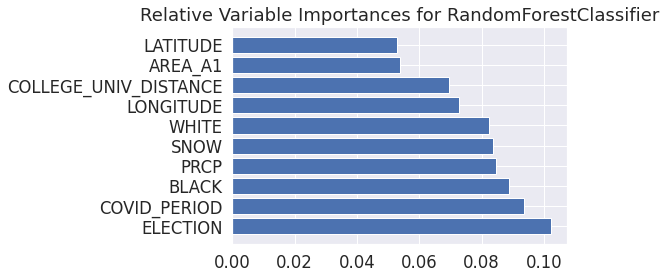

In [36]:
plot_importances(rf_boston_bal, X_train, 10)

##**Principal Component Analysis - Violent Crime Predictor Analysis**

Why can violent/non-violent crime be so difficult to predict? Let's look at our features and see if there's clustering behavior.

In [37]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

ss = StandardScaler().fit(X_train)
Z_train = ss.transform(X_train)
Z_test = ss.transform(X_test)

pca_standard = PCA().fit(Z_train)
pca_Z_train = pca_standard.transform(Z_train)
pca_Z_test = pca_standard.transform(Z_test)

print(f"PCA Training Z Shape{pca_Z_train.shape}")
print(f"PCA Test Z Shape{pca_Z_test.shape}")

PCA Training Z Shape(393416, 78)
PCA Test Z Shape(98355, 78)


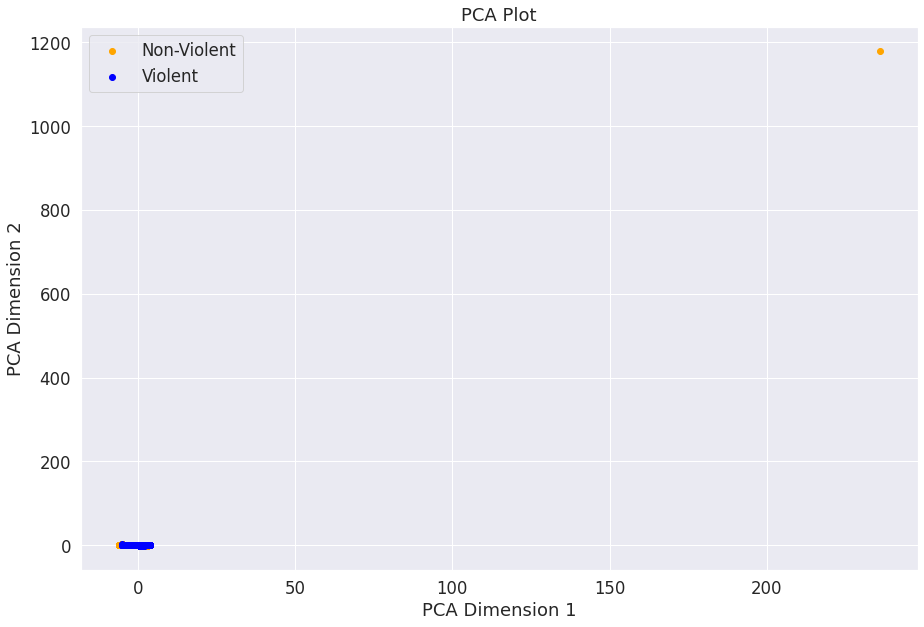

In [38]:
colors = ['orange','blue']
label_text = ["Non-Violent", "Violent"]

fig, ax = plt.subplots(figsize=(15,10))

for violence_level in [0,1]:
    cur_df = pca_Z_train[y_train==violence_level]
    ax =plt.scatter(cur_df[:,0], cur_df[:,1], c = colors[violence_level], label=label_text[violence_level])

plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.title("PCA Plot")
plt.legend();

There appears to be one outlier in the data, that causes everything else to be in one large cluster. Let's remove it and see what effect that has.

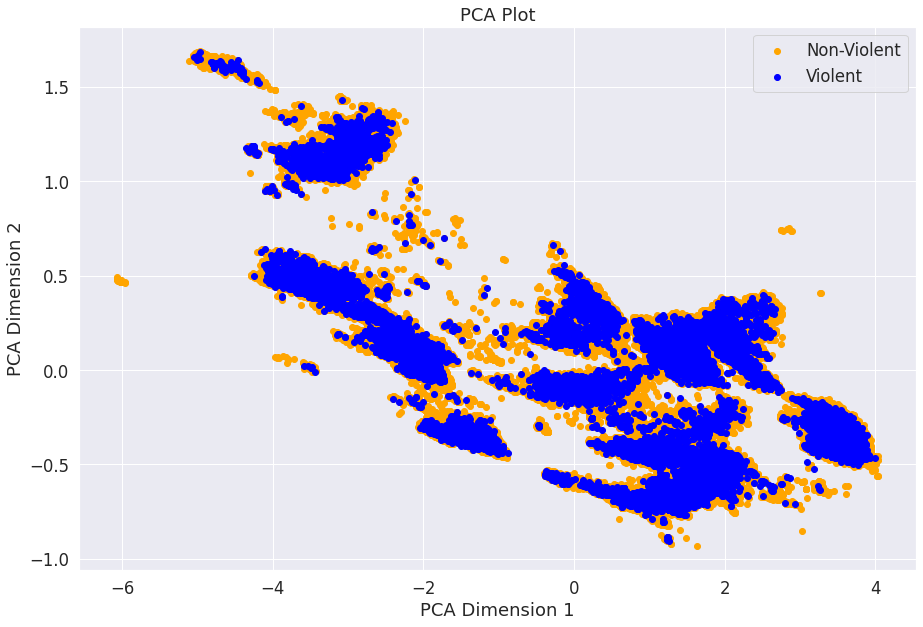

In [39]:
#Remove apparent outlier in data and plot again
outlier_filter = (pca_Z_train[:,0] < 50) & (pca_Z_train[:,1]  < 50)
pca_Z_train_filter = pca_Z_train[outlier_filter]
y_train_filter = y_train[outlier_filter]

colors = ['orange','blue']
label_text = ["Non-Violent", "Violent"]

fig, ax = plt.subplots(figsize=(15,10))

for violence_level in [0,1]:
    cur_df = pca_Z_train_filter[y_train_filter==violence_level]
    ax =plt.scatter(cur_df[:,0], cur_df[:,1], c = colors[violence_level], label=label_text[violence_level])

plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.title("PCA Plot")
plt.legend();



Significant overlap in data classification helps to explain why it's difficult for our models to beat the baseline.

# **Violent Crime Modeling - Combined Data (Boston/New York City)**

We now try logistic regression on the combined Boston/NYC dataset to see if the same problems persist. We try the same set of Logistic Regression models as in the Boston-only case.

## **Logistic Regression**


In [40]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression

# we'll now evaluate for violent crime in using both cities using all features (minus the other response variable for Offense Type)
demog_category_columns = ['YEAR', 'MONTH', 'DAY_OF_WEEK', 'HOUR']
train_crime_demog_dummies_df = pd.get_dummies(comb_crime_train.drop(columns=["OFFENSE_TYPE"]), columns=demog_category_columns)
test_crime_demog_dummies_df = pd.get_dummies(comb_crime_test.drop(columns=["OFFENSE_TYPE"]), columns=demog_category_columns)

# select all columns from dummies minus response, Geohash, Latitude, Longitude 
x_columns = train_crime_demog_dummies_df.drop(columns=["VIOLENT_CRIME","GEOHASH","LATITUDE","LONGITUDE","AREA"]).columns

X_train = train_crime_demog_dummies_df[x_columns]
X_test = test_crime_demog_dummies_df[x_columns]

demog_scaler = MinMaxScaler()
demog_scaler.fit(X_train)
x_train_norm = demog_scaler.transform(X_train)
x_test_norm = demog_scaler.transform(X_test)

y_train = train_crime_demog_dummies_df['VIOLENT_CRIME'].values
y_test = test_crime_demog_dummies_df['VIOLENT_CRIME'].values

# attempt a baseline logistic regression without regularization
demog_logit_full = LogisticRegression(penalty='none', max_iter = 10000)
demog_logit_full.fit(x_train_norm,y_train)
demog_logit_full_train_accuracy = round(demog_logit_full.score(x_train_norm, y_train),3)
demog_logit_full_test_accuracy = round(demog_logit_full.score(x_test_norm, y_test),3)

In [41]:
b0 = round(demog_logit_full.intercept_[0],3)
print(f"Logistic Regression Estimated Betas (B0): {b0}")

for i, k in enumerate(x_columns):
  if k in noted_set:
    print(f"Logistic Regression Estimated Beta {k} (B{i + 1}): { round(demog_logit_full.coef_[0][i],3)}")

print(f"\nLogisitic Train Accuracy: {demog_logit_full_train_accuracy}, Logistic Test Accuracy: {demog_logit_full_test_accuracy}")

# AUC SCORE FOR DEMOG LOGIT FULL
y_pred_test_logit_full = demog_logit_full.predict(x_test_norm)

auc_rf_logit_full = roc_auc_score(y_test, y_pred_test_logit_full)

print(f"""Random Forest (Boston/Violence) with balanced class weights. 
AUC: {auc_rf_logit_full}
""")

Logistic Regression Estimated Betas (B0): -17.948
Logistic Regression Estimated Beta POLICE_STATION_DISTANCE (B9): -6.407
Logistic Regression Estimated Beta HOSPITAL_DISTANCE (B10): -5.916
Logistic Regression Estimated Beta MONTH_5 (B26): -1.431
Logistic Regression Estimated Beta MONTH_6 (B27): -1.334
Logistic Regression Estimated Beta MONTH_7 (B28): -1.369
Logistic Regression Estimated Beta DAY_OF_WEEK_Saturday (B36): -2.42

Logisitic Train Accuracy: 0.882, Logistic Test Accuracy: 0.882
Random Forest (Boston/Violence) with balanced class weights. 
AUC: 0.5



## **Logistic Regression CV with Ridge Regularization**



In [42]:
from sklearn.linear_model import LogisticRegressionCV
c_list = [1e-3,1e-2,1e-1,1e0,1e1,1e2,1e3]
folds = 3
training_score = []

logit_ridge= LogisticRegressionCV(Cs=c_list, penalty='l2',solver='liblinear', max_iter = 1000, scoring='accuracy',cv=folds)
logit_ridge.fit(x_train_norm, y_train)
logit_ridge_score_train = logit_ridge.score(x_train_norm, y_train)
logit_ridge_score_test = logit_ridge.score(x_test_norm, y_test)

In [43]:
# AUC SCORE FOR DEMOG LOGIT FULL
y_pred_train_logit_ridge = logit_ridge.predict(x_train_norm)
y_pred_test_logit_ridge = logit_ridge.predict(x_test_norm)

auc_rf_logit_full_train = roc_auc_score(y_train, y_pred_train_logit_ridge)
auc_rf_logit_full_test = roc_auc_score(y_test, y_pred_test_logit_ridge)

print(
    "The regularization parameter C chosen by this model: {}\n"
    "Training Accuracy: {:.3f}\n"
    "Test Accuracy: {:.3f}\n"
    "Train AUC: {:.3f}\n"
    "Test AUC: {:.3f}\n"
    .format(logit_ridge.C_[0], logit_ridge_score_train, logit_ridge_score_test, auc_rf_logit_full_train, auc_rf_logit_full_test)
)

The regularization parameter C chosen by this model: 0.001
Training Accuracy: 0.882
Test Accuracy: 0.882
Train AUC: 0.500
Test AUC: 0.500



In [44]:
for i, k in enumerate(x_columns):
  if k in noted_set:
    print(f"Logistic Regression w/Ridge Estimated Beta {k} (B{i + 1}): { round(logit_ridge.coef_[0][i],3)}")

Logistic Regression w/Ridge Estimated Beta POLICE_STATION_DISTANCE (B9): -0.001
Logistic Regression w/Ridge Estimated Beta HOSPITAL_DISTANCE (B10): -0.001
Logistic Regression w/Ridge Estimated Beta MONTH_5 (B26): -0.05
Logistic Regression w/Ridge Estimated Beta MONTH_6 (B27): 0.033
Logistic Regression w/Ridge Estimated Beta MONTH_7 (B28): 0.004
Logistic Regression w/Ridge Estimated Beta DAY_OF_WEEK_Saturday (B36): -0.038


## **Logistic Regression (Balanced Class Weight)**

In [45]:
# Balancing weight of the LR
demog_logit_balanced = LogisticRegression(penalty='none', max_iter = 10000, class_weight="balanced")
demog_logit_balanced.fit(x_train_norm,y_train)
demog_logit_balanced_train_accuracy = round(demog_logit_balanced.score(x_train_norm, y_train),3)
demog_logit_balanced_test_accuracy = round(demog_logit_balanced.score(x_test_norm, y_test),3)

In [48]:
b0 = round(demog_logit_balanced.intercept_[0],3)
print(f"Logistic Regression Estimated Betas (B0): {b0}")

for i, k in enumerate(x_columns):
  if k in noted_set:
    print(f"Logistic Regression Estimated Beta {k} (B{i + 1}): { round(demog_logit_balanced.coef_[0][i],3)}")

print(f"\nLogisitic Train Accuracy: {demog_logit_balanced_train_accuracy}, Logistic Test Accuracy: {demog_logit_balanced_test_accuracy}")

# AUC SCORE FOR DEMOG LOGIT FULL
y_pred_train_logit_balanced = demog_logit_balanced.predict(x_train_norm)
y_pred_test_logit_balanced = demog_logit_balanced.predict(x_test_norm)

auc_rf_logit_balanced_train = roc_auc_score(y_train, y_pred_train_logit_balanced)
auc_rf_logit_balanced_test = roc_auc_score(y_test, y_pred_test_logit_balanced)

print(f"""Random Forest (Boston/Violence) with balanced class weights. 
Train AUC: {auc_rf_logit_balanced_train}
Test AUC: {auc_rf_logit_balanced_test}
""")

Logistic Regression Estimated Betas (B0): -13.609
Logistic Regression Estimated Beta POLICE_STATION_DISTANCE (B9): -1011.925
Logistic Regression Estimated Beta HOSPITAL_DISTANCE (B10): -957.858
Logistic Regression Estimated Beta MONTH_5 (B26): -1.053
Logistic Regression Estimated Beta MONTH_6 (B27): -0.979
Logistic Regression Estimated Beta MONTH_7 (B28): -1.021
Logistic Regression Estimated Beta DAY_OF_WEEK_Saturday (B36): -1.816

Logisitic Train Accuracy: 0.625, Logistic Test Accuracy: 0.622
Random Forest (Boston/Violence) with balanced class weights. 
Train AUC: 0.6241738431901532
Test AUC: 0.6227403639600844



Again, as in the Boston-only set, we try a random forest model as well, since we aim to see which predictors out of the large number of indicators are relevant.

#  **Random Forest (COMBINED SET)**

In [49]:
%%time
#Full Random Forest

n_trees = 210
tree_depth = 20

rf_full = RandomForestClassifier(max_depth=tree_depth, n_estimators=n_trees, max_features='sqrt', random_state=51)
rf_full.fit(X_train, y_train)

y_pred_train_rf_full = rf_full.predict(X_train)
y_pred_test_rf_full = rf_full.predict(X_test)

rf_train_score_full = accuracy_score(y_train, y_pred_train_rf_full)
rf_test_score_full = accuracy_score(y_test, y_pred_test_rf_full)

print(f"""Random Forest with {tree_depth} max_depth and {n_trees} trees, 
train accuracy is {rf_train_score_full:.3f} and
test accuracy is {rf_test_score_full:.3f}""")

Random Forest with 20 max_depth and 210 trees, 
train accuracy is 0.896 and
test accuracy is 0.894
CPU times: user 6min 57s, sys: 668 ms, total: 6min 58s
Wall time: 6min 58s


In [50]:
# AUC SCORE
auc_rf_full_train = roc_auc_score(y_train, y_pred_train_rf_full)
auc_rf_full_test = roc_auc_score(y_test, y_pred_test_rf_full)

print(f"""Random Forest AUCs (Generalized/Violence) 
Train: {auc_rf_full_train:.4f}
Test: {auc_rf_full_test:.4f}
""")

Random Forest AUCs (Generalized/Violence) 
Train: 0.5578
Test: 0.5505



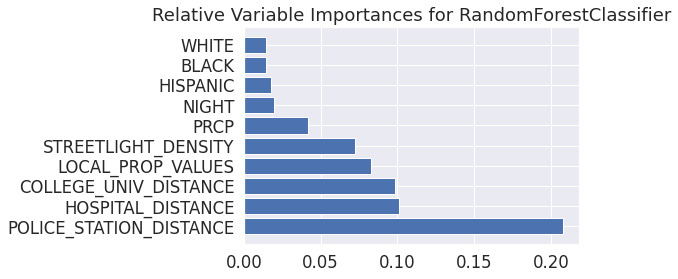

In [51]:
# Feature Importance
plot_importances(rf_full, X_train, 10)

##**Principal Component Analysis - Combined Data Predictor Analysis**

Again, as in the Boston-only case, we look at the features to see if there's clustering behavior.

In [52]:
ss = StandardScaler().fit(X_train)
Z_train = ss.transform(X_train)
Z_test = ss.transform(X_test)

pca_standard = PCA().fit(Z_train)
pca_Z_train = pca_standard.transform(Z_train)
pca_Z_test = pca_standard.transform(Z_test)

print(f"PCA Training Z Shape{pca_Z_train.shape}")
print(f"PCA Test Z Shape{pca_Z_test.shape}")

PCA Training Z Shape(638447, 64)
PCA Test Z Shape(159612, 64)


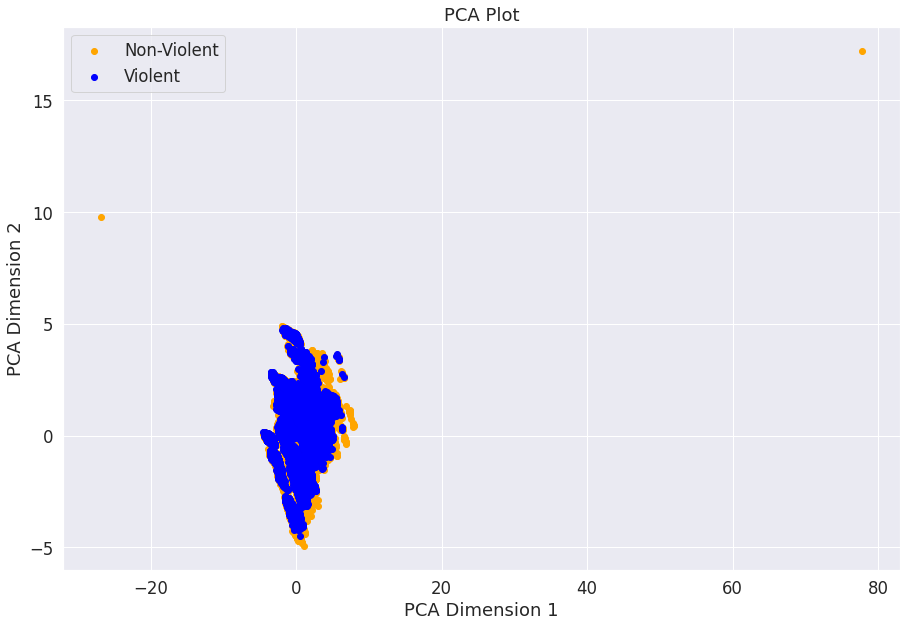

In [53]:
colors = ['orange','blue']
label_text = ["Non-Violent", "Violent"]

fig, ax = plt.subplots(figsize=(15,10))

for violence_level in [0,1]:
    cur_df = pca_Z_train[y_train==violence_level]
    ax =plt.scatter(cur_df[:,0], cur_df[:,1], c = colors[violence_level], label=label_text[violence_level])

plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.title("PCA Plot")
plt.legend();

Similarly to last time, there appear to be some outliers that are clustering the rest of the observations. Let's remove those and restart the PCA.

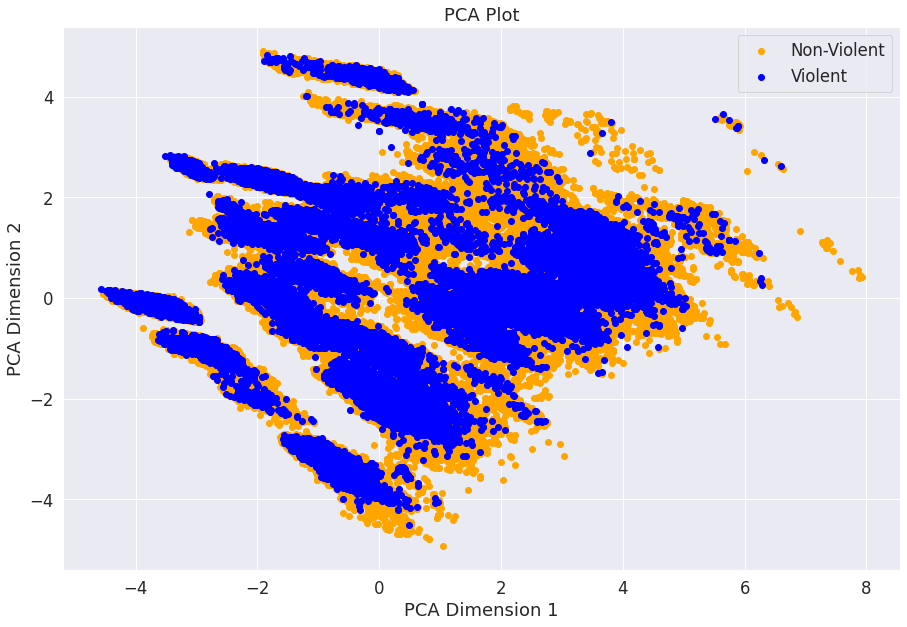

In [54]:
outlier_filter = (pca_Z_train[:,0] > -20) & (pca_Z_train[:,0]  < 60)
pca_Z_train_filter = pca_Z_train[outlier_filter]
y_train_filter = y_train[outlier_filter]

colors = ['orange','blue']
label_text = ["Non-Violent", "Violent"]

fig, ax = plt.subplots(figsize=(15,10))

for violence_level in [0,1]:
    cur_df = pca_Z_train_filter[y_train_filter==violence_level]
    ax =plt.scatter(cur_df[:,0], cur_df[:,1], c = colors[violence_level], label=label_text[violence_level])

plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.title("PCA Plot")
plt.legend();


Combined dataset also exhibits overlap as in the boston dataset. There are some areas of clearer distinction but still appears challenging to predict

**OUR BEST MODEL FOR THIS SECTION**: As in the Boston-only case, the Logistic Regression appears to be best for interpretability, while Random Forest continues to return the best AUC score.

#**Offense Type Prediction - Boston Data**

Here, we go from a binary response variable to a response variable with 19 different classes. We make a few adjustments accordingly, but the methodology remains about the same: create a baseline model, then try basic logistic regression and random forest models. While the logistic regression model didn't deliver much-improved results on the baseline, it still gives some insight as to the coefficients for offense type.

# Baseline model

In [56]:
# Offense Type
# we'll predict Offense Types in Boston using all features (minus the other response variable for Offense Type)
demog_category_columns = ['AREA', 'YEAR', 'MONTH', 'DAY_OF_WEEK', 'HOUR']
train_crime_demog_dummies_df = pd.get_dummies(boston_crime_train.drop(columns=["OFFENSE_TYPE","VIOLENT_CRIME","GEOHASH"]), columns=demog_category_columns)
test_crime_demog_dummies_df = pd.get_dummies(boston_crime_test.drop(columns=["OFFENSE_TYPE","VIOLENT_CRIME","GEOHASH"]), columns=demog_category_columns)

# select all columns from dummies minus response and Geohash 
x_columns = train_crime_demog_dummies_df.columns

X_train = train_crime_demog_dummies_df[x_columns]
X_test = test_crime_demog_dummies_df[x_columns]

demog_scaler = MinMaxScaler()
demog_scaler.fit(X_train)
x_train_norm = demog_scaler.transform(X_train)
x_test_norm = demog_scaler.transform(X_test)

y_train = boston_crime_train['OFFENSE_TYPE'].astype('category').cat.codes
y_test = boston_crime_test['OFFENSE_TYPE'].astype('category').cat.codes


In [57]:
# Creating a naive model that predicts the same, most popular, class for every observation
# Baseline model; predict whatever the most popular offense type is
baseline_class = y_train.value_counts().idxmax()
baseline_train_accuracy = len(y_train.loc[y_train == baseline_class]) / len(y_train)
baseline_test_accuracy = len(y_test.loc[y_test == baseline_class]) / len(y_test)

# Baseline accuracy when we have the most basic of models
print(f"Baseline train accuracy: {baseline_train_accuracy:.4f}")
print(f"Baseline test accuracy: {baseline_test_accuracy:.4f}")

Baseline train accuracy: 0.4505
Baseline test accuracy: 0.4506


## **Logistic Regression**


In [58]:
# attempt a baseline logistic regression without regularization
demog_logit_full = LogisticRegression(penalty='none', max_iter = 10000)
demog_logit_full.fit(x_train_norm,y_train)
demog_logit_full_train_accuracy = round(demog_logit_full.score(x_train_norm, y_train),3)
demog_logit_full_test_accuracy = round(demog_logit_full.score(x_test_norm, y_test),3)

In [59]:
print(f"\nLogisitic Train Accuracy: {demog_logit_full_train_accuracy}, Logistic Test Accuracy: {demog_logit_full_test_accuracy}")


Logisitic Train Accuracy: 0.451, Logistic Test Accuracy: 0.451


In [60]:
# AUC SCORE FOR DEMOG LOGIT FULL
predict_proba_train = demog_logit_full.predict_proba(x_train_norm)
y_pred_train_logit_type_boston = np.apply_along_axis(np.argmax, 1, predict_proba_train)

predict_proba_test = demog_logit_full.predict_proba(x_test_norm)
y_pred_test_logit_type_boston = np.apply_along_axis(np.argmax, 1, predict_proba_test)


In [61]:
from sklearn.preprocessing import label_binarize

# binarizing to get AUC score
labels = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]

y_train_bin = label_binarize(y_train, classes=labels)
y_pred_train_bin = label_binarize(y_pred_train_logit_type_boston, classes=labels)

auc_rf_logit_full_train = roc_auc_score(y_train_bin, y_pred_train_bin, average='macro', multi_class='ovo')

print(f"""Logistic Regression (Boston/Type) with balanced class weights. 
Train AUC: {auc_rf_logit_full_train}
""")

y_test_bin = label_binarize(y_test, classes=labels)
y_pred_test_bin = label_binarize(y_pred_test_logit_type_boston, classes=labels)

auc_rf_logit_full_test = roc_auc_score(y_test_bin, y_pred_test_bin, average='macro', multi_class='ovo')

print(f"""Logistic Regression (Boston/Type) with balanced class weights. 
Test AUC: {auc_rf_logit_full_test}
""")

Logistic Regression (Boston/Type) with balanced class weights. 
Train AUC: 0.500614821675704

Logistic Regression (Boston/Type) with balanced class weights. 
Test AUC: 0.5006588182065008



With the multiclass logistic regression model, we can look at the coefficients for each predicted value for any feature. From here, we can see some interesting trends; for example, for crimes during the COVID era, instances of crime like Assault and Battery, Robbery, and Fraud/Forgery show an increased log likelihood. We can similarly observe trends for factors like income, weather, and streetlight density. 

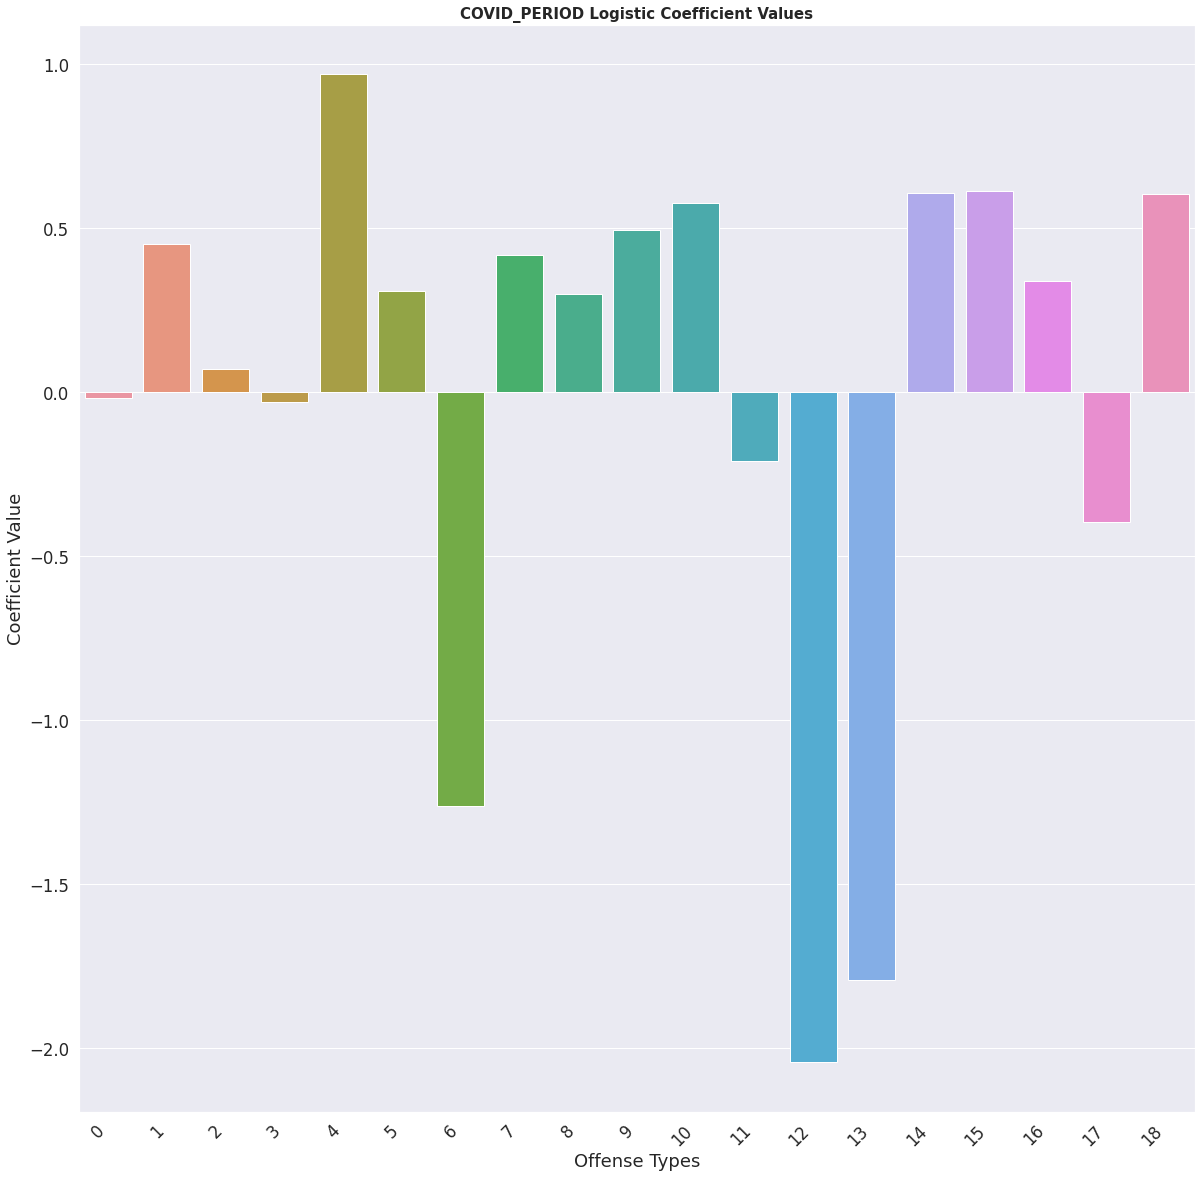

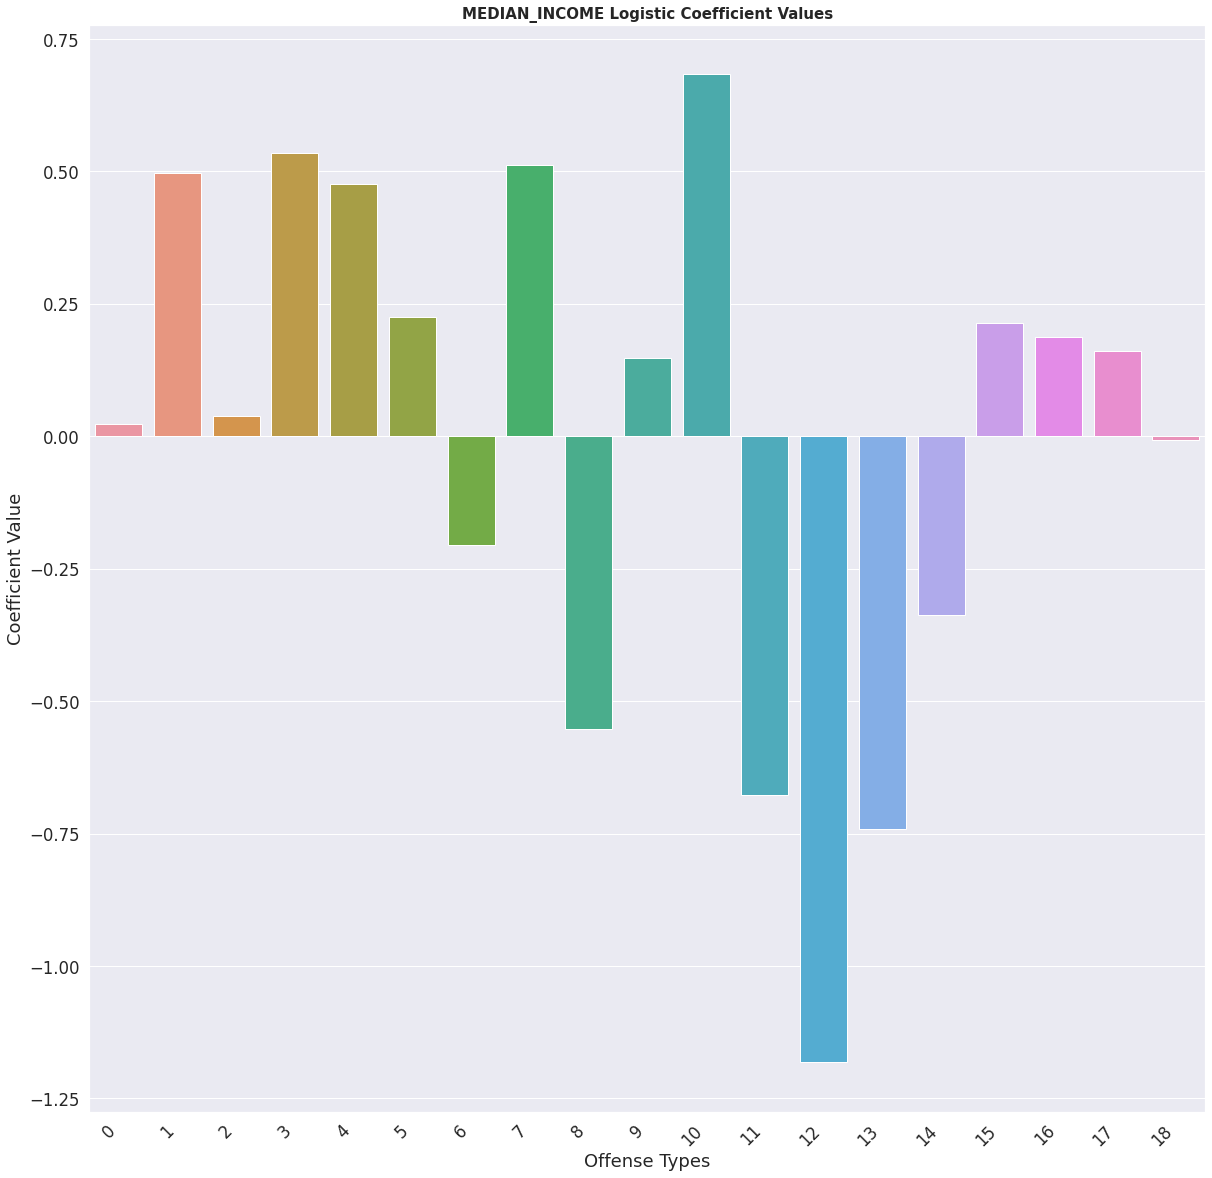

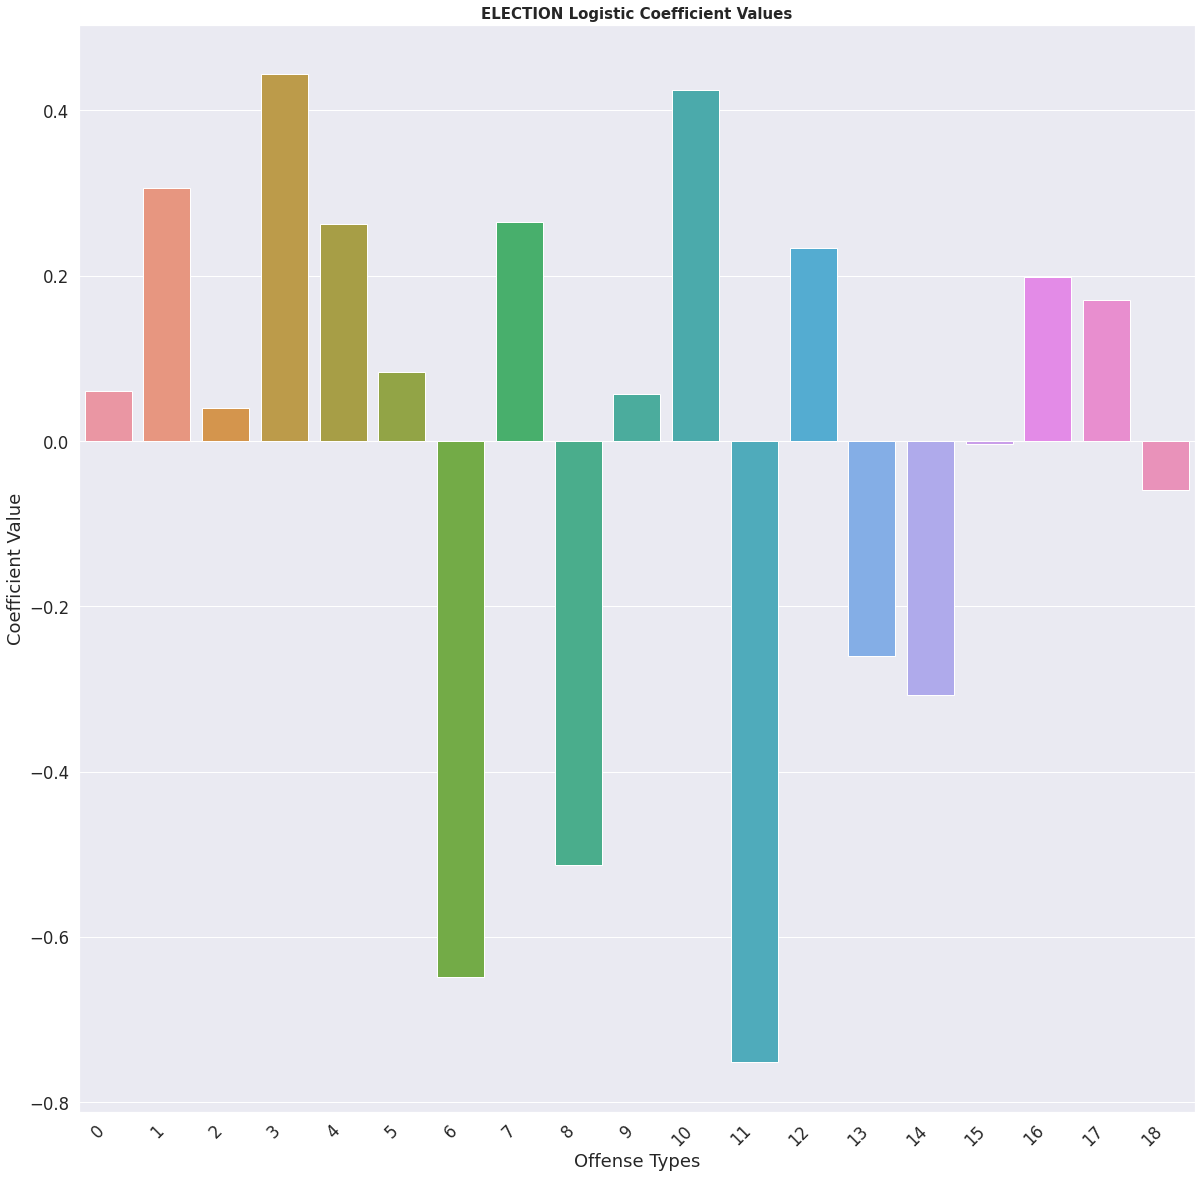

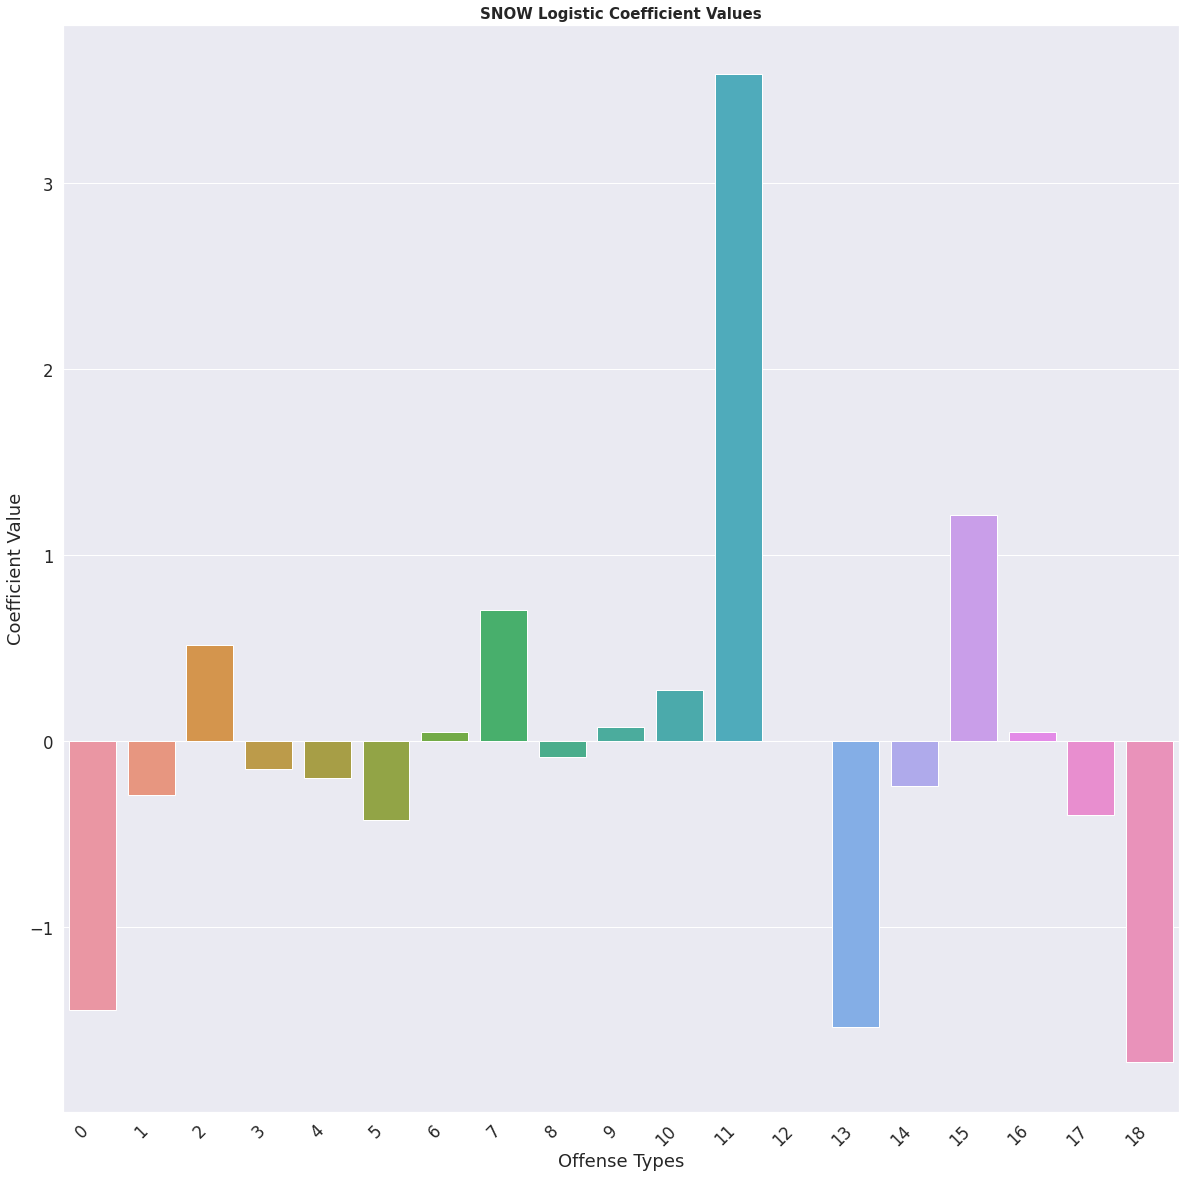

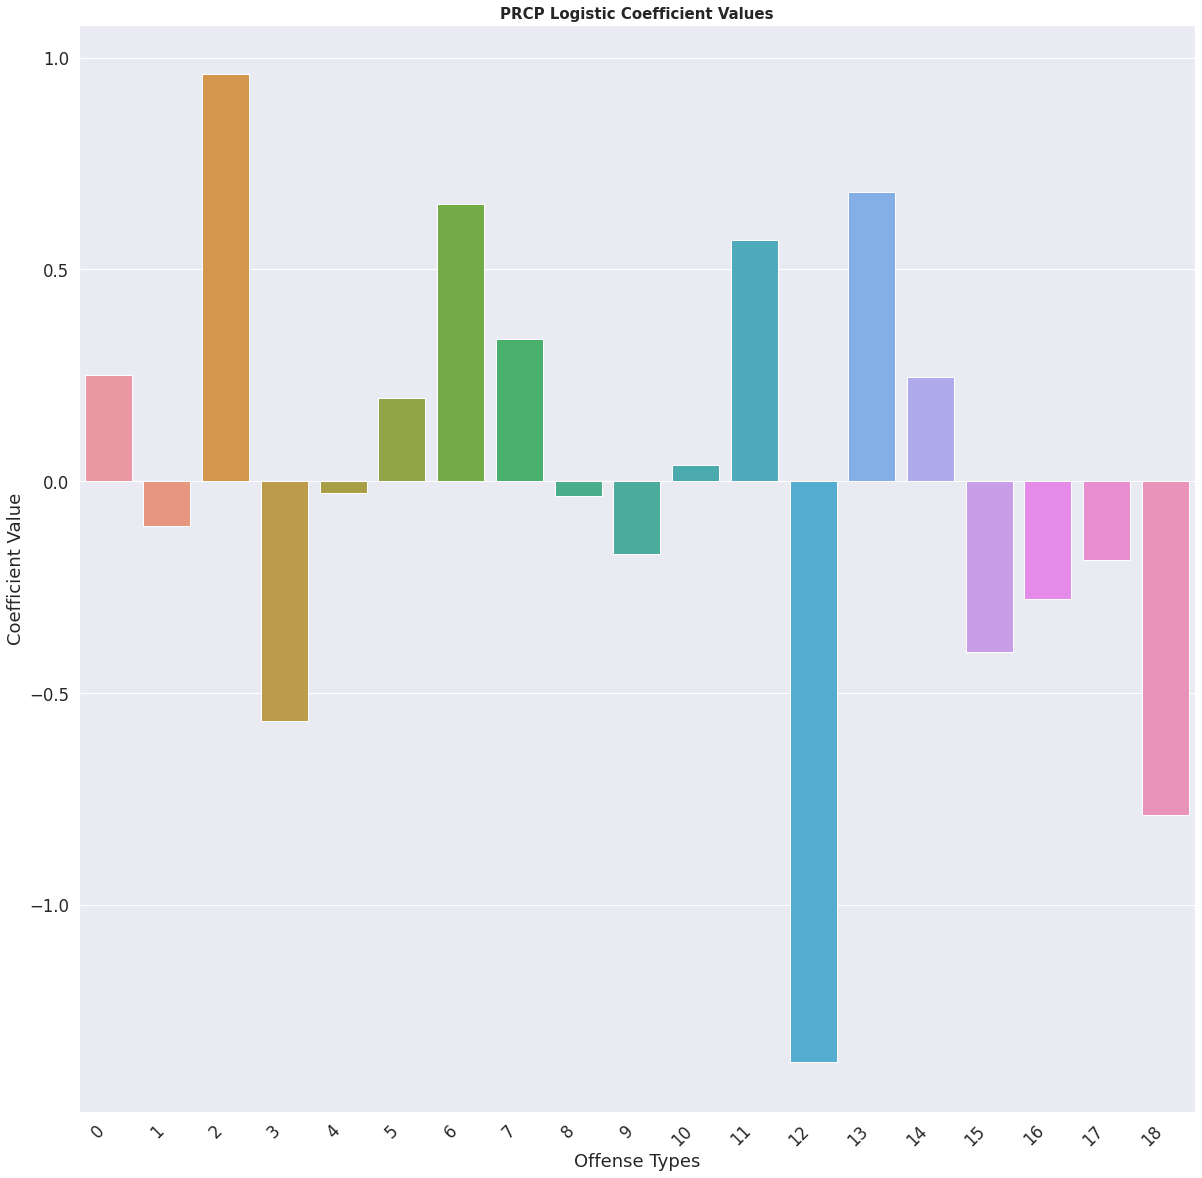

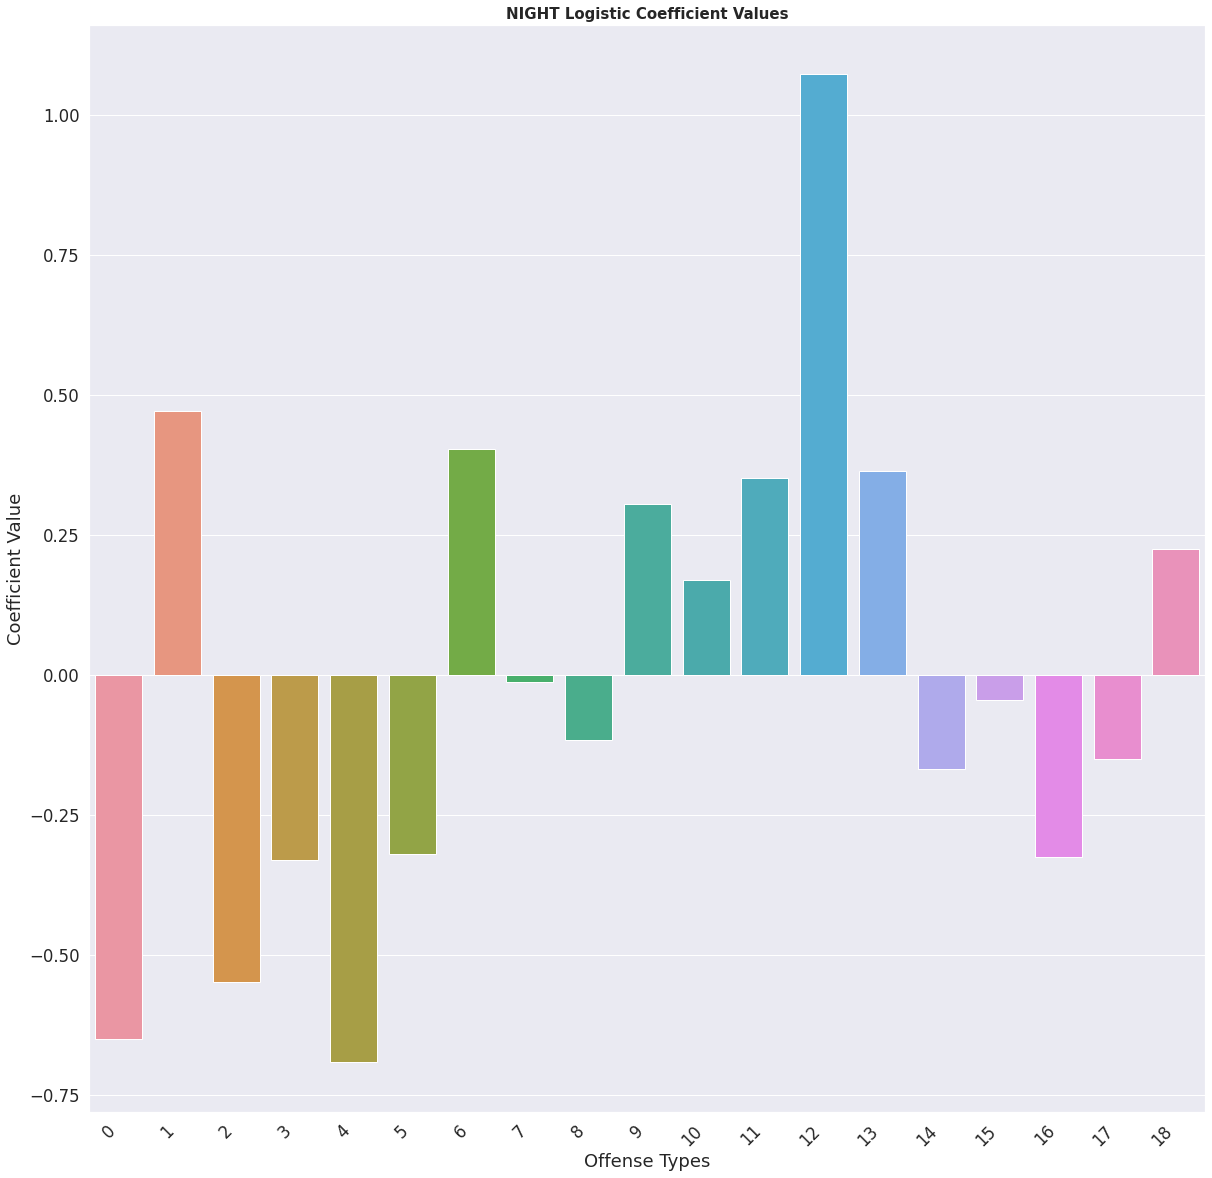

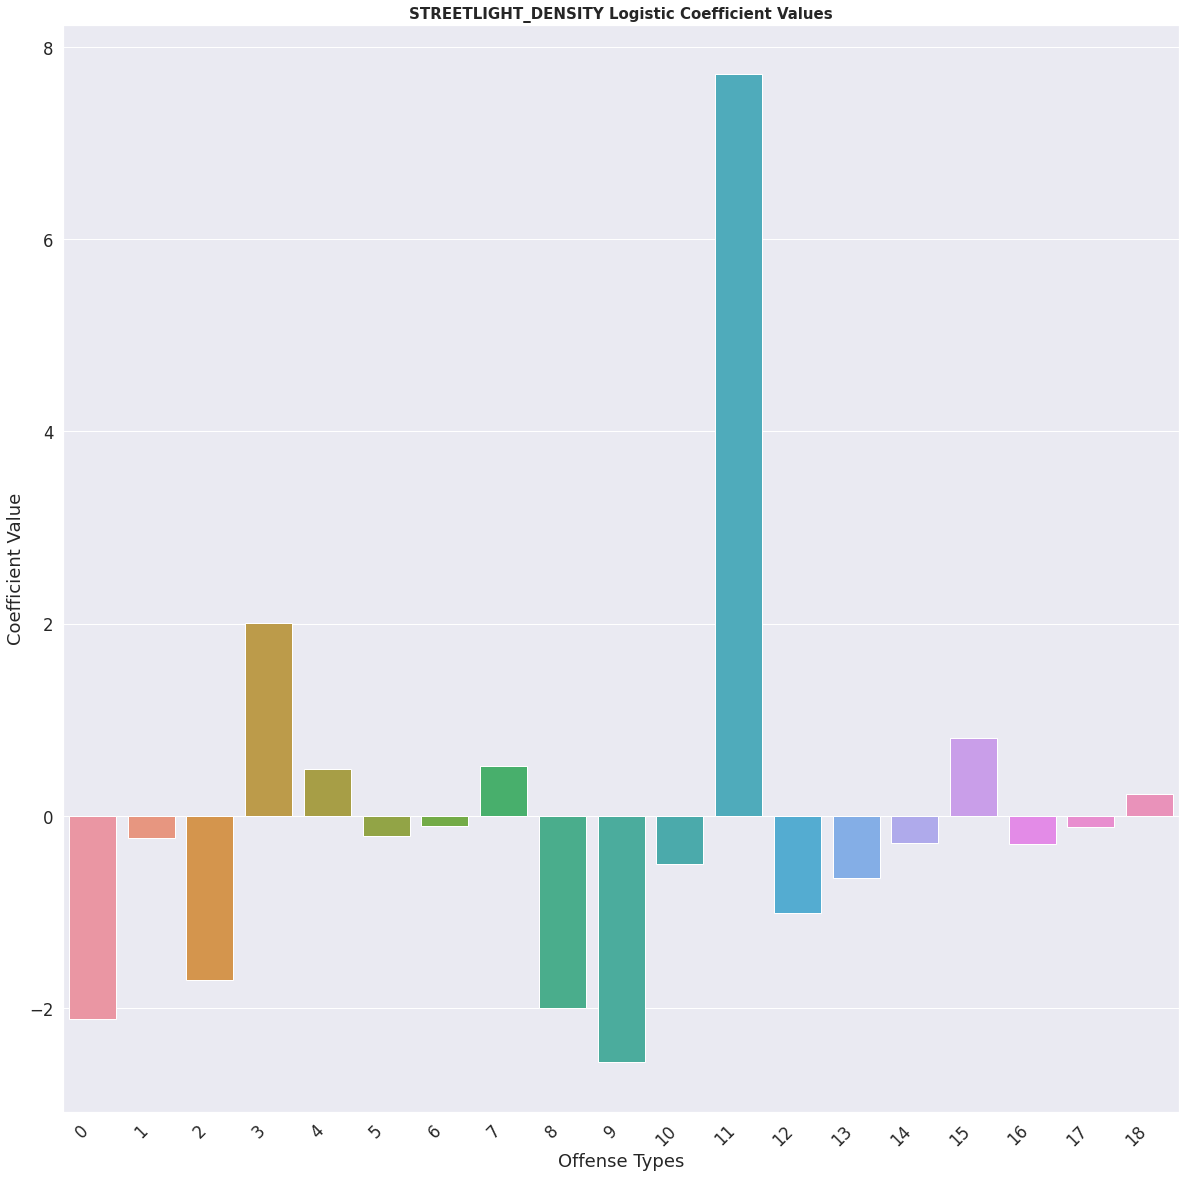

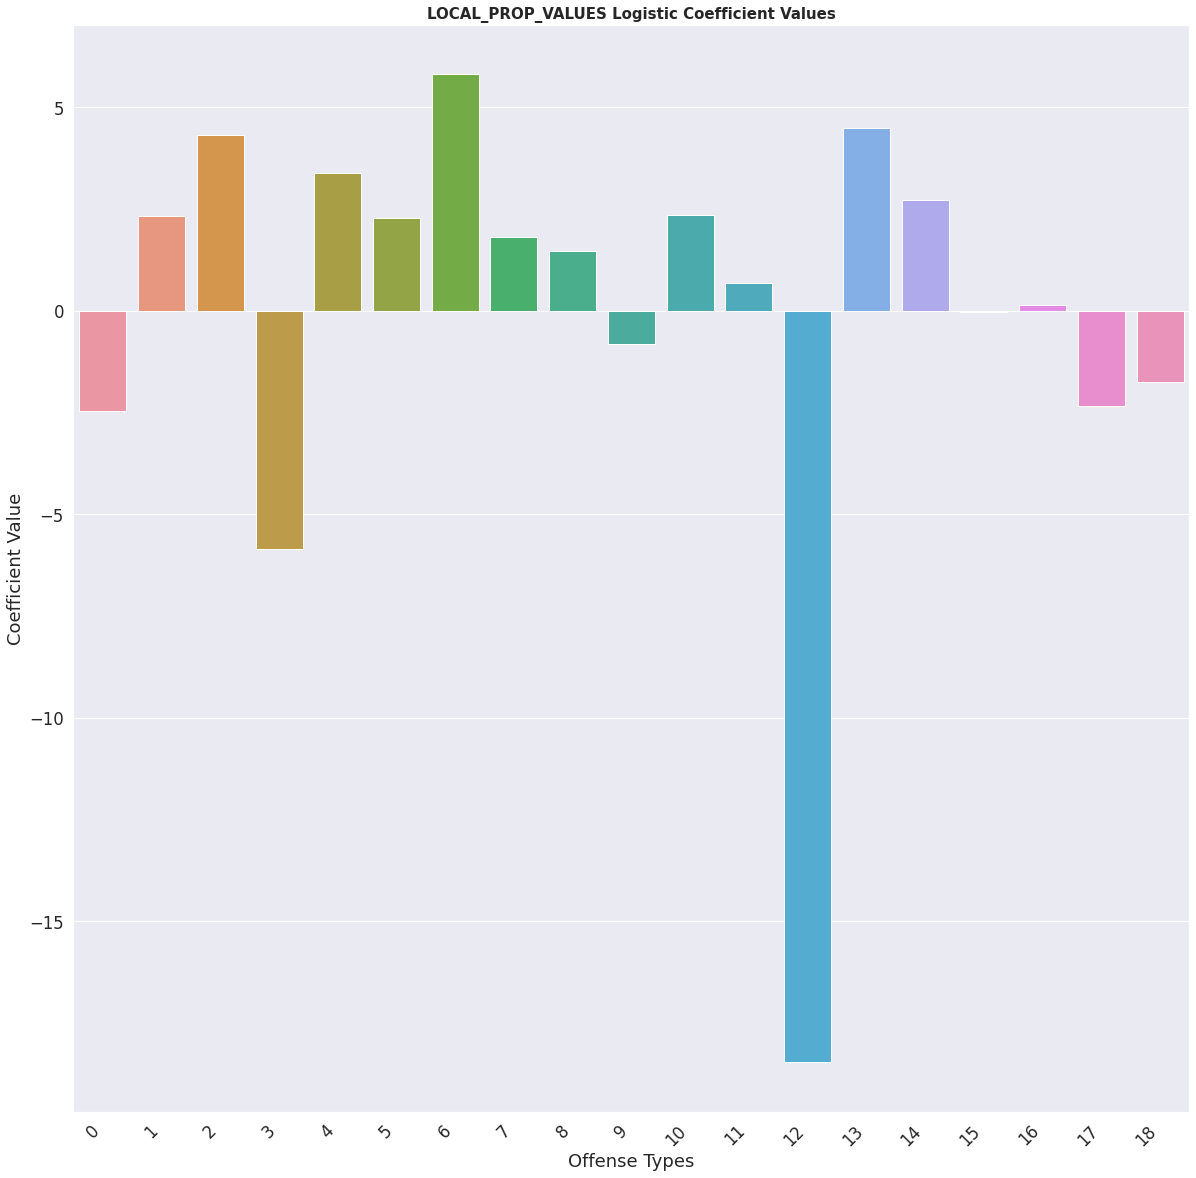

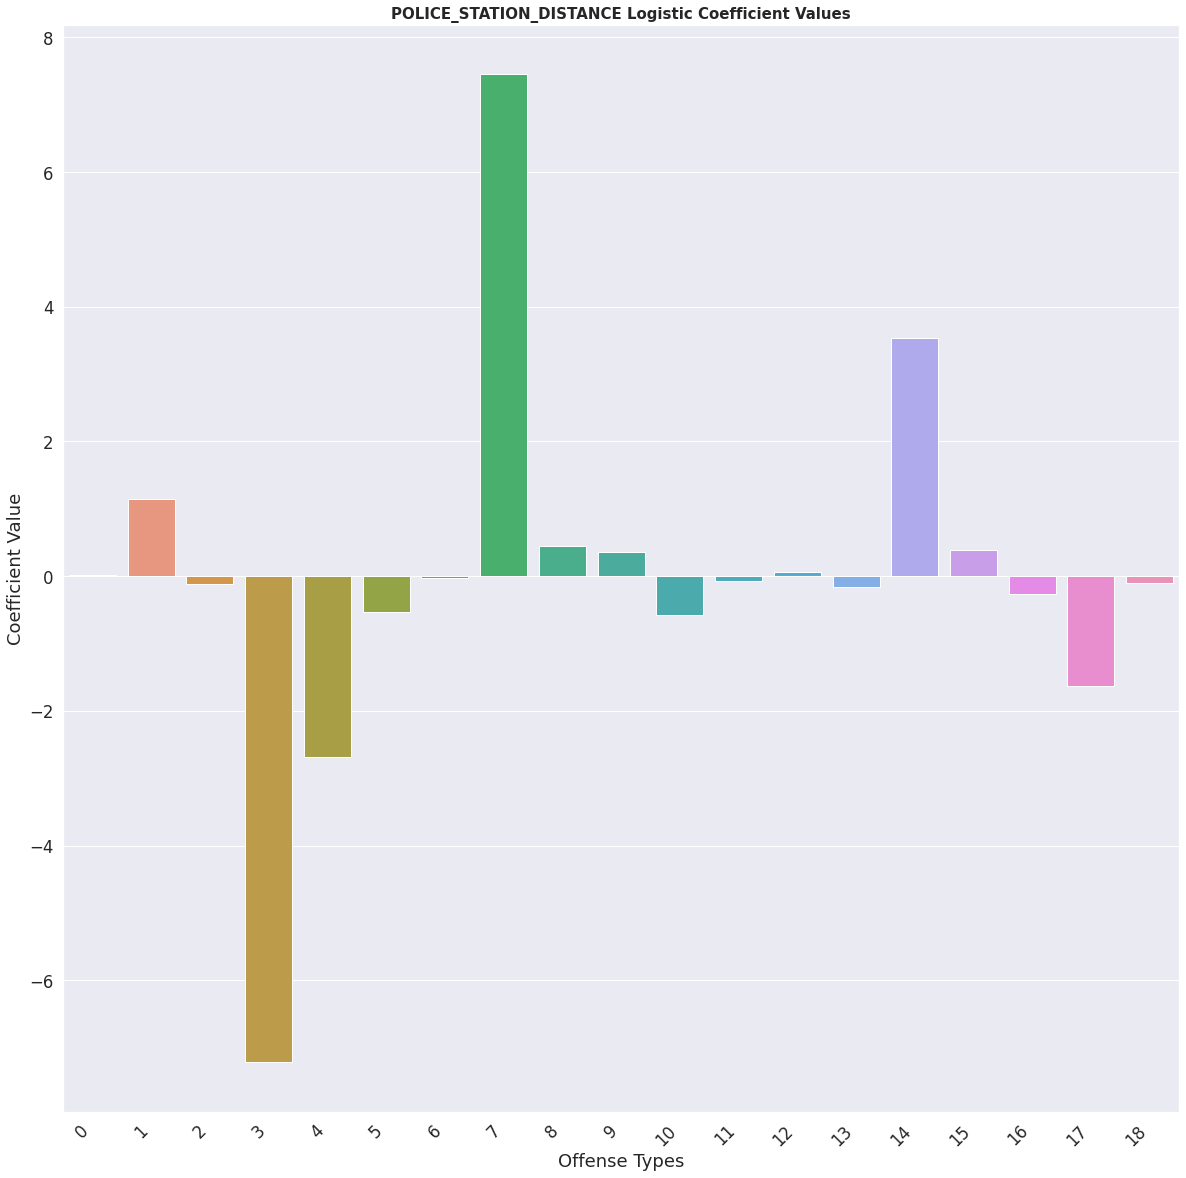

In [62]:
# Graph coefficent for each predicted value per feature
coeffs = {}

for i, k in enumerate(x_columns): 
    x = []
    y = []
    for j, classification in enumerate(demog_logit_full.classes_):
      x.append(classification)
      y.append(round(demog_logit_full.coef_[j][i],3))
    coeffs[k] = {"x": x, "y":y}  

for i, k in enumerate(["COVID_PERIOD","MEDIAN_INCOME","ELECTION","SNOW","PRCP","NIGHT","STREETLIGHT_DENSITY","LOCAL_PROP_VALUES","POLICE_STATION_DISTANCE"]):
  fig, ax = plt.subplots(figsize=(20,20))
  sns.barplot(x=coeffs[k]["x"], y=coeffs[k]["y"],ax=ax)
  ax.set_title(f"{k} Logistic Coefficient Values", fontdict={ 'weight' : 'bold','size': 15})
  ax.set_ylabel("Coefficient Value")
  ax.set_xlabel("Offense Types")
  ax.set_xticklabels(coeffs[k]["x"], rotation = 45, ha="right")
  plt.show()

We tried a few Random Forest models, but with a multiclass paradigm, plus one class that dominates over the rest (10, or Other), we go straight to balancing class weights. We also tried Adaboost with a Decision Tree Classifier and a Feed Forward Neural Network, but with a fair amount of noise in the data, it was hard to get good results with a neural network.

In the Random Forest model, we set `min_samples` to be 10 as a pruning measure, so as to navigate the bias/variance tradeoff. In the end, we see the same variables that were important to the previous models (like `POLICE_STATION_DISTANCE`) were relevant here.

# Random Forest (with Balanced Class Weights)

In [63]:
%%time
n_trees = 300
tree_depth = 20
min_samples = 10

rf_multi_bal = RandomForestClassifier(max_depth=tree_depth, n_estimators=n_trees, max_features='sqrt', random_state=51, class_weight="balanced_subsample", min_samples_leaf=min_samples)
rf_multi_bal.fit(x_train_norm, y_train)

y_pred_rf_multi_bal_train = rf_multi_bal.predict(x_train_norm)
y_pred_rf_multi_bal_test = rf_multi_bal.predict(x_test_norm)

rf_multi_bal_train = accuracy_score(y_train, y_pred_rf_multi_bal_train)
rf_multi_bal_test = accuracy_score(y_test, y_pred_rf_multi_bal_test)

print(f"""Random Forest - Boston/Offense Type (Balanced) with {tree_depth} max_depth and {n_trees} trees, 
train accuracy is {rf_multi_bal_train:.4f} and
test accuracy is {rf_multi_bal_test:.4f}""")

Random Forest - Boston/Offense Type (Balanced) with 20 max_depth and 300 trees, 
train accuracy is 0.2908 and
test accuracy is 0.1833
CPU times: user 6min 22s, sys: 640 ms, total: 6min 23s
Wall time: 6min 23s


In [64]:
y_pred_rf_multi_bal_train_bin = label_binarize(y_pred_rf_multi_bal_train, classes=labels)
y_pred_rf_multi_bal_test_bin = label_binarize(y_pred_rf_multi_bal_test, classes=labels)

auc_rf_multi_bal_train = roc_auc_score(y_train_bin, y_pred_rf_multi_bal_train_bin, average='macro',multi_class='ovo')
auc_rf_multi_bal_test = roc_auc_score(y_test_bin, y_pred_rf_multi_bal_test_bin, average='macro',multi_class='ovo')

print(f"""Random Forest Balanced AUCs(Boston/Offense Type) 
Train: {auc_rf_multi_bal_train:.4f}
Test: {auc_rf_multi_bal_test:.4f}
""")

Random Forest Balanced AUCs(Boston/Offense Type) 
Train: 0.8393
Test: 0.5965



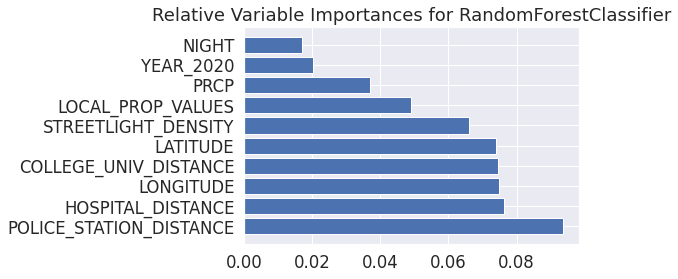

In [65]:
# Feature Importance for Random Forest 
plot_importances(rf_multi_bal, X_train, 10)

Even with models that achieve higher AUCs, it's hard to get our models to achieve a better accuracy. We can, again, look at the features to see why that is.

##**Principal Component Analysis - Offense Type Predictor Analysis**

In [66]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

ss = StandardScaler().fit(X_train)
Z_train = ss.transform(X_train)
Z_test = ss.transform(X_test)

pca_standard = PCA().fit(Z_train)
pca_Z_train = pca_standard.transform(Z_train)
pca_Z_test = pca_standard.transform(Z_test)

print(f"PCA Training Z Shape{pca_Z_train.shape}")
print(f"PCA Test Z Shape{pca_Z_test.shape}")

PCA Training Z Shape(393416, 78)
PCA Test Z Shape(98355, 78)


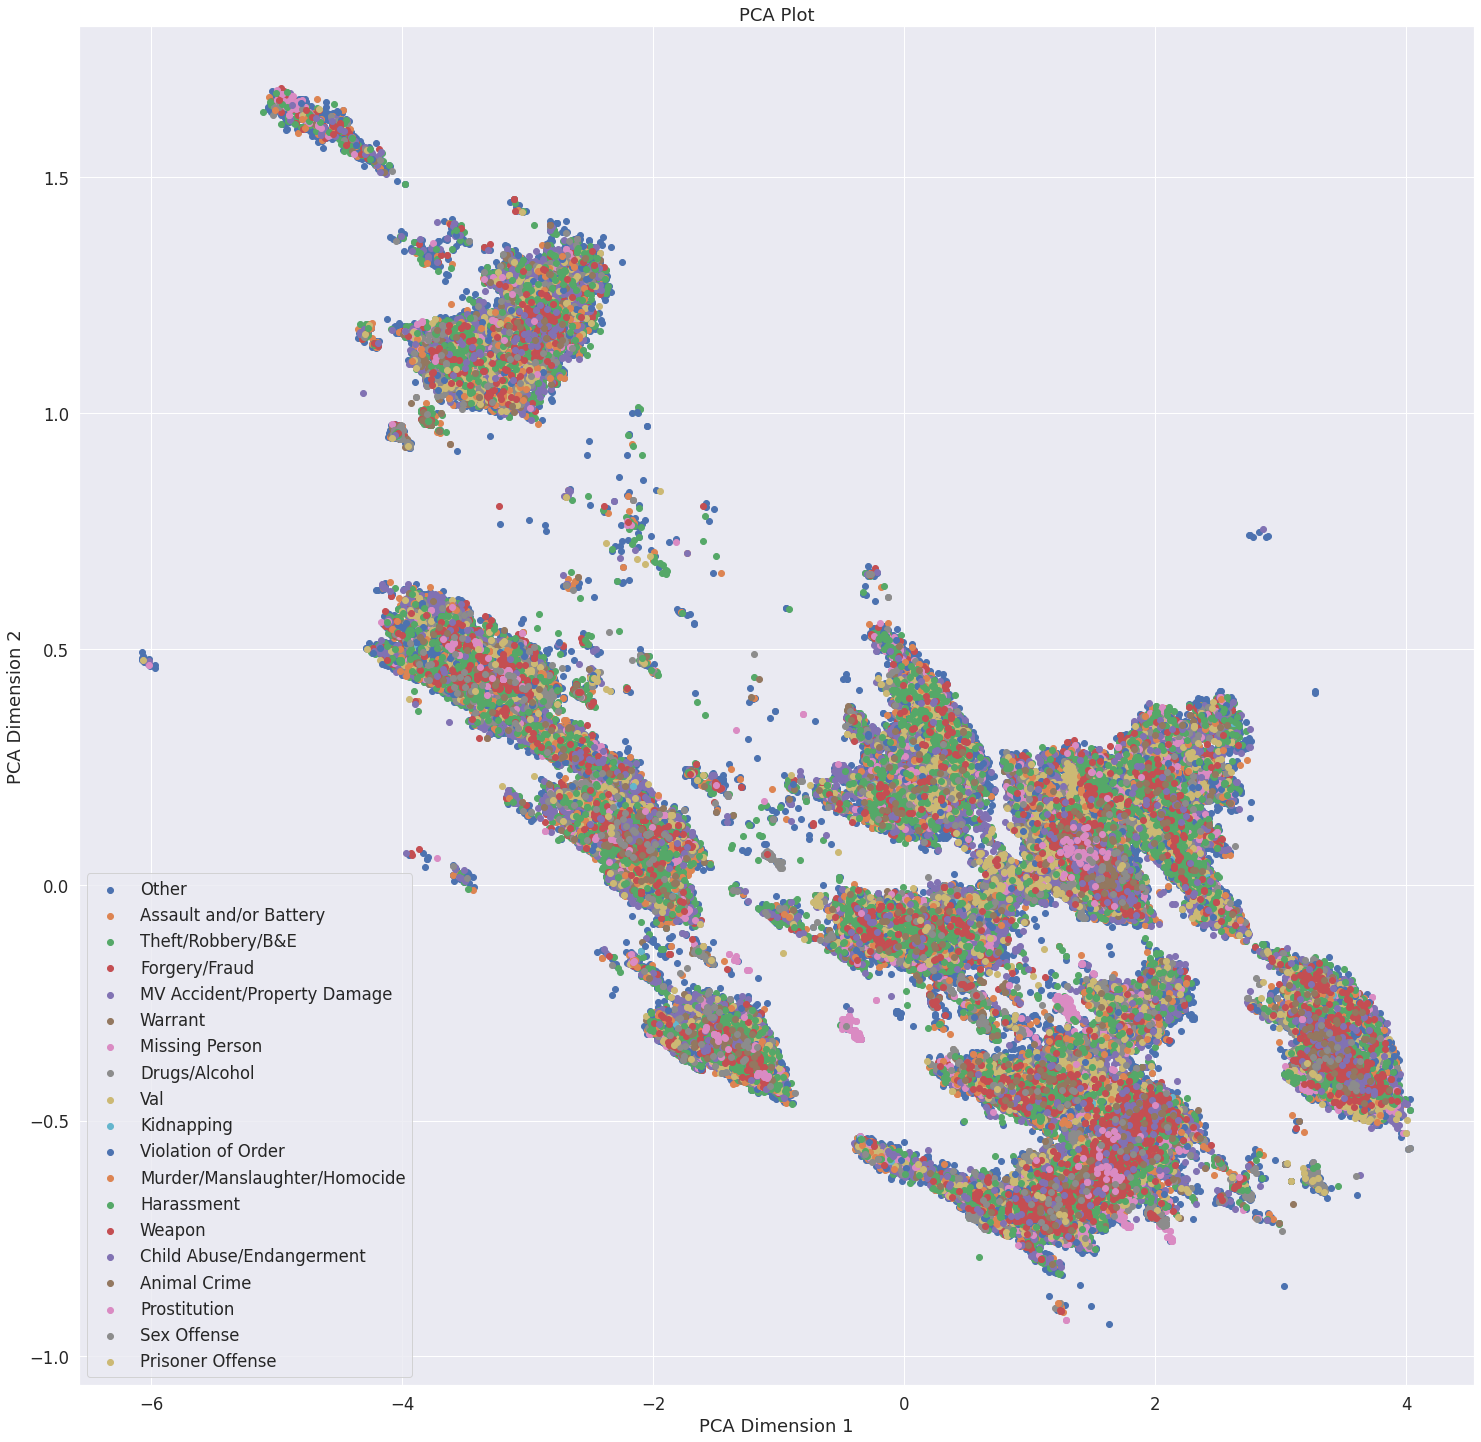

In [67]:
outlier_filter = (pca_Z_train[:,0] < 50) & (pca_Z_train[:,1]  < 50)
y_train_types = boston_crime_train['OFFENSE_TYPE'].values
y_train_types_filter = y_train_types[outlier_filter]
pca_Z_train_filter = pca_Z_train[outlier_filter]

label_text = boston_crime_train['OFFENSE_TYPE'].unique()
colors = ['orange','blue']
fig, ax = plt.subplots(figsize=(25,25))

for i, offense_type in enumerate(label_text):
    cur_df = pca_Z_train_filter[y_train_types_filter==offense_type]
    ax =plt.scatter(x=cur_df[:,0], y=cur_df[:,1], label=label_text[i])

plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.title("PCA Plot")
plt.legend();
plt.show()

It's clear that the predictors are, again, very clustered, making it difficult for a model to make a clear prediction as to offense type.

# **Offense Type Prediction (FULL)**

For the full Boston/New York dataset, we went through the same steps as above. Here, we can see the effectiveness of the Random Forest model. 

Other models we tried were Logistic Regression and Adaboost, but those models were very time-intensive, and didn't return large improvements on accuracy.

In [68]:
# we'll now evaluate for violent crime in using both cities using all features (minus the other response variable for Offense Type)
demog_category_columns = ['YEAR', 'MONTH', 'DAY_OF_WEEK', 'HOUR']
train_crime_demog_dummies_df = pd.get_dummies(comb_crime_train.drop(columns=["OFFENSE_TYPE"]), columns=demog_category_columns)
test_crime_demog_dummies_df = pd.get_dummies(comb_crime_test.drop(columns=["OFFENSE_TYPE"]), columns=demog_category_columns)

# select all columns from dummies minus response, Geohash, Latitude, Longitude 
x_columns = train_crime_demog_dummies_df.drop(columns=["VIOLENT_CRIME","GEOHASH","LATITUDE","LONGITUDE","AREA"]).columns

X_train = train_crime_demog_dummies_df[x_columns]
X_test = test_crime_demog_dummies_df[x_columns]

demog_scaler = MinMaxScaler()
demog_scaler.fit(X_train)
x_train_norm = demog_scaler.transform(X_train)
x_test_norm = demog_scaler.transform(X_test)

y_train = comb_crime_train['OFFENSE_TYPE'].astype('category').cat.codes
y_test = comb_crime_test['OFFENSE_TYPE'].astype('category').cat.codes

In [69]:
# binarizing multi_y train/test for to get AUC scores
labels = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
full_multi_y_train_bin = label_binarize(y_train, classes=labels)
full_multi_y_test_bin = label_binarize(y_test, classes=labels)

In [70]:
%%time
# Generalized multifactor with pruning
n_trees = 300
tree_depth = 20
min_samples = 10

rf_multi_full_bal = RandomForestClassifier(max_depth=tree_depth, n_estimators=n_trees, max_features='sqrt', class_weight="balanced_subsample", random_state=51, min_samples_leaf=min_samples)
rf_multi_full_bal.fit(x_train_norm, y_train)

y_pred_rf_multi_full_bal_train = rf_multi_full_bal.predict(x_train_norm)
y_pred_rf_multi_full_bal_test = rf_multi_full_bal.predict(x_test_norm)

rf_multi_full_bal_train = accuracy_score(y_train, y_pred_rf_multi_full_bal_train)
rf_multi_full_bal_test = accuracy_score(y_test, y_pred_rf_multi_full_bal_test)

print(f"""Random Forest (generalized/offense type/balanced) with {tree_depth} max_depth and {n_trees} trees and {min_samples} minimum samples per leaf, 
train accuracy is {rf_multi_full_bal_train:.4f} and
test accuracy is {rf_multi_full_bal_test:.4f}""")

Random Forest (generalized/offense type/balanced) with 20 max_depth and 300 trees and 10 minimum samples per leaf, 
train accuracy is 0.2413 and
test accuracy is 0.1812
CPU times: user 11min 30s, sys: 1.38 s, total: 11min 31s
Wall time: 11min 32s


In [71]:
y_pred_rf_multi_full_bal_train_bin = label_binarize(y_pred_rf_multi_full_bal_train, classes=labels)
y_pred_rf_multi_full_bal_test_bin = label_binarize(y_pred_rf_multi_full_bal_test, classes=labels)

auc_rf_multi_full_bal_train = roc_auc_score(full_multi_y_train_bin, y_pred_rf_multi_full_bal_train_bin, average='macro',multi_class='ovo')
auc_rf_multi_full_bal_test = roc_auc_score(full_multi_y_test_bin, y_pred_rf_multi_full_bal_test_bin, average='macro',multi_class='ovo')

print(f"""Random Forest AUCs(Generalized/Offense Type) 
Train: {auc_rf_multi_full_bal_train:.4f}
Test: {auc_rf_multi_full_bal_test:.4f}
""")

Random Forest AUCs(Generalized/Offense Type) 
Train: 0.8270
Test: 0.6302



We look at the feature importances here.

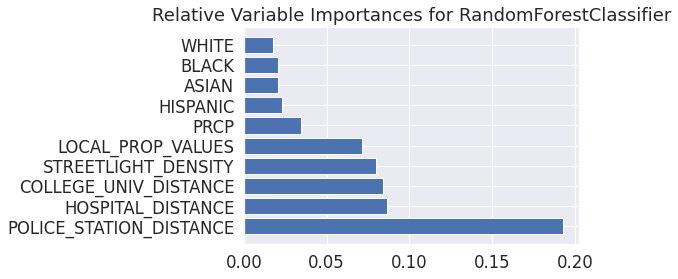

In [72]:
plot_importances(rf_multi_full_bal,X_train, 10)

#**AdaBoost Model - Violent Crime Prediction**

Here is the AdaBoost we used for violent crime, both in the Boston-only dataset and the Boston+NYC dataset; it's at the end of the notebook because it takes a while, but we can see that its results (at least in this case) aren't much improved.

##**Boston Violent Crime**

In [73]:
# Let's give adaboost a shot
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

def adaboost(depth, num_estimators, learning_rate, X_train, y_train, X_test, y_test):
    boost = AdaBoostClassifier( base_estimator = DecisionTreeClassifier(max_depth = depth), n_estimators=num_estimators, learning_rate=learning_rate)
    boost.fit(X_train, y_train)
    train_staged_score = list(boost.staged_score(X_train, y_train))
    test_staged_score = list(boost.staged_score(X_test, y_test))
    return train_staged_score, test_staged_score


In [74]:
# we'll evaluate for violent crime in Boston using all features (minus the other response variable for Offense Type)
demog_category_columns = ['AREA', 'YEAR', 'MONTH', 'DAY_OF_WEEK', 'HOUR']
train_crime_demog_dummies_df = pd.get_dummies(boston_crime_train.drop(columns=["OFFENSE_TYPE"]), columns=demog_category_columns)
test_crime_demog_dummies_df = pd.get_dummies(boston_crime_test.drop(columns=["OFFENSE_TYPE"]), columns=demog_category_columns)

# select all columns from dummies minus response and Geohash 
x_columns = train_crime_demog_dummies_df.drop(columns=["VIOLENT_CRIME","GEOHASH"]).columns
X_train = train_crime_demog_dummies_df[x_columns]
X_test = test_crime_demog_dummies_df[x_columns]
y_train = train_crime_demog_dummies_df['VIOLENT_CRIME'].values
y_test = test_crime_demog_dummies_df['VIOLENT_CRIME'].values

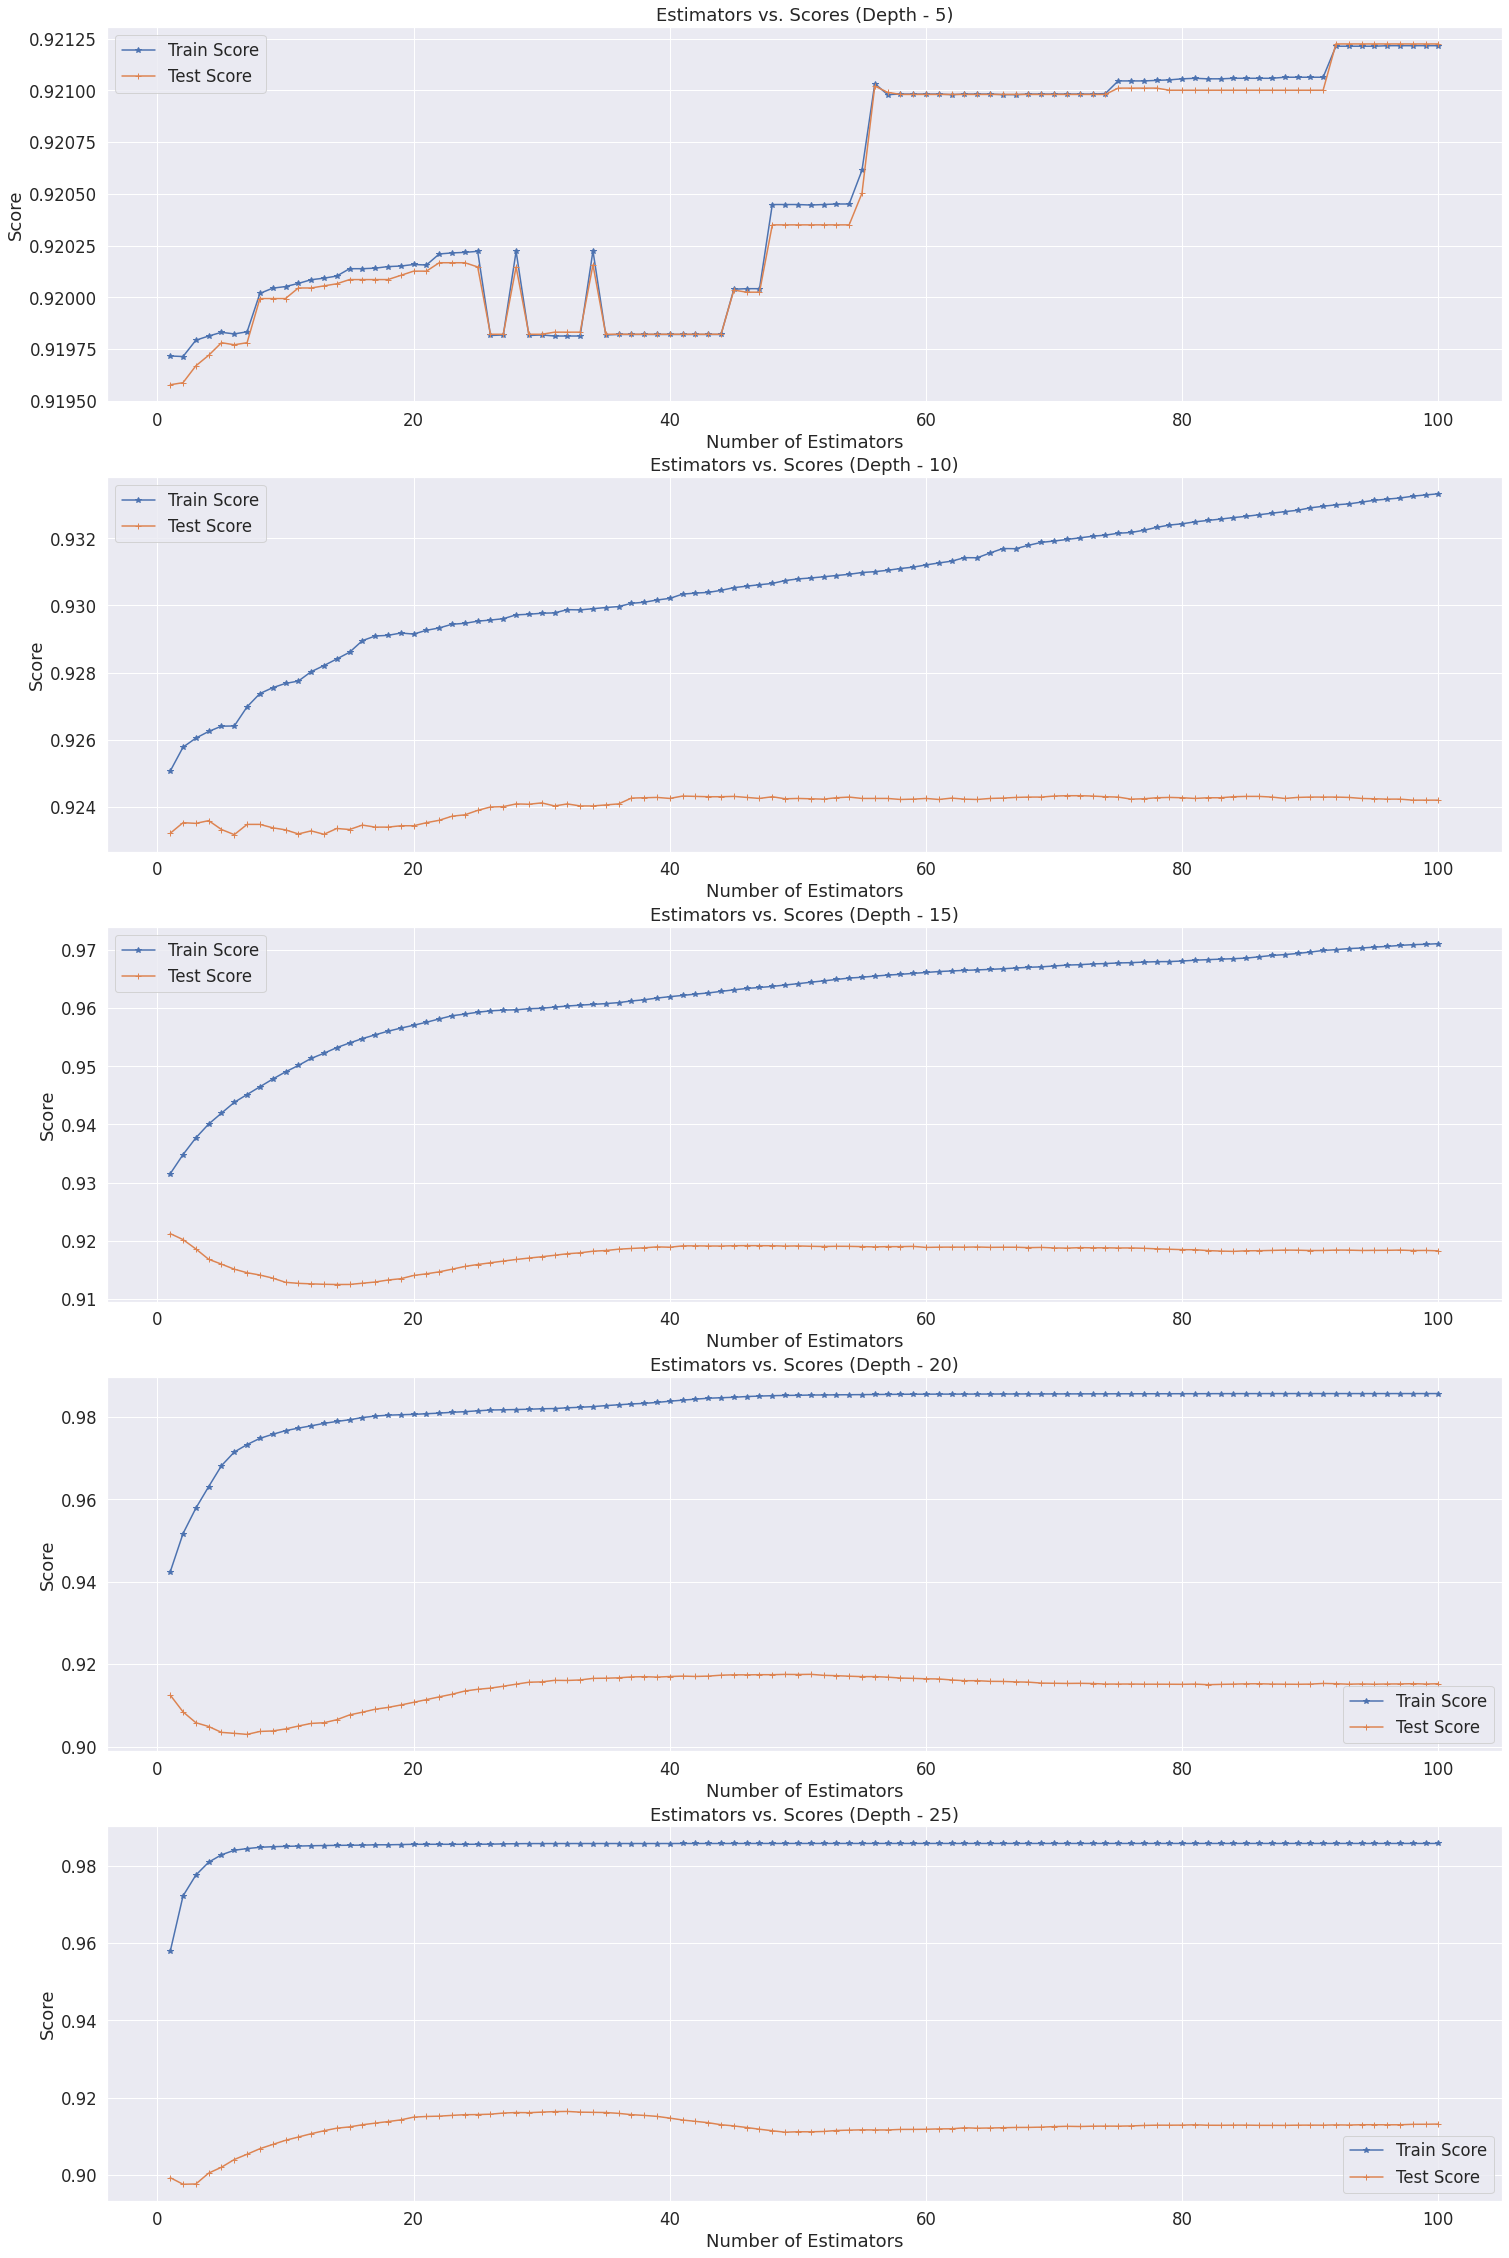

In [75]:
depths = [5,10,15,20,25]
n_estimators = 100
learning_rate = .05
num_estimators = range(1, 101)
fig, axs = plt.subplots(nrows=len(depths),ncols=1,figsize=(25,40))
score_gap = []
best_score = []
best_iteration = []

for i, depth in enumerate(depths):
    train, test = adaboost(depth,n_estimators,learning_rate, X_train, y_train, X_test, y_test)
    max_idx = np.argmax(test)
    best_score.append(test[max_idx])
    best_iteration.append(max_idx)
    score_gap.append(np.abs(train[max_idx] - test[max_idx]))
    axs[i].plot(num_estimators, train, '*-', label="Train Score")
    axs[i].plot(num_estimators, test, '-+', label="Test Score")
    axs[i].legend()
    axs[i].set_title(f"Estimators vs. Scores (Depth - {depth})")
    axs[i].set_ylabel("Score")
    axs[i].set_xlabel("Number of Estimators")  

In [76]:
boost_depth_performance = {'depths': depths, 'best test score': best_score, 'train-test delta':score_gap, 'iteration': best_iteration}
pd.DataFrame.from_dict(boost_depth_performance).set_index('depths')

best test score  train-test delta  iteration
depths                                              
5              0.921224          0.000011         91
10             0.924335          0.007630         70
15             0.921244          0.010291          0
20             0.917533          0.067821         50
25             0.916466          0.069224         31

The best test score is a depth of 10 however the model with the smallest difference between train-test is with a depth of 5.

##**Combined (Boston/NYC) Violent Crime Prediction**

In [77]:
# we'll now evaluate for violent crime in using both cities using all features (minus the other response variable for Offense Type)
demog_category_columns = ['YEAR', 'MONTH', 'DAY_OF_WEEK', 'HOUR']
train_crime_demog_dummies_df = pd.get_dummies(comb_crime_train.drop(columns=["OFFENSE_TYPE"]), columns=demog_category_columns)
test_crime_demog_dummies_df = pd.get_dummies(comb_crime_test.drop(columns=["OFFENSE_TYPE"]), columns=demog_category_columns)

# select all columns from dummies minus response, Geohash, Latitude, Longitude 
x_columns = train_crime_demog_dummies_df.drop(columns=["VIOLENT_CRIME","GEOHASH","LATITUDE","LONGITUDE","AREA"]).columns

X_train = train_crime_demog_dummies_df[x_columns]
X_test = test_crime_demog_dummies_df[x_columns]
y_train = train_crime_demog_dummies_df['VIOLENT_CRIME'].values
y_test = test_crime_demog_dummies_df['VIOLENT_CRIME'].values


KeyboardInterrupt: ignored

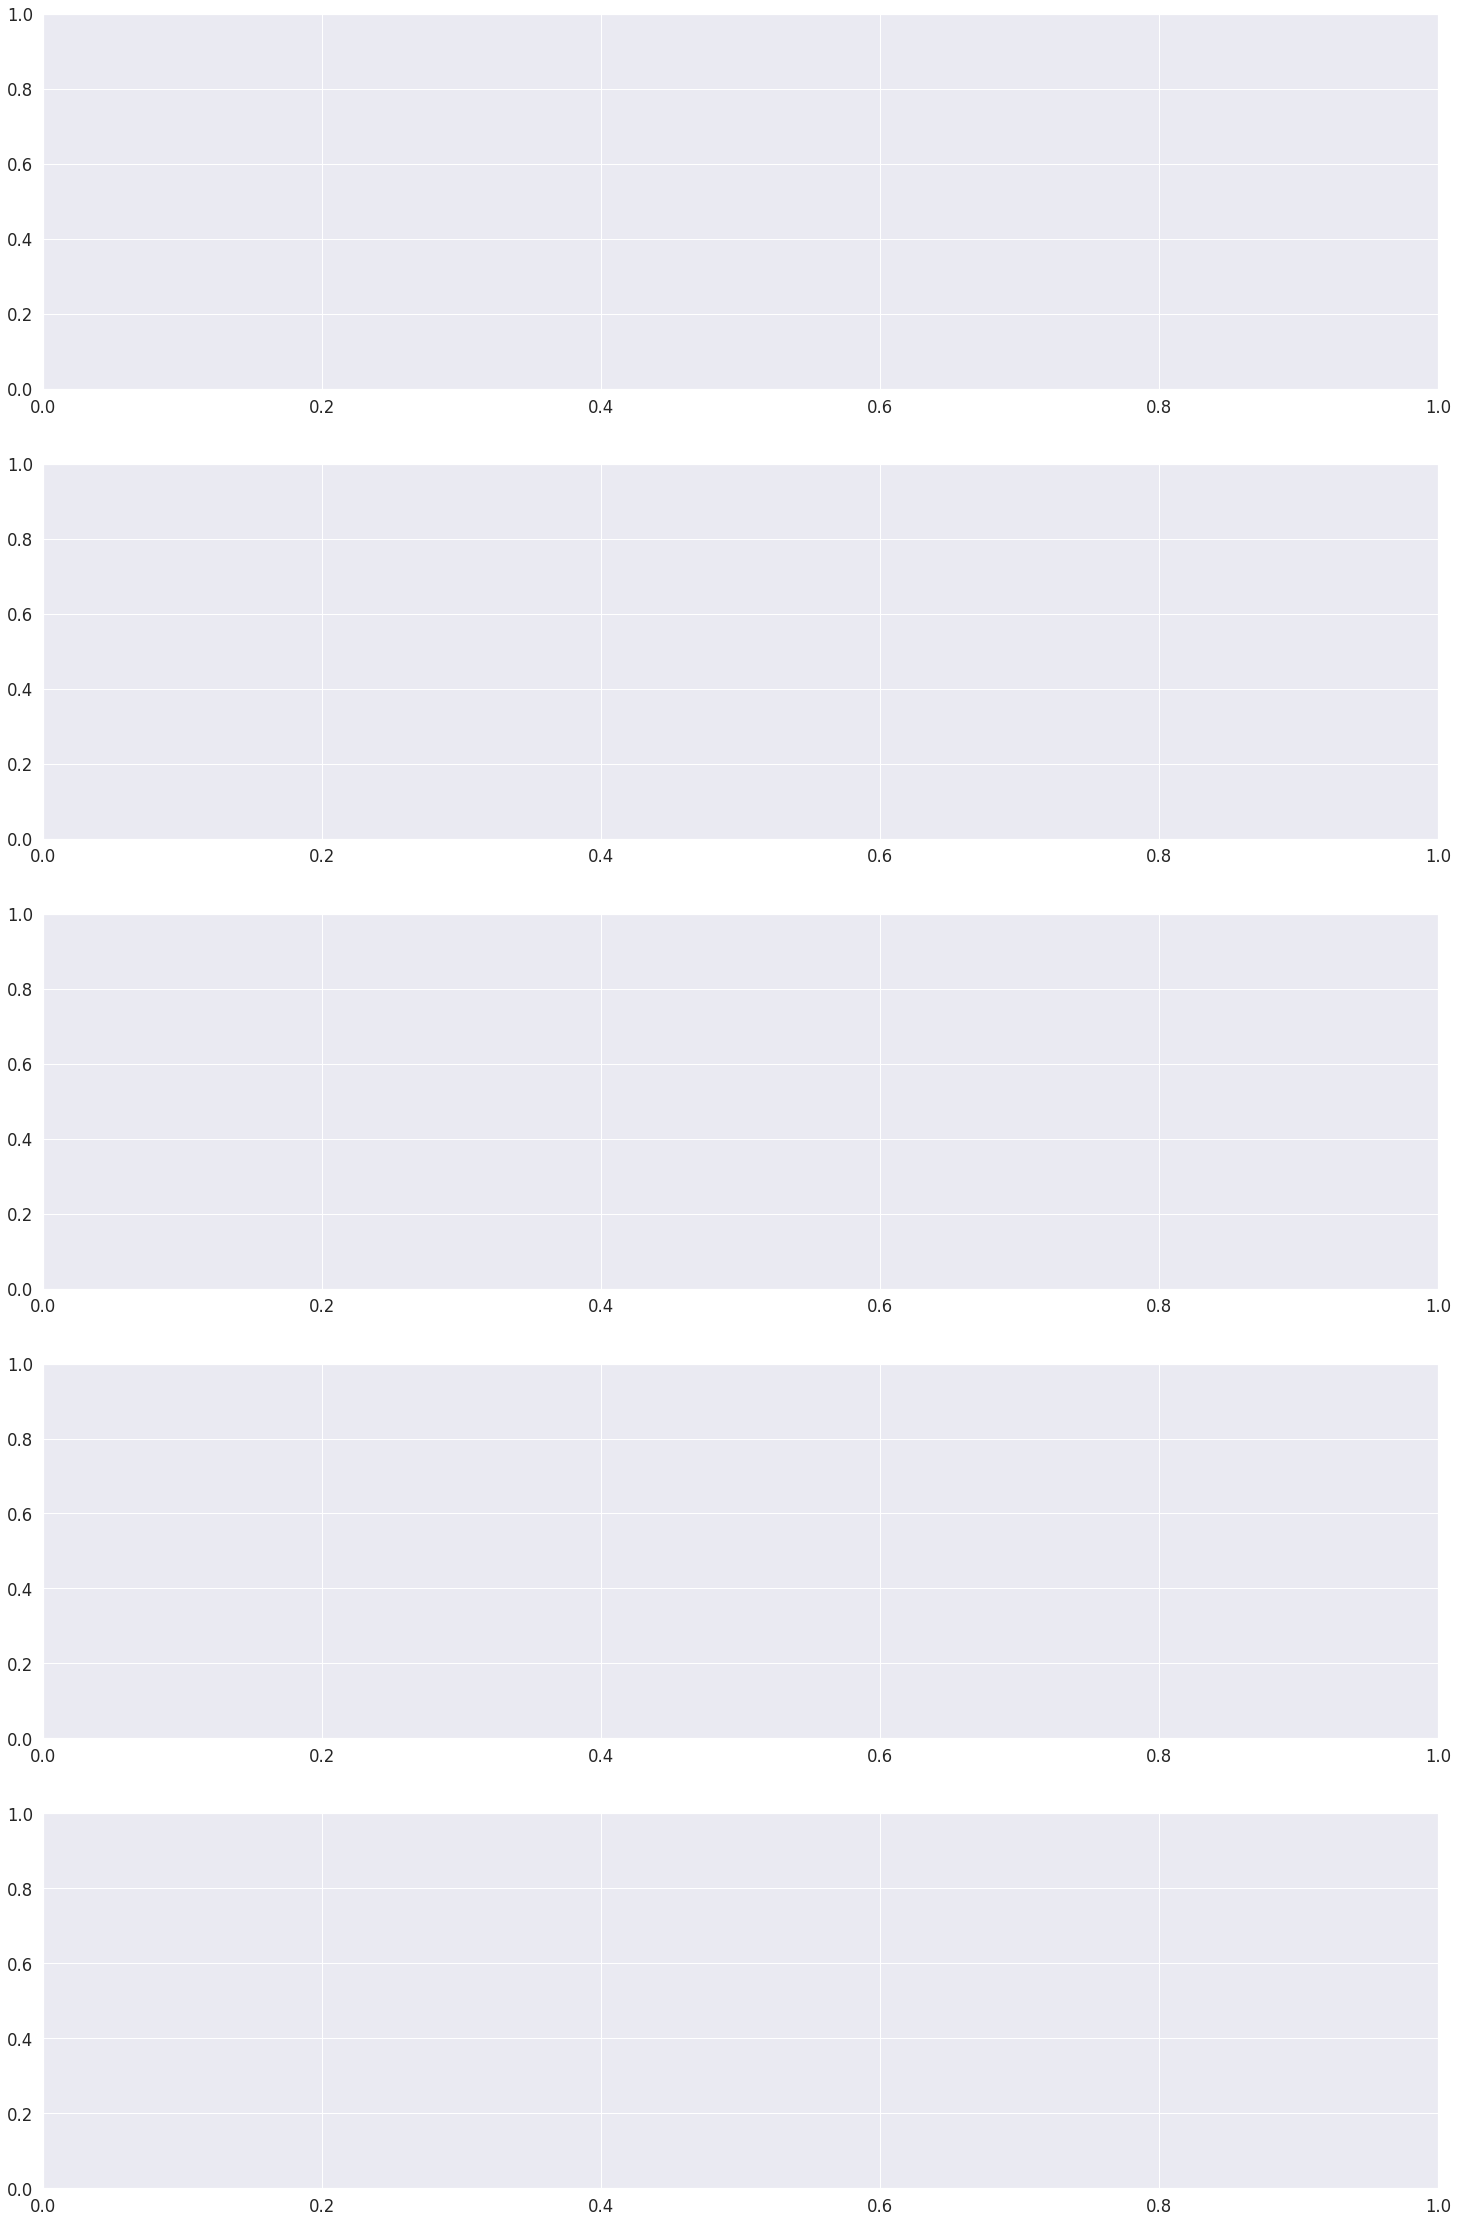

In [78]:
depths = [5,10,15,20,25]
n_estimators = 100
learning_rate = .05
num_estimators = range(1, 101)
fig, axs = plt.subplots(nrows=len(depths),ncols=1,figsize=(25,40))
score_gap = []
best_score = []
best_iteration = []

for i, depth in enumerate(depths):
    train, test = adaboost(depth,n_estimators,learning_rate,X_train, y_train, X_test, y_test)
    max_idx = np.argmax(test)
    best_score.append(test[max_idx])
    best_iteration.append(max_idx)
    score_gap.append(np.abs(train[max_idx] - test[max_idx]))
    axs[i].plot(num_estimators, train, '*-', label="Train Score")
    axs[i].plot(num_estimators, test, '-+', label="Test Score")
    axs[i].legend()
    axs[i].set_title(f"Estimators vs. Scores (Depth - {depth})")
    axs[i].set_ylabel("Score")
    axs[i].set_xlabel("Number of Estimators")  

In [ ]:
boost_depth_performance = {'depths': depths, 'best test score': best_score, 'train-test delta':score_gap, 'iteration': best_iteration}
pd.DataFrame.from_dict(boost_depth_performance).set_index('depths')

The best test score is a depth of 10 however the model with the smallest difference between train-test is with a depth of 5.

# Appendix: Assorted EDA

# **Boston Correlation Data with Offense Type Indicators - (Day of Week)**

In [ ]:
#Focus on Day of Week for Violent Crime 
demog_category_columns = ["DAY_OF_WEEK","OFFENSE_TYPE"]
boston_hour_day_df = boston_crime_data_df[["DAY_OF_WEEK","OFFENSE_TYPE","VIOLENT_CRIME"]]
boston_hour_day_dummies_df = pd.get_dummies(boston_hour_day_df, columns=demog_category_columns)
boston_hour_day_corr = boston_hour_day_dummies_df.corr()
fig, ax = plt.subplots(figsize=(50,50)) 
sns.set(font_scale=1.5)
ax = sns.heatmap(boston_hour_day_corr, annot=True, cmap='coolwarm', linewidths=.5, annot_kws={"fontsize":10})

# **Boston Correlation Data with Offense Type Indicators - (Hour of Day)**

In [ ]:
#Focus on Hour of Day
demog_category_columns = ["HOUR","OFFENSE_TYPE"]
boston_hour_day_df = boston_crime_data_df[["HOUR","VIOLENT_CRIME","OFFENSE_TYPE"]]
boston_hour_day_dummies_df = pd.get_dummies(boston_hour_day_df, columns=demog_category_columns)
boston_hour_day_corr = boston_hour_day_dummies_df.corr()
fig, ax = plt.subplots(figsize=(50,50)) 
sns.set(font_scale=1.5)
ax = sns.heatmap(boston_hour_day_corr, annot=True, cmap='coolwarm', linewidths=.5, annot_kws={"fontsize":10})